This notebook is exploring applying Optimal Transport (OT) as an anomaly score method. This is just exploratory to see how well it does out of the gate.

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for doing some preliminary exploration!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022), 
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [1]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Random thoughts on usage and impact

Note the intention for this dataset was to be used to develop methods that could work at Trigger Level:

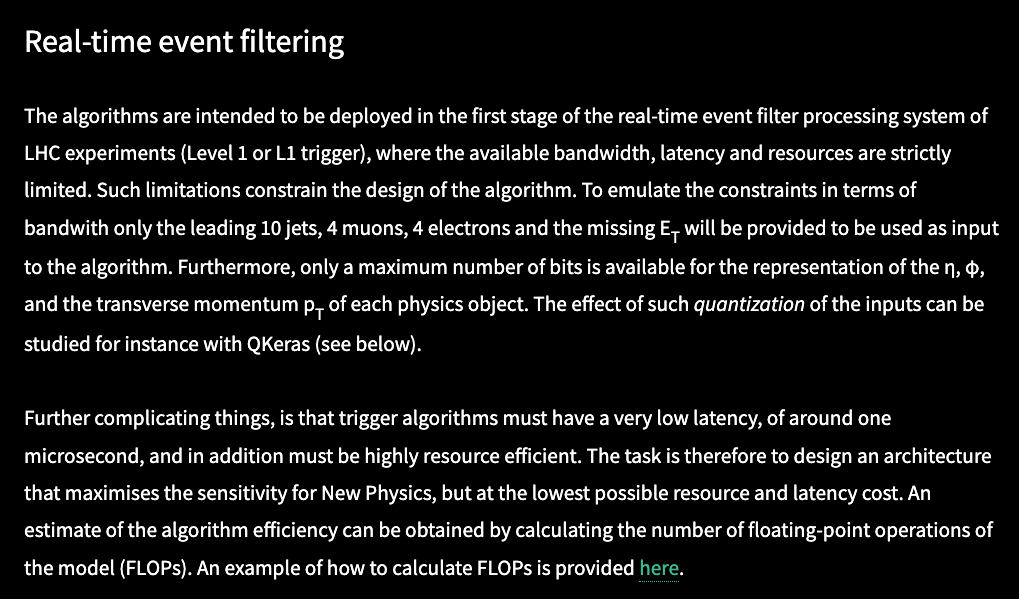

Pre-trained ML methods like Autoencoders would only need to be evaluated event-to-event. Thus, their cost is simply the cost to store their trained architecture and evaluate it in the forward direction.

The question is how Optimal Transport (OT) would compare? Here, you would need to store some number, $N$, of representative background events. Then, for each event, you would need to calculate $N$ OT distances. A priori this might mean that OT is only suitable for off-line anomaly detection.

Two strategies to speed this up that might be worth investigating:

**1.   Linearized OT:**

Here, we would store the linearized embedding of the $N$ representative background events (calculated with respect to some reference event). We would then only need to calculate 

*   1 OT distance between the event at hand and the reference event
*   $N$ euclidean distances (between the event and each of the $N$ embedded background events

**2. Predefine a manifold of background events, calculate OT distance to it:**

Assuming that the events will be off-manifold, if we can do this then we need to only do one OT distance calculation (from the event to the manifold).

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)).

In [2]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.9 MB/s eta 0:00:00


In [3]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
import ot
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

## Data handling functions

In [4]:
def calcGroundCostMatrix(xs, xt, MODE='Normal'):
  """
  Calculate ground cost matrix between xs and xt

  Inputs:
     xs:  3D coordinates of 19 source particles (shape=(19,3))
     xt:  3D coordinates of 19 source particles (shape=(19,3))

  Output:
     If MODE=='Normal', returns matrix of pair-wise |x - y|^2 distances.
     If MODE=='Modular', it assumes that the last coordinate of the 3 is \phi 
     which is modular and takes this into account when computing the matrix of 
     pair-wise |x - y|^2 distances

  """
  if MODE=='Normal':
    return ot.dist(xs, xt)
  elif MODE=='Modular':
    #! Faster way? 
    # Modified from Tianji's code
    #   d_phis = np.pi - np.abs(np.pi - np.abs(jet1_coords[:,1,None]-jet2_coords[:,1]))
    #   squareDist = (jet1_coords[:,0,None]-jet2_coords[:,0])**2 + d_phis**2

    # Note according to this thread, this way of calculating modular differences may fail if deltaPhi_raw > 360 deg (2 pi) 
    # However, since the input is between -pi and pi, the max possible is 2pi so it shouldn't be a problem
    # https://stackoverflow.com/questions/1878907/how-can-i-find-the-smallest-difference-between-two-angles-around-a-point
    # It is also unsigned, however since we will square it that doesn't matter

    deltaPT      = xs[:,0,None] - xt[:,0]
    deltaEta     = xs[:,1,None] - xt[:,1]
    deltaPhi_raw = xs[:,2,None] - xt[:,2]
    deltaPhi     = np.pi - np.abs(np.pi - np.abs(deltaPhi_raw))  
    return deltaPT**2 + deltaEta**2 + deltaPhi**2
  else: # Test mode
    deltaPT      = xs[:,0,None] - xt[:,0]
    deltaEta     = xs[:,1,None] - xt[:,1]
    deltaPhi_raw = xs[:,2,None] - xt[:,2]
    return deltaPT**2 + deltaEta**2 + deltaPhi_raw**2

In [5]:
def calcOTGeneral(xEvents, yEvents):
  """
  Solve the optimal transport problem for a set of source events (xEvents) and 
  target events (yEvents) assuming |x - y|^2 is the ground cost function.

  Inputs:
     xEvents:  Array of sample of x-type events, shape (N, 19, 3)
     yEvents:  Array of sample of y-type events, shape (N, 19, 3)

  Outputs
     CXY:  Array of the X-to-Y OT cost matrices, shape (N**2, 19, 19)
     wXY:  Array of the corresponding Wasserstein distances
  
  NOTE: We're using the following references:
  - https://pythonot.github.io/auto_examples/plot_OT_2D_samples.html#sphx-glr-auto-examples-plot-ot-2d-samples-py
  - https://pythonot.github.io/quickstart.html#solving-optimal-transport
  """

  # Create lists for outputs
  CXY, wXY = [], []
  
  # Get number of signal and background events
  #! Make more general later to handle different number of x and y events
  assert(xEvents.shape[0] == yEvents.shape[0]) 
  N = xEvents.shape[0]  

  # Assume that all "particles" are equally weighted 
  #! In the example "n" was number of samples... is this adaptation ok?
  # https://pythonot.github.io/all.html#ot.emd
  nParticles = xEvents.shape[1] #19
  a = np.ones((nParticles,)) / nParticles
  b = a

  #-- Loop over pairs of events --#
  # We use itertools to make looping more efficient (i.e. do double for loops)
  dummyArr = np.arange(N)
  for (i,j) in itertools.product(dummyArr, dummyArr):
    
    xs = xEvents[i, :, :] # "source data points"

    #-- Solve X-Y OT problem  --#

    # Calculate XY cost matrix
    xt = yEvents[j, :, :] # "target data points"
    #cxy = ot.dist(xs, xt)
    cxy = calcGroundCostMatrix(xs, xt, MODE='Modular')
    CXY.append(cxy)

    # Calculate the Wasserstein distance
    wXY.append(ot.emd2(a, b, cxy))

  return np.array(CXY), np.array(wXY)

In [6]:
def randomDataSample(data, nEvents, random_state):
  """
  Generate a random sample of data by generating a 1D array of nEvents uniform 
  random integers and returning the events corresponding to these integers.

  Inputs:
    data:          Total data array of shape (nTotal, 19, 3)
    nEvents:       Number of events to sample
    random_state:  The generator to use to generate the samples (for reproducibility)
  
  Outputs:
    Selected events; shape (nEvents, 19, 3)
  """
  #! Pretty slow in practice (not sure why), make it faster later
  
  nTotal = data.shape[0]
  randomIntArray = random_state.integers(0,nTotal,nEvents)

  return data[randomIntArray, :, :]

In [7]:
def calcAUC(scoreBkg, scoreSig):
  """
  Given the anomaly scores for background and signal events, calculate the AUC.

  Inputs:
    scoreBkg:   Anomaly score values for N background events; shape (N,)
    scoreSig:   Anomaly score values for M signal events; shape (M,)
  
  Outputs:
    auc:        Area Under the Curve (AUC) value; float
    labels:     Numeric background/signal labels; 0 for background, 1 for signal 
                (necessary for ROC and AUC calculations); shape (N+M,)
    scores:     Concatenated anomaly scores from background and signal events;
                (necessary for ROC and AUC calculations); shape (N+M,) 
  
  NOTE: Using the sklearn.metrics.roc_auc_score() function
  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
  """

  labelsB = np.repeat(0, scoreBkg.shape[0]) # Background labels
  labelsS = np.repeat(1, scoreSig.shape[0]) # Signal labels
  labels  = np.concatenate((labelsB, labelsS))

  scores  =  np.concatenate((scoreBkg, scoreSig))

  auc = metrics.roc_auc_score(labels, scores)

  return auc, labels, scores

In [8]:
def calcROCmetrics(scoreBkg, scoreSigList, SIreg=0.0001):
  """
  Calculate 4 metrics related to ROC curve components:
      - AUC
      - Background efficiency (aka FPR or eps_B), Signal efficiency (aka TPR or eps_S)
      - Significance Improvement (SI) defined as eps_S/sqrt(eps_B + SIreg) <=> TPR/sqrt(FPR + SIreg)
        where SIreg is a regulator for statistical fluctuations at low efficiency; SIreg=0.01% by default
        Reference: https://arxiv.org/pdf/2001.05001.pdf
      - Inverse Background efficiency (aka FPR^{-1} or eps_B^{-1}); division by zero is masked
  
  Inputs:
    scoreBkg:      Anomaly score values for N background events; shape (N,)
    scoreSigList:  List of anomaly score values for each signal type case; Length=nCases
                   scoreSigList[i] is the anomaly score for M signal events of the ith signal type case; shape (M,)
    SIreg:         Regulator to prevent division by zero when calculating SI metric; default 0.01%

  Outputs:
    aucList:       List of AUC scores for each background to signal type pairing; Length=nCases
    fprList:       List of FPR arrays for each background to signal type pairing; Length=nCases
                   fprList[i] is an array of shape (Q,) with Q>2
    tprList:       List of TPR arrays for each background to signal type pairing; Length=nCases
                   tprList[i] is an array of shape (Q,) with Q>2
    SIList:        List of SI arrays for each background to signal type pairing; Length=nCases
                   SIList[i] is an array of shape (Q,) with Q>2
    fprInvList:    List of inverse FPR arrays for each background to signal type pairing; Length=nCases
                   fprInvList[i] is a masked array of shape (Q,) with Q>2 with division by zero cases masked
  """
  
  #-- Preliminaries --#
  nCases    = len(scoreSigList) # Number of signal cases
  aucList, fprList, tprList, SIList, fprInvList = [], [], [], [], [] # Create lists to store results
  
  #-- Loop over signal cases --#
  for i in range(nCases):
    scoreSig = scoreSigList[i]

    #-- Calculate AUC (and, internally, label and score inputs for sklearn's function) --#
    auc, labels, scores = calcAUC(scoreBkg, scoreSig)
    aucList.append(auc)

    #-- Calculate other ROC curve metrics --#
    fpr, tpr, _ = metrics.roc_curve(labels, scores)
    fprList.append(fpr)
    tprList.append(tpr)

    #-- Calculate SI metric --#
    # Def: eps_S/sqrt(eps_B + SIreg) <=> TPR/sqrt(FPR + SIreg)
    fpr_sqrt = np.sqrt(fpr + SIreg)
    SI = tpr/fpr_sqrt 
    SIList.append(SI)

    #-- Calculate inverse FPR metric --#
    #! Should we also use regulator here? Is this typical?
    fpr_masked = ma.masked_where(fpr==0., fpr) # Get rid of possibility of dividing by zero
    fprInv = 1./fpr_masked
    fprInvList.append(fprInv)
  
  return aucList, fprList, tprList, SIList, fprInvList

In [9]:
def indxOfCertainTPR(tprList, TPRval = 0.3):
  """
  For each TPR array in tprList, get the index corresponding to the TPR value 
  which is closest to TPRval. This can be used to examine the other metrics at 
  a certain TPR (signal efficiency, \eps_S) value.

  Inputs:
    tprList:   List of TPR arrays for each background to signal type pairing; Length=number of signal cases
               tprList[i] is an array of shape (Q,) with Q>2
    TPRval:    Fixed reference TPR value; default is TPR = \eps_S = 30%

  Outputs:
    indxList:  List of indices corresponding to TPR ~= TPRval; length = number of signal cases
  """
  indxList = []
  nCases = len(tprList) # Number of signal cases

  for i in range(nCases):
    tprArr = tprList[i]
    difference_array = np.absolute(tprArr-TPRval)
    indx = difference_array.argmin()
    indxList.append(indx)

  return indxList

In [10]:
def calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet']):
  """
  Calculate individual OT scores and store them in a score dictionary.

  Inputs:
    trimmedDataDict:  Dictionary of data trimmed to size (N, 19, 3); contains 
                      two samples of background data ('bkgEvents1' and 'bkgEvents2') 
                      and one sample of signal data for each signal type ('sig_A', 
                      'sig_h0', 'sig_hch', 'sig_LQ')
    sigAliasList:     List of signal type aliases; i.e. ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
    speciesList:      List of species; default ['MET', 'e', 'mu', 'jet']
  
  Outputs:
    scoreDict: Dictionary of scores for OT on each particle species
  """
  scoreDict = {}

  #-- Loop over particle species
  for species in speciesList:
    scoreDict[species] = {}

    #-- Set background data according to species type --#
    if species == 'MET':
      B1_data = trimmedDataDict['bkgEvents1'][:, 0, :].reshape(-1,1,3)
      B2_data = trimmedDataDict['bkgEvents2'][:, 0, :].reshape(-1,1,3)
    elif species == 'e':
      B1_data = trimmedDataDict['bkgEvents1'][:, 1:5, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 1:5, :]
    elif species == 'mu':
      B1_data = trimmedDataDict['bkgEvents1'][:, 5:9, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 5:9, :]
    elif species == 'jet':
      B1_data = trimmedDataDict['bkgEvents1'][:, 9:, :]
      B2_data = trimmedDataDict['bkgEvents2'][:, 9:, :]

    #-- Calculate OT distance for background-to-background case --#
    _, scoreDict[species]['wBB'] = calcOTGeneral(B1_data, B2_data)
    
    #-- Loop over signal cases to calculate OT distance in background-to-signal case --#
    for alias in sigAliasList:
      
      #-- Set signal data according to species type --#
      if species == 'MET':
        S_data = trimmedDataDict[alias][:, 0, :].reshape(-1,1,3)
      elif species == 'e':
        S_data = trimmedDataDict[alias][:, 1:5, :]
      elif species == 'mu':
        S_data = trimmedDataDict[alias][:, 5:9, :]
      elif species == 'jet':
        S_data = trimmedDataDict[alias][:, 9:, :]
      
      #-- Calculate OT distance for background-to-signal case --#
      name_w = 'wBS_'+alias
      _, scoreDict[species][name_w] = calcOTGeneral(B1_data, S_data)

  return scoreDict

In [11]:
def calcWeightedComboOTscores(scoreDict, wList=[1., 1., 1., 1.]):
  """
  calculate a combination of individual species OT scores for each subkey case
  
  Inputs:
    scoreDict:  Dictionary of scores for OT on each particle species; e.g. scoreDict['MET']['wBB']
    wList:      How much to weight 'MET', 'e', 'mu', 'jet' information, respectively, in the sum; 
                default equal weighting wList=[1., 1., 1., 1.]
  Outputs:
    Updated scoreDict
  """
  #-- Calculate and store combination (sum) --#
  scoreDict['combo'] = {}
  for subkey in scoreDict['MET'].keys():
    nameCombo = 'combo_'+str(subkey)
    scoreDict['combo'][nameCombo]  = wList[0]*scoreDict['MET'][subkey] + wList[1]*scoreDict['e'][subkey] + wList[2]*scoreDict['mu'][subkey] + wList[3]*scoreDict['jet'][subkey]

  return scoreDict

In [12]:
def getFractionsOfMax(indxs, val):
  """
  Calculates the fraction of indxs entries that equal val
  """

  indxs_masked = ma.masked_where(indxs==val, indxs)
  total        = indxs.shape[0]
  fraction     = float(np.sum(indxs_masked.mask))/ float(total)

  return fraction

def maxIndividualOTScore(scoreDict, alias):
  """
  Calculates which individual OT score is the largest for each event in signal type alias
  """

  # Get individual OT scores from dictionary
  metArr = scoreDict['MET'][alias].reshape(-1, 1)
  eArr   = scoreDict['e'][alias].reshape(-1, 1)
  muArr  = scoreDict['mu'][alias].reshape(-1, 1)
  jetArr = scoreDict['jet'][alias].reshape(-1, 1)

  comboArr = np.concatenate((metArr, eArr, muArr, jetArr), axis=1)

  # Get index of max individual OT score for each event
  # 0=met, 1=e, 2=mu, 3=jet
  indxs  = np.argmax(comboArr, axis=1)
  maxArr = np.max(comboArr, axis=1)

  # Print fractions
  print("Signal Type = ", alias)
  print("Fraction of times that each individual OT score was the maximum for a given event:")
  print("   MET: %s "%str(getFractionsOfMax(indxs, 0)*100))
  print("     e: %s "%str(getFractionsOfMax(indxs, 1)*100))
  print("    mu: %s "%str(getFractionsOfMax(indxs, 2)*100))
  print("   jet: %s "%str(getFractionsOfMax(indxs, 3)*100))

  return indxs, maxArr

In [13]:
def calcMultiplicityData(objectsBkg, objectsSigList):
  """
  Inputs:
    objectsBkg:       pT of all objects for each background event; ndarray of shape 
                      (Nb, 19) where Nb is the number of background events
    objectsSigList:   List of arrays of pT of all objects for each signal event; 
                      element of list is ndarray of shape (Ns, 19), where Ns, the 
                      number of signal events, varies depending on the signal type;
                      signal types in list is 'sig_A', 'sig_h0', 'sig_hch', 'sig_LQ' 
  Outputs:
    multBkgList:      List of arrays corresponding to electron, muon, jet, and total multiplicities
    multSigList:      List of list of arrays corresponding to electron, muon, jet, and total multiplicities for each signal type
                      E.g. multSigList[0] is the list of electron multiplicities for all signal types
                      Total multiplicity is defined as multiplicity of all particle-type objects (i.e. excluding MET which is always present)
  """

  #-- Get multiplicities for background data --#
  multElectrons_Bkg = np.count_nonzero(objectsBkg[:, 1:5], axis=1)
  multMuons_Bkg     = np.count_nonzero(objectsBkg[:, 5:9], axis=1)
  multJets_Bkg      = np.count_nonzero(objectsBkg[:, 9:19], axis=1)
  multTotal_Bkg     = np.count_nonzero(objectsBkg[:, 1:19], axis=1) # Exclude MET since it is always present

  multBkgList = [multElectrons_Bkg, multMuons_Bkg, multJets_Bkg, multTotal_Bkg]

  #-- Get multiplicities for signal data --#
  listMultElectrons_Sig, listMultMuons_Sig, listMultJets_Sig, listMultTotal_Sig = [],[],[],[]
  nSignalCategories = len(objectsSigList)
  for i in range(nSignalCategories):
    objectsSig = objectsSigList[i]

    listMultElectrons_Sig.append(np.count_nonzero(objectsSig[:, 1:5], axis=1))
    listMultMuons_Sig.append(np.count_nonzero(objectsSig[:, 5:9], axis=1))
    listMultJets_Sig.append(np.count_nonzero(objectsSig[:, 9:19], axis=1))
    listMultTotal_Sig.append(np.count_nonzero(objectsSig[:, 1:19], axis=1))

  multSigList = [listMultElectrons_Sig, listMultMuons_Sig, listMultJets_Sig, listMultTotal_Sig]

  return multBkgList, multSigList

## Plotting functions

In [14]:
def RGBAtoRGBAtuple(color, TYPE='tuple'):
  """
  Quick function to convert human RGBA to python RGBA tuple format. Example:
     Human RGBA  = (120,15,116,1)
     Python RGBA = RGBAtoRGBAtuple((120,15,116,1))
  
  Inputs:
    color:   Human RGBA tuple
    TYPE:    Flag to indicate whether you want function to return a list or tuple; default is tuple
  Outputs:
    Python RGBA tuple (or list)
  """
  r = color[0]/255
  g = color[1]/255
  b = color[2]/255
  a = color[3]

  if TYPE=='list':
    return [r, g, b, a]
  else:
    return (r, g, b, a)

In [15]:
def plotDataHists(objectBkg, objectSigList, plotArgDict):
  """
  Plot histograms of an object's pT, eta, phi for Signal and Signal+Background 
  for each signal case.

  Inputs:
    objectBkg:      A background event's object's (e.g. MET) pT, eta, phi; 
                    shape = (Nb, 3); Nb = number of background events
    objectSigList:  A list of signal event object's (e.g. MET) pT, eta, phi for 
                    nCases number of signal cases; List of tuples with shapes 
                    (Ns, 3); Ns = number of signal events
    plotArgDict:    Dictionary of plotting arguments (see example below)
  
  Outputs:
    Nothing returned; Show plot


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
      plotArgDict = {}
      plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
      plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
      plotArgDict['title']              = r'MET'
      plotArgDict['nBins']              = 50
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (7*pltDim[1], 7*pltDim[0])
  fig = plt.figure(constrained_layout=True, figsize=fig_size)
  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  axes = []
  for i in range(pltDim[1]):
    axes.append(fig.add_subplot(gs[:, i]))

  xLabelList = [r'$p_{\rm T}$', r'$\eta$', r'$\phi$']

  #-- Define color map --#
  # Reference: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(objectSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) 

  #-- Combine data for S+B plots for all signal types --#
  objectBkgSigList = []
  for objectSig in objectSigList:
    objectBkgSigList.append(np.concatenate((objectBkg, objectSig), axis=0))


  #-- Loop over axes to make plots --#
  for i in range(pltDim[1]):
    
    ax = axes[i]

    # Set axis and title information
    xmin, xmax = plotArgDict['xAxisLimsList'][i]
    ax.set_xlim(xmin, xmax)
    ax.set(xlabel=xLabelList[i])
    ax.xaxis.label.set_size(16)

    if i==0:
      ax.set(ylabel=r'Simulated events')
      ax.yaxis.label.set_size(16)

    if i==1:
      ax.set_title(plotArgDict['title'], fontsize=20)

    # Set bin information
    bins = np.linspace(xmin, xmax, plotArgDict['nBins'])

    #-- Plot background case --#
    _, _, _,   = ax.hist(objectBkg[:,i], bins=bins, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background')

    #-- Loop over signal cases --#
    for j in range(nCases):
      objectBkgSig = objectBkgSigList[j]
      objectSig    = objectSigList[j]

      # Get data
      SB = objectBkgSig[:,i]
      S  = objectSig[:,i]

      # Make plot
      Slabel = plotArgDict['sigObjectNameList'][j]+' Signal'
      SBlabel = Slabel+' + Background'
      _, _, _,   = ax.hist(SB, bins=bins, histtype = 'step', edgecolor=colorList[j], linestyle='--', linewidth=2, fill=False, log=True, label=SBlabel)
      #_, _, _,   = ax.hist(S, bins=bins, color=colorList[j], alpha=0.1, log=True, label=Slabel)
  
    if i==0:
      ax.legend(loc='upper right')

  #-- Show the plot --#
  plt.show()

In [42]:
def plotScoreHists(scoreBkg, scoreSigList, plotArgDict):
  """
  Plot a 1D histogram of the anomaly score for the background and each signal case

  Inputs:
    scoreBkg:      An array of anomaly scores for a set of background events; 
                   shape = (Nb, ); Nb = number of background events
    scoreSigList:  A list of arrays of anomaly scores for nCases number of signal cases;
                   List of length nCases of arrays with shapes (Ns, 3); 
                   Ns = number of signal events
    plotArgDict:    Dictionary of plotting arguments (see example below)
  
  Outputs:
    Nothing returned; Show plot

  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
  plotArgDict = {}
  plotArgDict['pltDim']             = (3,3) 
  plotArgDict['xAxisLims']          = (0, 17500) 
  plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
  plotArgDict['yAxisLims']          = (1, 1e4)
  plotArgDict['yLabel']             = r'Counts'
  plotArgDict['title']              = r''
  plotArgDict['nBins']              = 100
  plotArgDict['logY']               = True
  plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
  plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  if 'density' in  list(plotArgDict.keys()):
    DENSITY = plotArgDict['density']
  else:
    DENSITY = False

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) 

  #-- Make histogram plot --#
  binsArr = np.linspace(xmin, xmax, plotArgDict['nBins'])
  _, _, _   = ax.hist(scoreBkg, bins=binsArr, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background', density=DENSITY)
  
  for i in range(nCases):
    label = plotArgDict['sigObjectNameList'][i]
    _, _, _,   = ax.hist(scoreSigList[i], bins=binsArr, histtype = 'step', edgecolor=colorList[i], linestyle='--', linewidth=2, fill=False, log=True, label=label, density=DENSITY)

  #-- Show the plot with legend --#
  ax.legend()
  plt.show()

In [17]:
def plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Classic'):
  """
  Plot ROC curves from values precalculated using the calcROCmetrics() function.

  Inputs:
    aucList:      List of AUC scores for each background to signal type pairing; Length=nCases
    fprList:      List of FPR arrays for each background to signal type pairing; Length=nCases
                  fprList[i] is an array of shape (Q,) with Q>2
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)
    TYPE:         TYPE of ROC curve to plot; choices are 'Classic' (default) or 'Modern'
                  (see below for explanation)


  Explanation of TYPE choices:
    For all TYPE choices the x-axis is defined as the Signal (Acceptance) 
    Efficiency <=> TPR <=> \eps_S

    if TYPE == 'Classic':
        y-axis is the Background Rejection Efficiency <=> TNR <=> 1 - FPR <=> 1 - \eps_B
    otherwise:
        y-axis is the Background (Acceptance) Efficiency <=> FPR <=> \eps_B


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows (assuming TYPE == 'Classic')
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (0, 1.05)
      plotArgDict['xLabel']    = r'Signal Efficiency (TPR)' # OR r'$\eps_S$'
      plotArgDict['yAxisLims'] = (0, 1.05)
      plotArgDict['yLabel']    = r'Background Rejection (TNR)' # OR r'$1 - \eps_B$'
      plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) 

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    auc, fpr, tpr = aucList[i], fprList[i], tprList[i]    

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]+': AUC='+str(auc)
    if TYPE == 'Classic':
      tnr = 1. - fpr
      _   = ax.plot(tpr, tnr, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)
    else:
      _   = ax.plot(tpr, fpr, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  if TYPE == 'Classic':
    ax.legend(loc='lower left')
  else:
    ax.legend(loc='upper left')
  plt.show()

In [18]:
def plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict):
  """
  Plot FPR inverse curves from values precalculated using the calcROCmetrics() function.

    x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
    y-axis is the inverted the Background (Acceptance) Efficiency <=> FPR <=> \eps_B
  
  NOTE: This is often also called a "ROC curve" however this is misleading because 
  the AUC is NOT the area under this curve, so it is NOT a ROC curve.

  Inputs:
    aucList:      List of AUC scores for each background to signal type pairing; Length=nCases
    fprInvList:   List of inverse FPR arrays for each background to signal type pairing; Length=nCases
                  fprInvList[i] is a masked array of shape (Q,) with Q>2 with division by zero cases masked
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows 
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (0, 1.05)
      plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
      plotArgDict['yAxisLims'] = (1, 1e4)
      plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
      plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set_yscale('log')
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    auc, fprInv, tpr = aucList[i], fprInvList[i], tprList[i]    

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]+': AUC='+str(auc)
    _ = ax.plot(tpr, fprInv, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  ax.legend(loc='upper right')
  plt.show()

In [19]:
def plotSIcurve(tprList, SIList, plotArgDict):
  """
   Plot the (regulated) Significance Improvement (SI) curve from values 
   precalculated using the calcROCmetrics() function.

      x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
      y-axis is the (regulated) Significance Improvement <=> SI := TPR/sqrt(FPR + SIreg) <=> SI := eps_S/sqrt(eps_B + SIreg) 

  Inputs:
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    SIList:       List of SI arrays for each background to signal type pairing; Length=nCases
                  SIList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows 
    plotArgDict = {}
    plotArgDict['pltDim']    = (3,3)
    plotArgDict['xAxisLims'] = (0, 1.05)
    plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
    plotArgDict['yAxisLims'] = (0, 10)
    plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B}$ (SI)'
    plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
    plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
    plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) 

  #-- Loop over signal cases --#
  for i in range(nCases):

    #-- Get ROC curve components --#
    si, tpr = SIList[i], tprList[i]    

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]
    _ = ax.plot(tpr, si, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  ax.legend(loc='upper right')
  plt.show()

In [20]:
def plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict):
  """
  Plot the (regulated) Significance Improvement (SI) curve from values 
  precalculated using the calcROCmetrics() function.

      x-axis is the Signal (Acceptance) Efficiency <=> TPR <=> \eps_S
      y-axis is the (regulated) Significance Improvement <=> SI := TPR/sqrt(FPR + SIreg) <=> SI := eps_S/sqrt(eps_B + SIreg) 

  Inputs:
    tprList:      List of TPR arrays for each background to signal type pairing; Length=nCases
                  tprList[i] is an array of shape (Q,) with Q>2
    SIList:       List of SI arrays for each background to signal type pairing; Length=nCases
                  SIList[i] is an array of shape (Q,) with Q>2
    plotArgDict:  Dictionary of plotting arguments (see example below)


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows 
    plotArgDict = {}
    plotArgDict['pltDim']    = (3,3)
    plotArgDict['xAxisLims'] = (0, 1.05)
    plotArgDict['xLabel']    = r'Event Pairs'
    plotArgDict['yAxisLims'] = (0, 10)
    plotArgDict['yLabel']    = r'Max OT distance'
    plotArgDict['title']     = r'wBS_sig_A'
    plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
  """
  nEventPairs = maxArr.shape[0]

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Get color list for plotting --#
  coreColorList = plotArgDict['coreColorList']
  colorList     = []
  for i in range(maxArr.shape[0]):
    indx = indxs[i]
    colorList.append(coreColorList[indx])

  #-- Make plot --#
  eventPairsArr = np.arange(nEventPairs)
  ax.scatter(eventPairsArr, maxArr, color=colorList)

  #-- Plot key --#
  deltaY = (ymax - ymin)
  deltaX = (xmax - xmin)
  ax.text(xmin + 0.20*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm MET}$', color=coreColorList[0], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.40*deltaX, ymin + 0.95*deltaY,   r'IOT$_{\rm e}$', color=coreColorList[1], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.60*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm \mu}$', color=coreColorList[2], fontsize=16, fontweight='bold')
  ax.text(xmin + 0.80*deltaX, ymin + 0.95*deltaY, r'IOT$_{\rm jet}$', color=coreColorList[3], fontsize=16, fontweight='bold')

  #-- Show plot --#
  plt.show()

In [21]:
def plotMultiplicityData(multBkgList, multSigList, plotArgDict):
  """
  Plot histograms of the multiplicity of electrons, muons, and jets for Background and each Signal case.

  Inputs:
    multBkgList:      List of arrays corresponding to electron, muon, and jet multiplicities
                      E.g. multBkgList[0] is an array of shape (Nb,) where  Nb = number of background events
                      multBkgList[0][i] is the electron multiplicity for the ith event
    multSigList:      List of list of arrays corresponding to electron, muon, and jet multiplicities for each signal type
                      E.g. multSigList[0] is the list of electron multiplicities for all signal types
                      multSigList[0][j] is an array of shape (Ns,) where Ns = number of signal events in the jth signal type
                      multSigList[0][j][i] is the electron multiplicity for the ith event of signal type j
    plotArgDict:    Dictionary of plotting arguments (see example below)
  
  Outputs:
    Nothing returned; Show plot


  Example plotArgDict:
  # Define colors to use for 4 signal types
      SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                                    RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                                  ])
  # Or use a matplotlib color map
      SIGNAL_COLOR_ARR = plt.colormaps['rainbow'].reversed()

  # Then define dictionary as follows
      plotArgDict = {}
      plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
      plotArgDict['xAxisLimsList']      = [(-0.5, 5.5), (-0.5, 5.5), (-0.5, 10.5)]
      plotArgDict['title']              = r'Multiplicity'
      plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (7*pltDim[1], 7*pltDim[0])
  fig = plt.figure(constrained_layout=True, figsize=fig_size)
  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  axes = []
  for i in range(pltDim[1]):
    axes.append(fig.add_subplot(gs[:, i]))

  xLabelList = [r'$e$ multiplicity', r'$\mu$ multiplicity', r'${\rm jet}$ multiplicity']


  #-- Define color map --#
  # Reference: https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
  nCases    = len(multSigList[0])  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) 


  #-- Loop over axes to make plots --#
  # i=0 => Electrons
  # i=1 => Muons
  # i=2 => Jets
  for i in range(pltDim[1]):
    ax = axes[i]

    # Set axis and title information
    xmin, xmax = plotArgDict['xAxisLimsList'][i]
    ax.set_xlim(xmin, xmax)
    ax.set(xlabel=xLabelList[i])
    ax.xaxis.label.set_size(16)

    if i==0:
      ax.set(ylabel=r'Percent of simulated events')
      ax.yaxis.label.set_size(16)

    if i==1:
      ax.set_title(plotArgDict['title'], fontsize=20)

    # Set bin information
    if i!=2:
      bins = np.linspace(0, 5, 6)-0.5
    else:
      bins = np.linspace(0, 11, 12)-0.5

    #-- Plot background case --#
    _, _, _,   = ax.hist(multBkgList[i], bins=bins, histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Background', density=True)

    #-- Loop over signal cases --#
    for j in range(nCases):
      multSigList_ = multSigList[i]

      # Make plot
      Slabel = plotArgDict['sigObjectNameList'][j]+' Signal'
      _, _, _,   = ax.hist(multSigList_[j], bins=bins, histtype = 'step', edgecolor=colorList[j], linestyle='--', linewidth=2, fill=False, log=True, label=Slabel, density=True)
  
    if i==2:
      ax.legend(loc='upper right')

  #-- Show the plot --#
  plt.show()

# Data Exploration

## Google Drive preliminaries

In [22]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [23]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [24]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

## Load data

In [25]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

In [26]:
print("Background Keys in file (f_bkg := dataDict['bkg']):")
for key in dataDict['bkg'].keys():
  print("  ",key)
  print("      f_bkg[%s]"%key)
  print("           .shape: ", dataDict['bkg'][key].shape)
  print("           .dtype: ", dataDict['bkg'][key].dtype)

for alias in sigAliasList:
  print("")
  print("Signal Keys in file (f_sig := dataDict['%s']):"%alias)
  for key in dataDict[alias].keys():
    print("  ",key)
    print("      f_sig[%s]"%key)
    print("           .shape: ", dataDict[alias][key].shape)
    print("           .dtype: ", dataDict[alias][key].dtype)

Background Keys in file (f_bkg := dataDict['bkg']):
   Particles
      f_bkg[Particles]
           .shape:  (13451915, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_bkg[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_bkg[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_A']):
   Particles
      f_sig[Particles]
           .shape:  (55969, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (4,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_Names]
           .shape:  (4,)
           .dtype:  |S5

Signal Keys in file (f_sig := dataDict['sig_h0']):
   Particles
      f_sig[Particles]
           .shape:  (691283, 19, 4)
           .dtype:  float64
   Particles_Classes
      f_sig[Particles_Classes]
           .shape:  (388,)
           .dtype:  |S16
   Particles_Names
      f_sig[Particles_N

This indicates that there are 3 datasets in each file. The first dataset array is the actual data information (see table below). 

Let the data be represented by $X$. The information for the $i^{\rm th}$ event is given by $X[i, :, :]$. This is the "face" of the 3D table below. The vertical axis on the "face" is 19 dimensional (${\rm MET}, (e/ \gamma)_i, \mu_j, {\rm jet}_k$ where $i, j = 1, ..., 4$ and $k=1, ..., 10$). The horizontal axis is 4 dimensional. It contains the $p_{\rm T}, \eta, \phi$ information as well as the class information (1, 2, 3 and 4 for MET, electron, muon and jet, respectively).

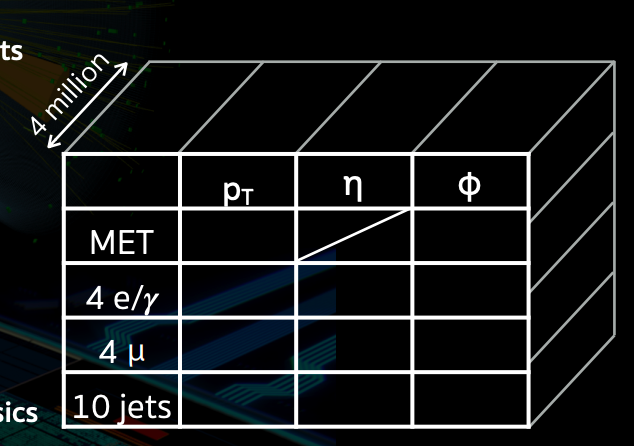

**Description from [the paper](https://www.nature.com/articles/s41597-022-01187-8)**:


*The data records are provided in Hierarchical Data Format version 5 (HDF5), and contain 3 datasets: “Particles”, “Particles_Classes” and “Particles_Names.*

*The dataset “Particles” has a shape (N, 19, 4), where N is the number of events listed for each sample in Table 1. The second index runs over the different physics objects in the events: MET, 4 electrons, 4 muons, 10 jets. Its cardinality (19) is the maximum number of objects per event. If fewer objects are present, the event is zero padded in such a way that the 1st, 5th, and 9th positions correspond to the highest-pT electron, muon, and jet, respectively.* 

*The last index (with cardinality 4) runs over the three features describing each physics object and a particle type index, which is equal to 1, 2, 3 and 4 for MET, electron, muon and jet, respectively.* 

*The information of which particle kind corresponds to which index value is contained in the “Particle_Classes” dataset, in the form of a single-entry array of strings. Zero padding is done inclusively, e.g. for zero-padded particles the particle type index is set to zero. The features are ordered as described in the “Particles_Names” dataset: pT, η, ϕ.* 

*The blackbox sample includes an additional dataset (“EvtId”) with dimension (N), containing an event ID which allows us to match each event to its ground truth (signal or background)."*


$
\space
$

---

$
\space
$


Therefore, the event data we will use is has the shape (N, 19, 3). Where the $i^{th}$ event can be accessed via 

```
EventData[i,:,:]
```
And will have shape (19,3). This event could be flattened to represent a point in 19*3 dimensional space. However, it's probably more natural to think of each event as being a collection of 19 particles living in 3D space. Note that events are zero-padded. So a non-existent particle lives at the origin in this 3D space.

In [27]:
print("Event 0 Raw data:")
print(dataDict['bkg']['Particles'][0, :, :])
print("")
print("Event 0 processed:")
print(dataDict['bkg']['Particles'][0, :, 0:3])
print("")
print("Event 0 particle labels:")
print(dataDict['bkg']['Particles'][0, :, -1])

Event 0 Raw data:
[[27.41296387  0.         -2.0499022   1.        ]
 [24.20996857  1.63350999 -0.10349621  2.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]

Event 0 pro

So background event 0 contains one MET, no electrons, one muon, and one jet.

In [28]:
print("Particles_Classes: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Classes"][i])
print("")

print("Particles_Names: ")
for i in range(4):
  print(dataDict['bkg']["Particles_Names"][i])

Particles_Classes: 
b'MET_class_1'
b'Four_Ele_class_2'
b'Four_Mu_class_3'
b'Ten_Jet_class_4'

Particles_Names: 
b'Pt'
b'Eta'
b'Phi'
b'Class'


## Plot some axes of raw data

We'll plot the MET object's PT, eta, phi for all events for all signal types.

In [29]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [30]:
# Prepare object data for plotting
objectBkg = dataDict['bkg']['Particles'][:, 0, :]

objectSigList = []
for alias in sigAliasList:
  objectSigList.append(dataDict[alias]['Particles'][:, 0, :])

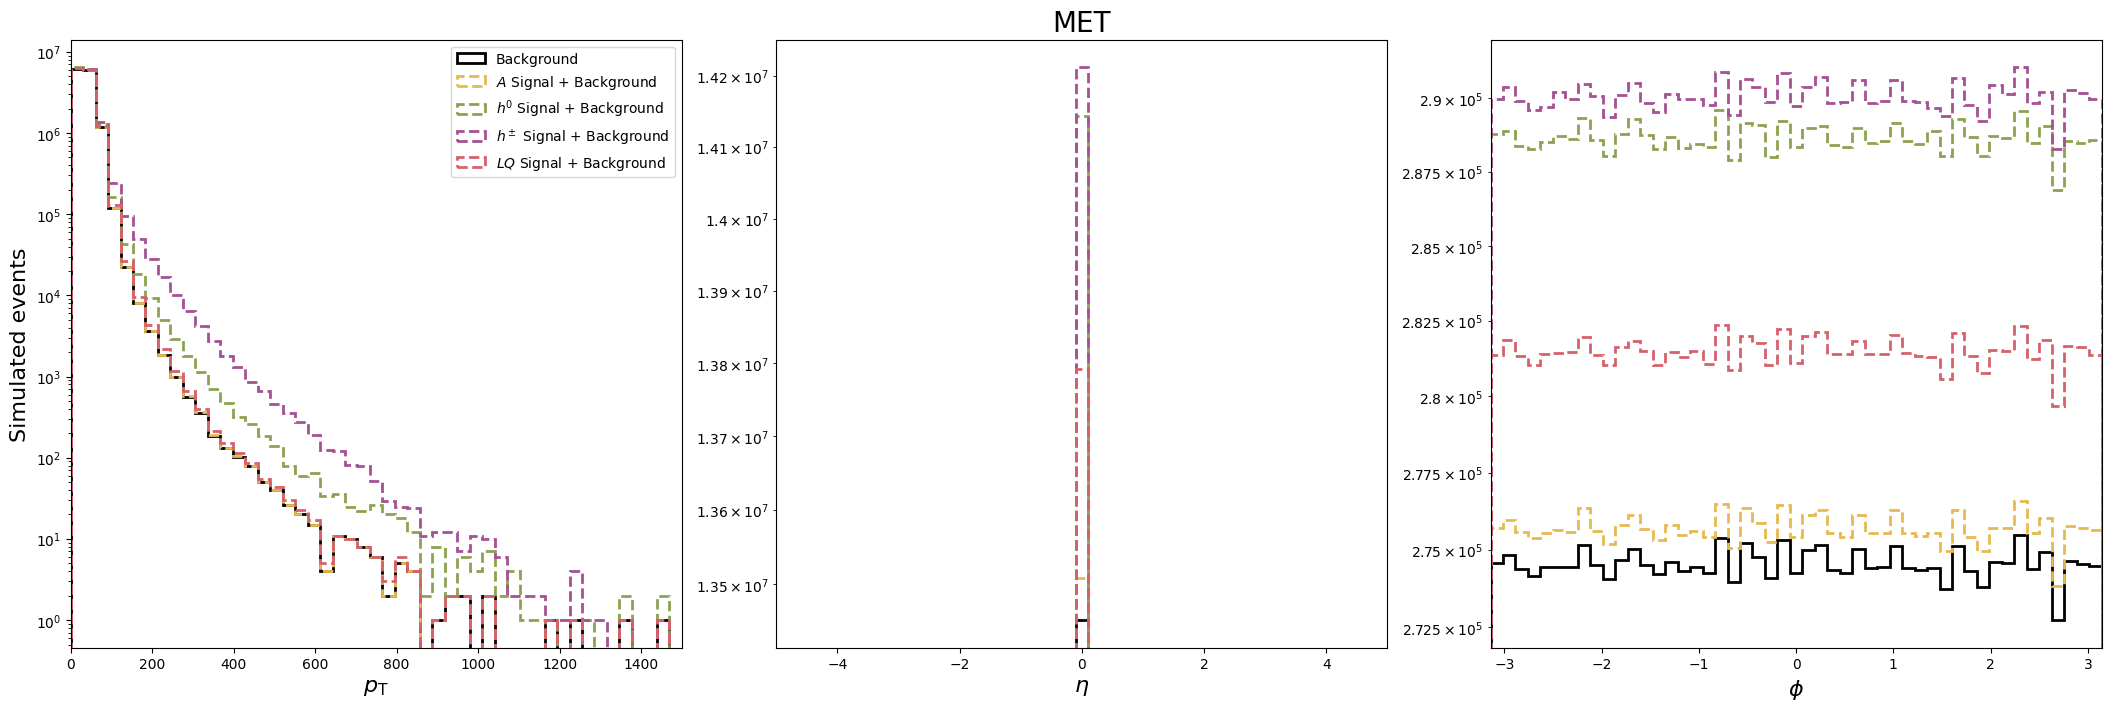

In [31]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
plotArgDict['title']              = r'MET'
plotArgDict['nBins']              = 50
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotDataHists(objectBkg, objectSigList, plotArgDict)

## Plot multiplicities of different categories for Signal vs Background

As pointed out [in this paper](https://arxiv.org/pdf/2301.04660.pdf), the multiplicity of different types of objects can potentially be a good indicator of whether that event is background or some kind of signal. There are 3 object types which can have varying multiplicity: $e$, $\mu$, and ${\rm jet}$. Here we'll plot the multiplicity (i.e. number of _) in each type for background and each signal categories.

In [32]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [33]:
# Prepare object data for plotting
objectsBkg = dataDict['bkg']['Particles'][:, :, 0] # Only need pT data

objectsSigList = []
for alias in sigAliasList:
  objectsSigList.append(dataDict[alias]['Particles'][:, :, 0]) # Only need pT data

multBkgList, multSigList = calcMultiplicityData(objectsBkg, objectsSigList)

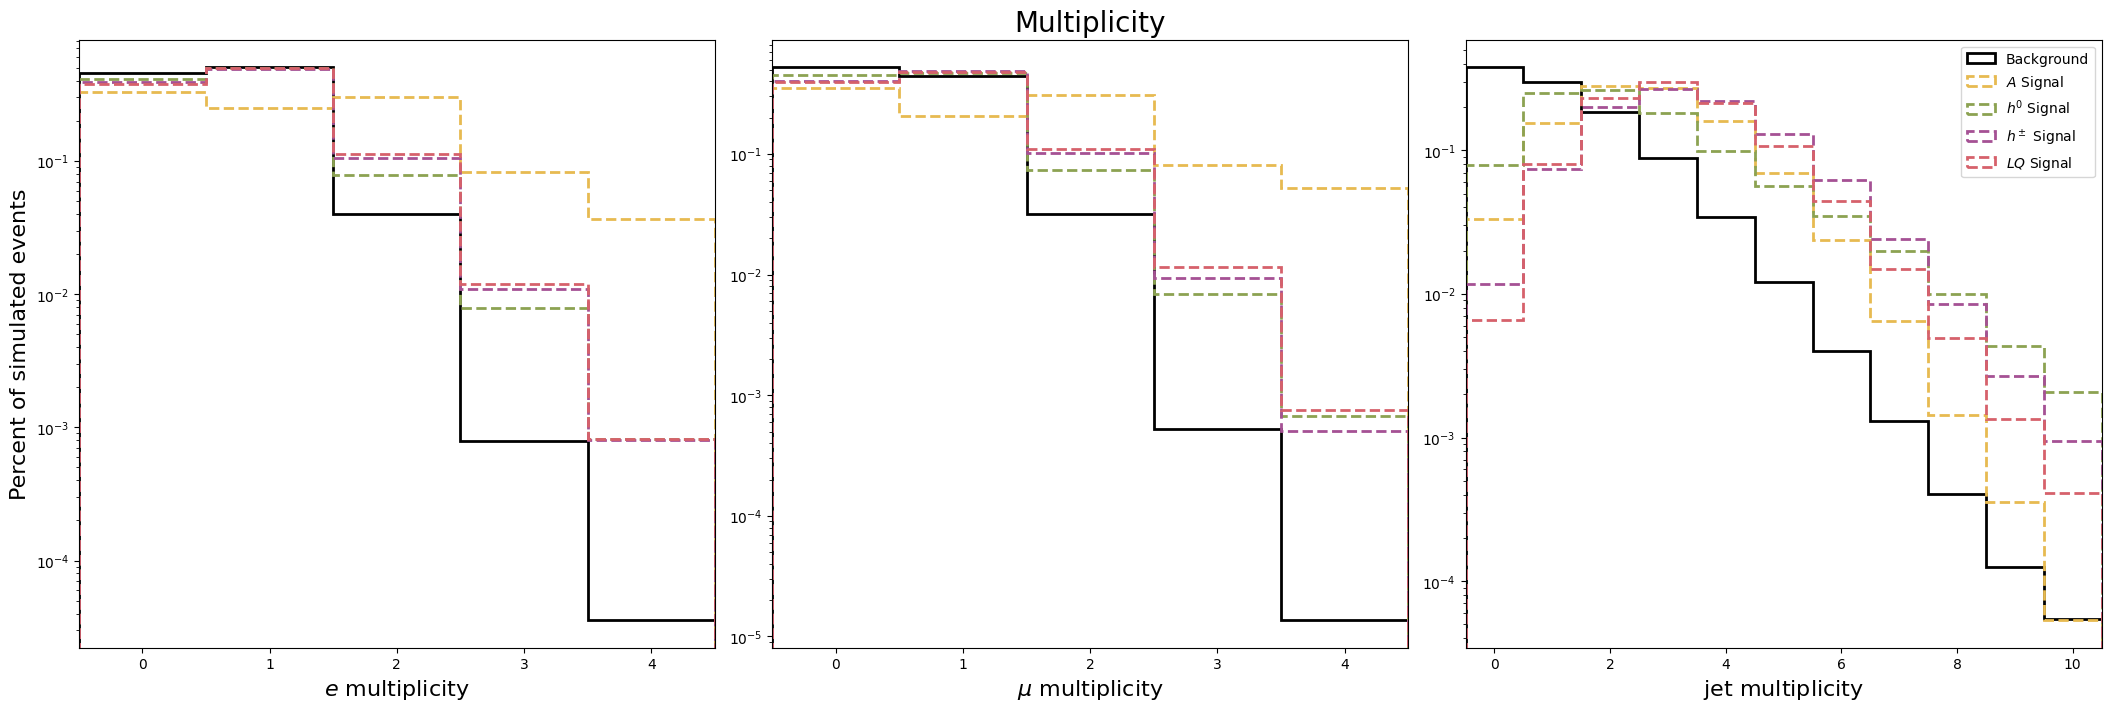

In [34]:
# Make plot
plotArgDict = {}
plotArgDict['pltDim']             = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList']      = [(-0.5, 4.5), (-0.5, 4.5), (-0.5, 10.5)]
plotArgDict['title']              = r'Multiplicity'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotMultiplicityData(multBkgList[0:3], multSigList[0:3], plotArgDict)

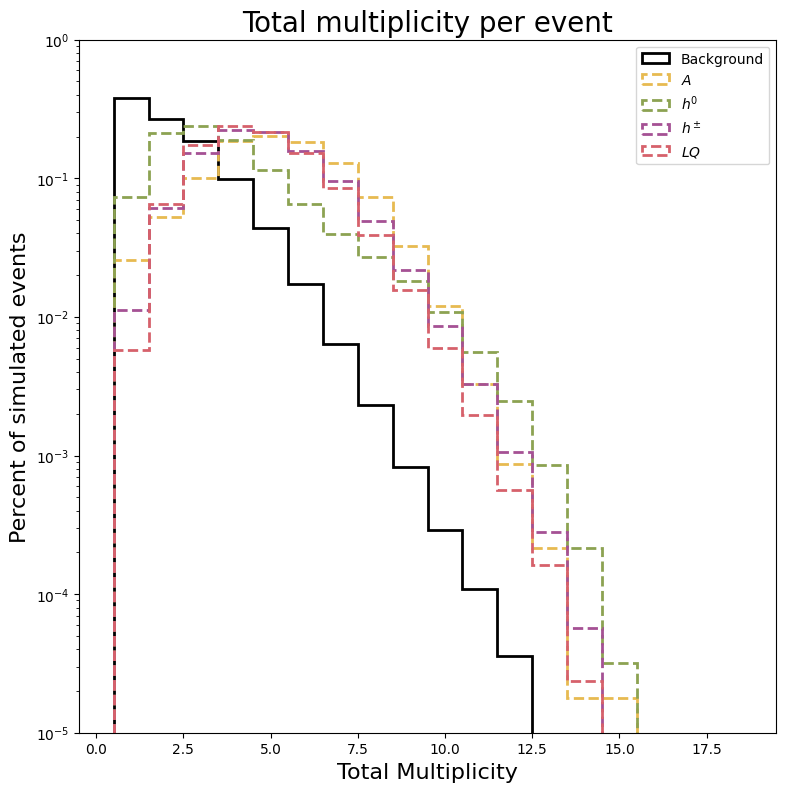

In [44]:
# Make total multiplicity plot
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (-0.5, 19.5) 
plotArgDict['xLabel']             = r'Total Multiplicity'
plotArgDict['yAxisLims']          = (1e-5, 1)
plotArgDict['yLabel']             = 'Percent of simulated events'
plotArgDict['title']              = r'Total multiplicity per event'
plotArgDict['nBins']              = 21
plotArgDict['logY']               = True
plotArgDict['density']            = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(multBkgList[3], multSigList[3], plotArgDict)

## We can also plot the total $p_T$ in an event for Signal vs Background

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

In [ ]:
# Prepare object data for plotting
totPtBkg = np.sum(dataDict['bkg']['Particles'][:, :, 0], axis=1)

totPtSigList = []
for alias in sigAliasList:
  totPtSigList.append(np.sum(dataDict[alias]['Particles'][:, :, 0], axis=1))

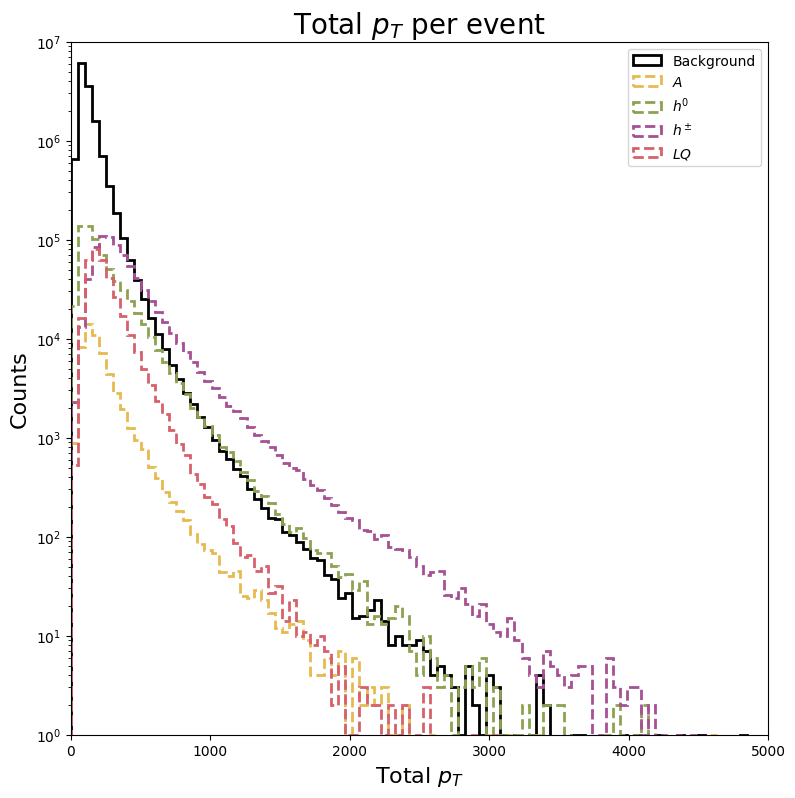

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 5000) 
plotArgDict['xLabel']             = r'Total $p_T$'
plotArgDict['yAxisLims']          = (1, 1e7)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'Total $p_T$ per event'
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(totPtBkg, totPtSigList, plotArgDict)

# Overview of main idea

Each event is a set of 19 objects (MET, 4 $e/\gamma$, 4 $\mu$, 10 jets) with some properties ($p_{\rm T}, \eta, \phi$). Collectively, this defines an *event*. When an object is not present in an event, its $(p_{\rm T}, \eta, \phi) = (0,0,0)$. Thus an event has the shape $(1, 19, 3)$.

$\color{magenta}{\text{For now, we will visualize each event as comprising 19 point-objects (ignoring their type) located in 3D space.}}$

We can then calculate the OT distance between two events 

$$
\text{OT(event[i], event[j])}.
$$ 

Each event can be viewed as being drawn from a high-dimensional probability distribution defining that event's *class* (i.e. Standard Model background or new physics signal). 

The idea is that the OT distance will cluster events from the same class together, and separate events from different classes. In this way we can use the OT distance as an anomaly score.

$\color{magenta}{\text{We assume that our ground space OT cost function is the typical $| \cdot - \cdot|^2$ calculated in 3D ($p_{\rm T}, \eta, \phi$) space.}}$

##### ***Concrete example:***

Consider 3 events: A, B, and C. And assume that events A and B belong to the Standard Model (SM) class while event C belongs to the new physics class. Then the following should be true:

$$
\text{OT(eventA, eventB)} \approx 0 \\
\text{OT(eventA, eventC)} \approx \text{OT(eventB, eventC)} ≫ 0
$$

In other words, events from the same class will ideally have inter-OT distances clustered around $\approx$ 0. While events from different classes will have inter-OT distances clustered around some non-zero value.

Since the OT distance is reflexive we can visualize this as an upper triangular matrix (see the schematic description below)

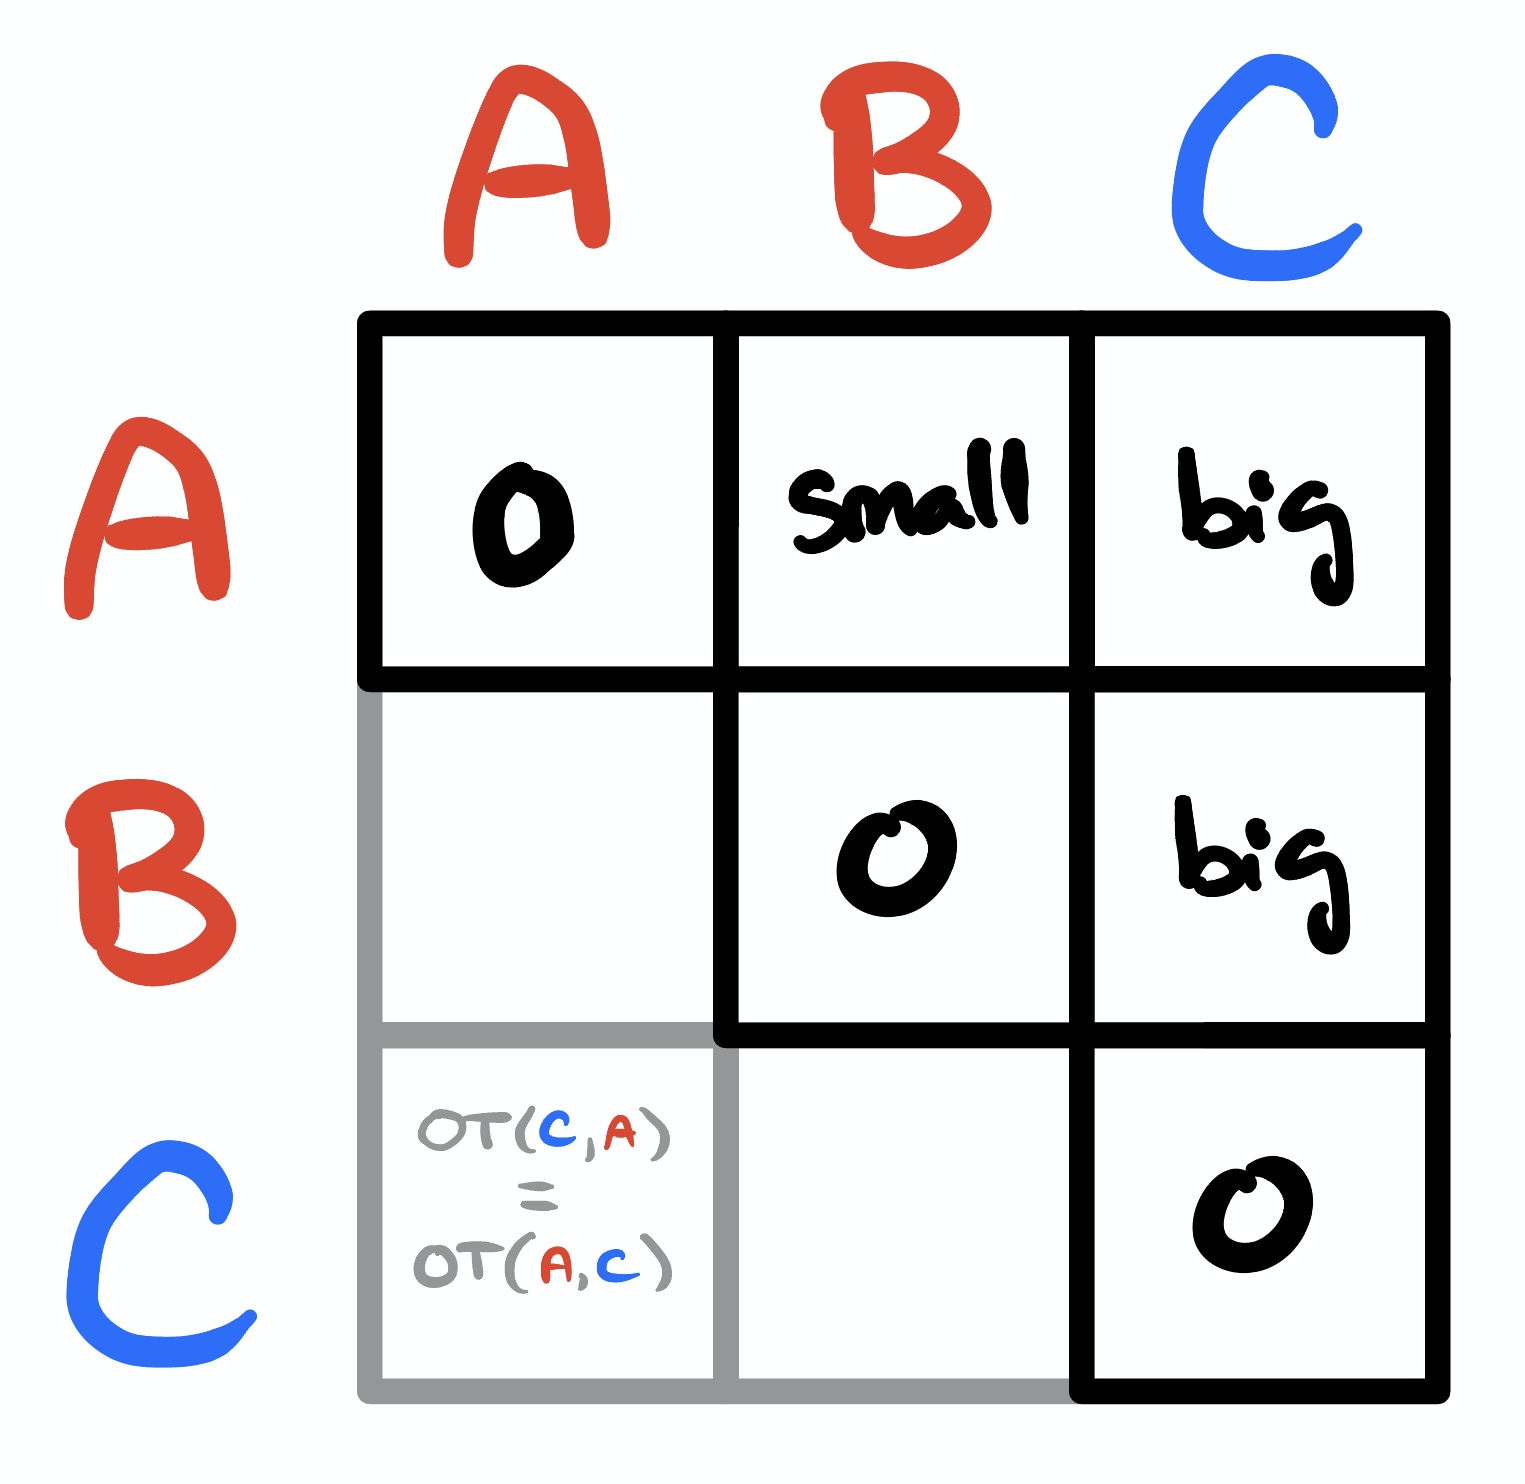

##### **Outline of the idea**

*Step 1:*

We will begin by collecting two sample sets of background events and one sample set from each signal event category: bkgEvents1, bkgEvents2, [sigEvents, ...]. 

$\color{magenta}{\text{We assume all of the sample sets have the same number of samples, nEvents.}}$

```
# Pseudo code
randomIntegerArray1
randomIntegerArray2
bkgEvents1 = dataDict['bkg']['Particles'][randomIntegerArray1, :, 0:3]
bkgEvents2 = dataDict['bkg']['Particles'][randomIntegerArray2, :, 0:3]

sigEventsList = []
for alias in sigAliasList:
  randomIntegerArray
  sigEvents = dataDict[alias]['Particles'][randomIntegerArray, :, 0:3]
  sigEventsList.append(sigEvents)
```

*Step 2:*

We will then calculate the background-to-background OT distance

```
# Pseudo code
scoreBkg = []
dummyArr = np.arange(nEvents)
for (i,j) in itertools.product(dummyArr, dummyArr):
  scoreBkg.append( OT(bkgEvents1[i], bkgEvents2[j]))
```

Thus, scoreBkg will be an array of nEvents**2 numbers.

*Step 3:*

Using bkgEvents1 as a reference sample, we'll then calculate the background-to-signal OT distance for each signal type

```
# Pseudo code
scoreSigList = []
for k in range(len(sigAliasList)):
  alias = sigAliasList[k]
  sigEvents = sigEventsList[k]

  scoreSig = []
  dummyArr = np.arange(nEvents)
  for (i,j) in itertools.product(dummyArr, dummyArr):
    scoreSig.append( OT(bkgEvents1[i], sigEvents[j]))
  scoreSigList.append(scoreSig)
```
Thus, each scoreSig will be an array of nEvents**2 numbers.

*Step 4:*

We can then plot scoreBkg against each type of scoreSig and calculate the corresponding ROC curve and AUC values.


##### **Some quick notes:**

* Another possibility is to instead to the distribution-to-distribution OT distance calculation rather than the event-to-event.

# 2-Wasserstein distance anomaly score, first naive attempt

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias 
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

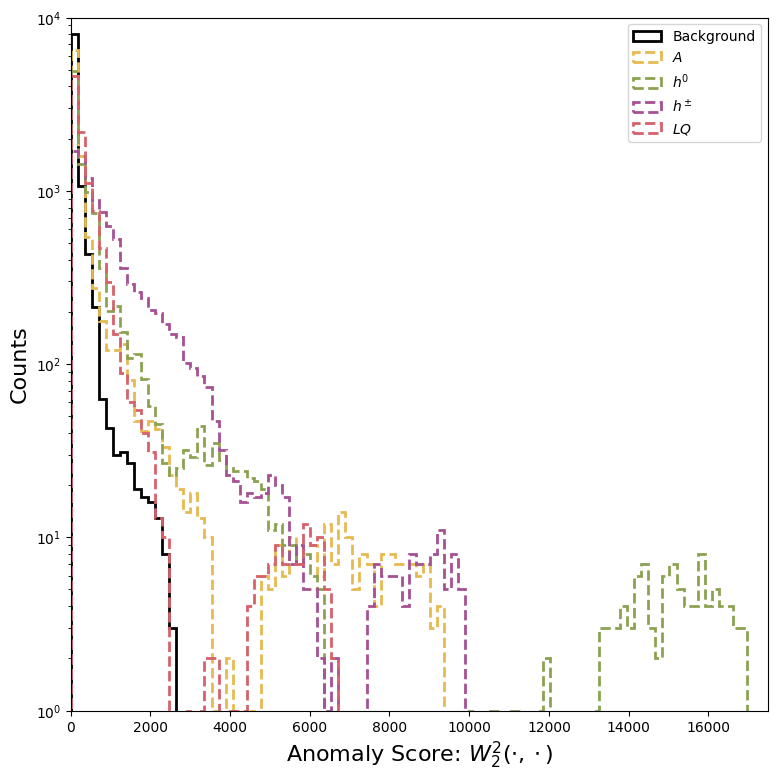

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 17500) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

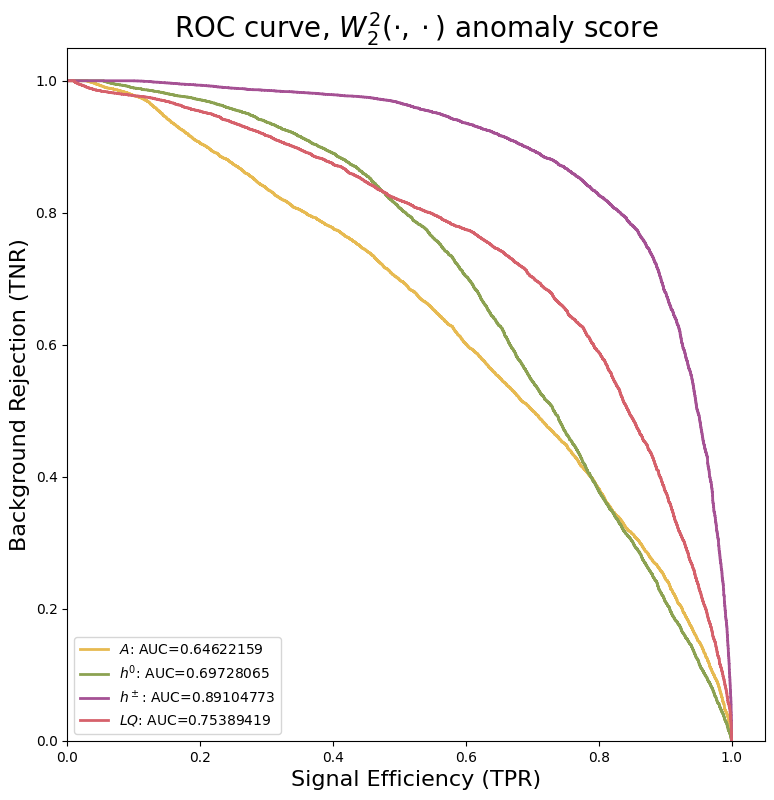

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

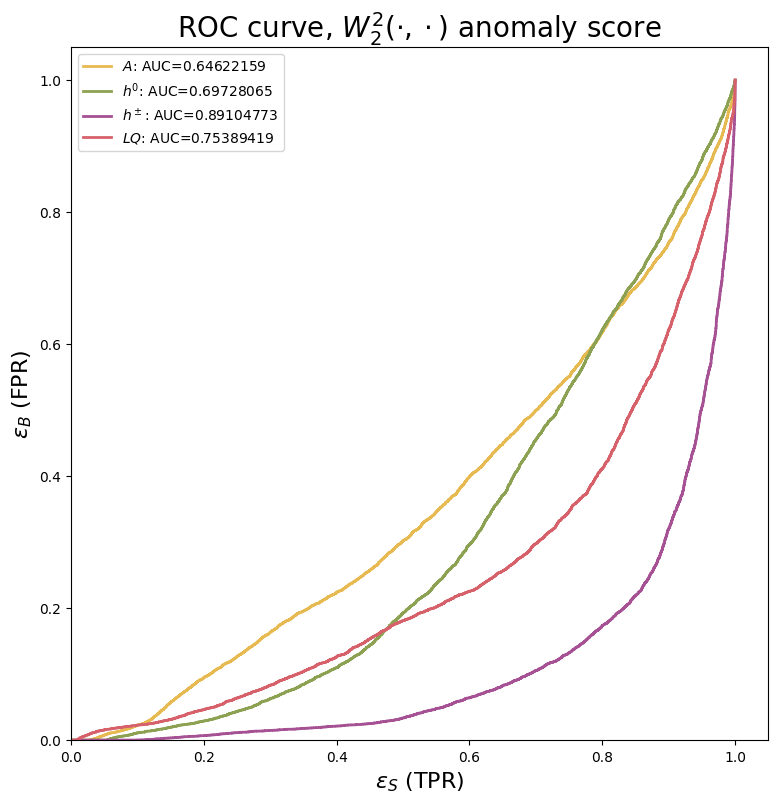

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

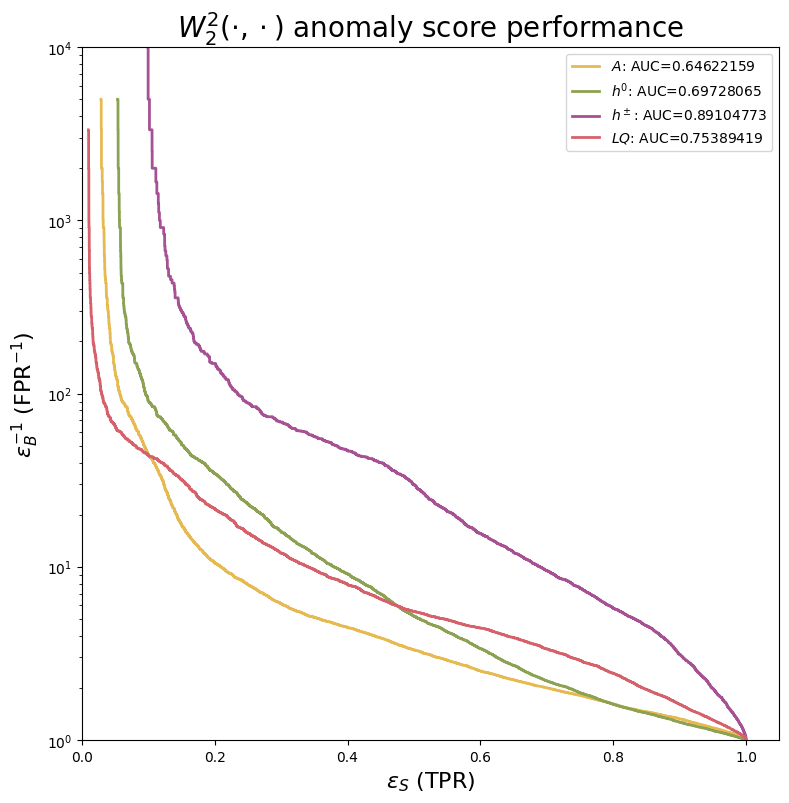

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 1e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

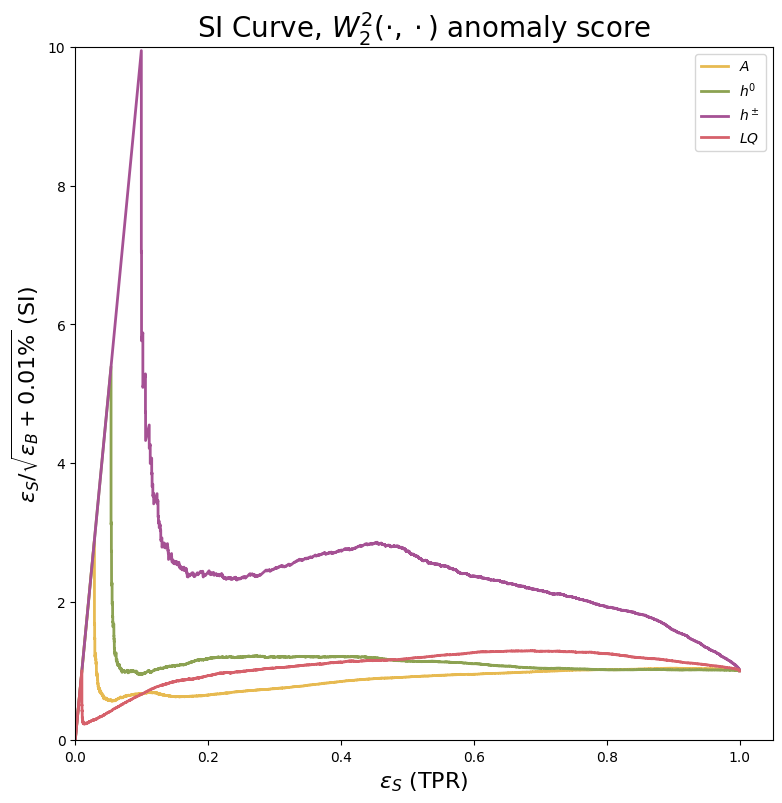

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 10)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0001 0.0995 0.0995 0.0998]
[0.         0.01       9.95       7.03571247 7.05692568]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.64622159
     $h^0$: 0.69728065
   $h^\pm$: 0.89104773
      $LQ$: 0.75389419


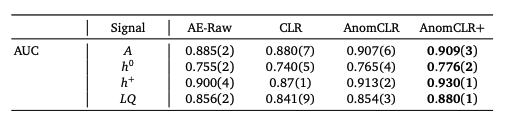

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2050, 1018, 276, 1302]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 6.138735420503377 (TPR=0.3002)
     $h^0$: 16.0 (TPR=0.3)
   $h^\pm$: 68.9655172413793 (TPR=0.2982)
      $LQ$: 12.01923076923077 (TPR=0.2994)


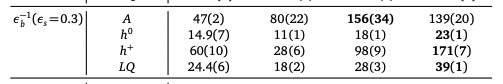

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.7435614843317231 (TPR=0.3002)
     $h^0$: 1.1990411504661471 (TPR=0.3)
   $h^\pm$: 2.4679207598122614 (TPR=0.2982)
      $LQ$: 1.0373595162268299 (TPR=0.2994)


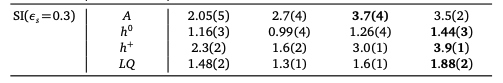

#MSOT: 2-Wasserstein distance anomaly score, individual species (${\rm MET}$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias 
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

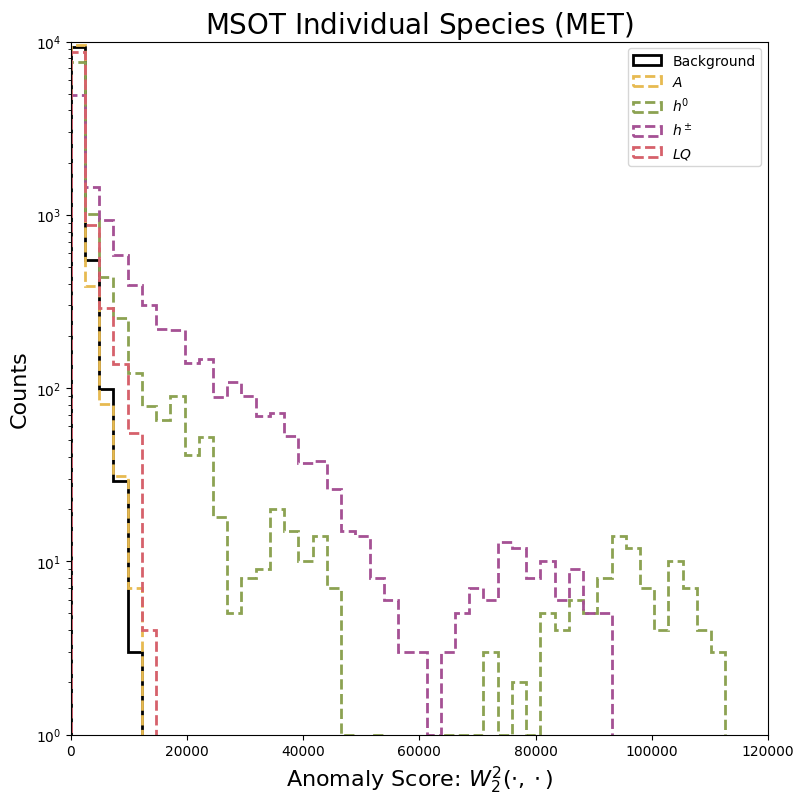

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 120000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species (${\rm MET}$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

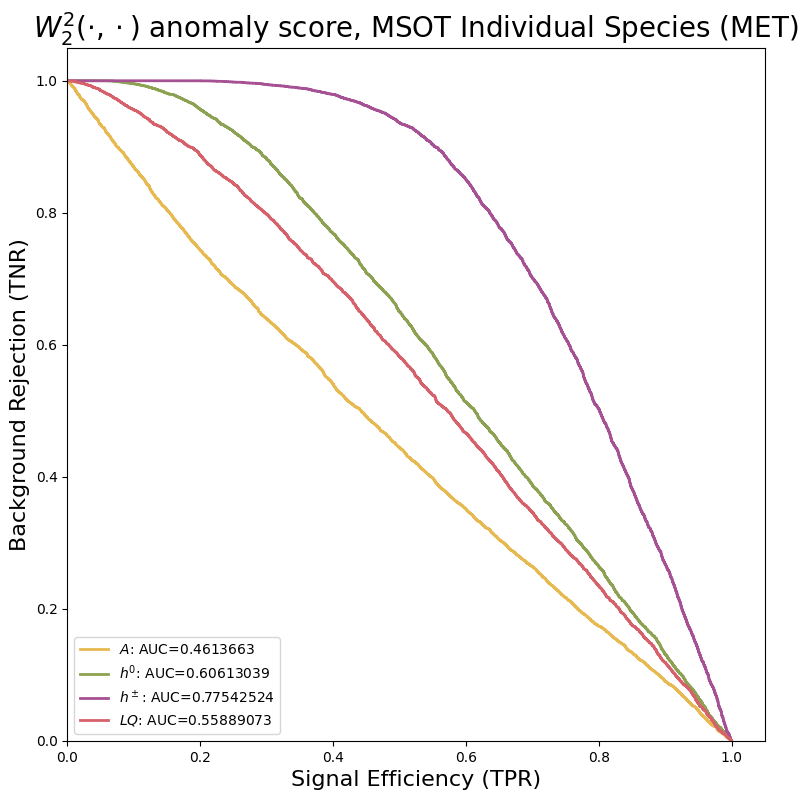

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

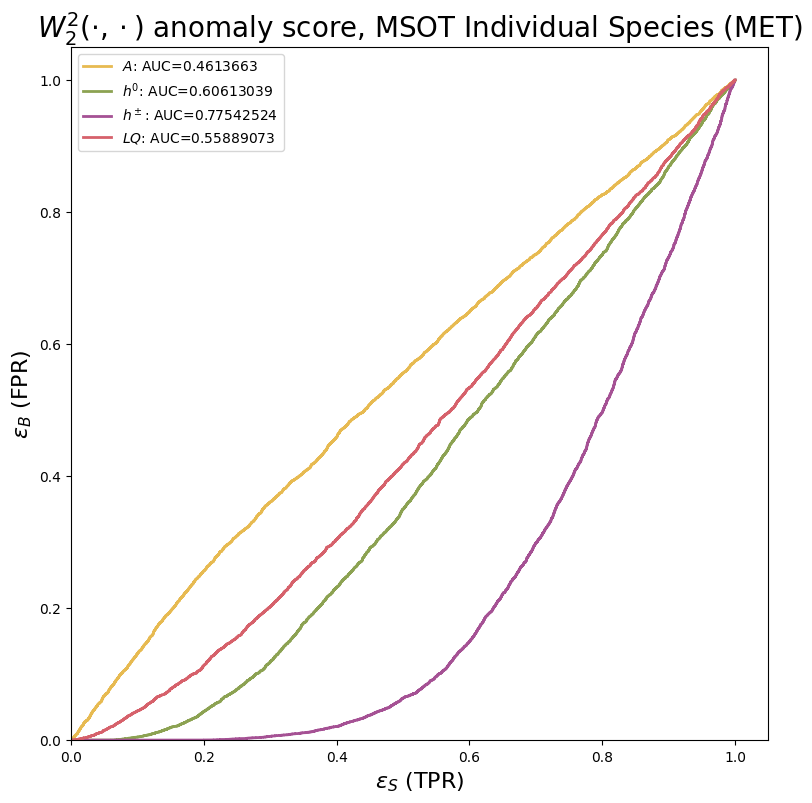

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

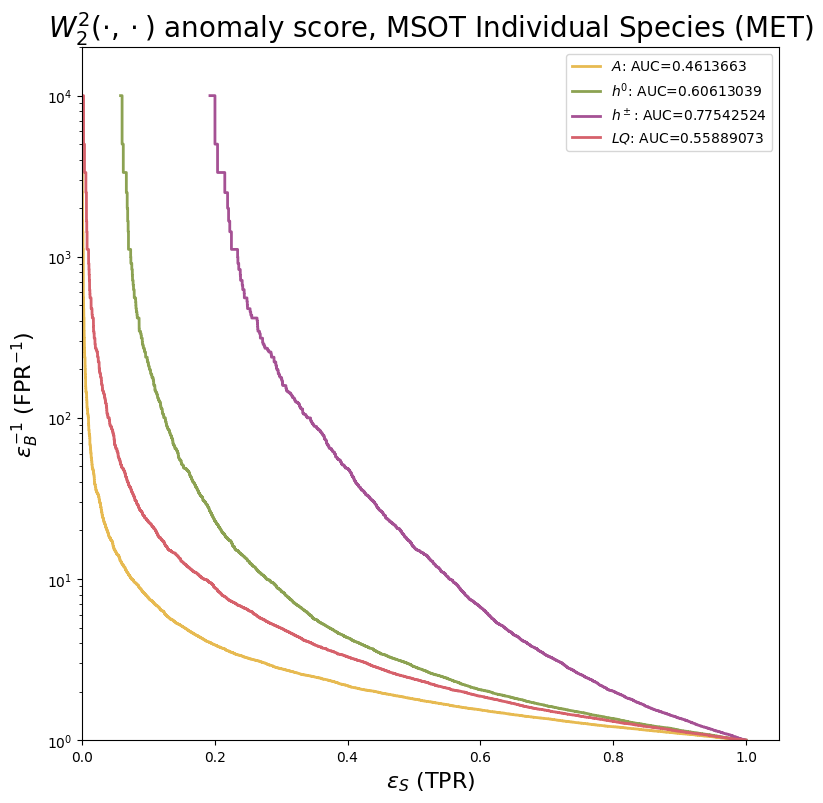

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

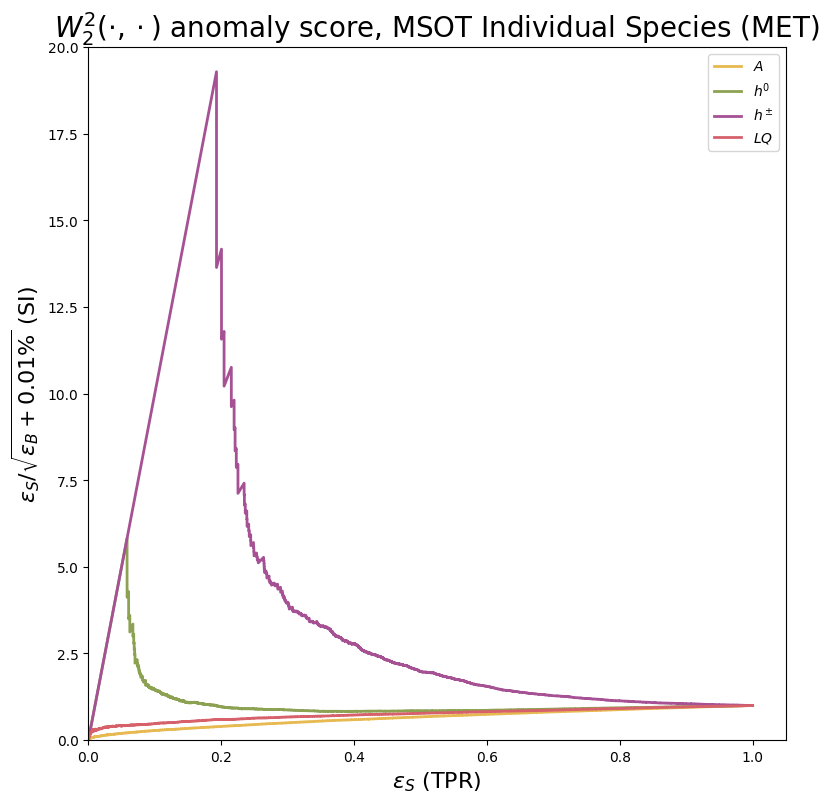

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 20)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.929e-01 1.929e-01 2.004e-01]
[0.00000000e+00 1.00000000e-02 1.92900000e+01 1.36400898e+01
 1.41704199e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.4613663
     $h^0$: 0.60613039
   $h^\pm$: 0.77542524
      $LQ$: 0.55889073


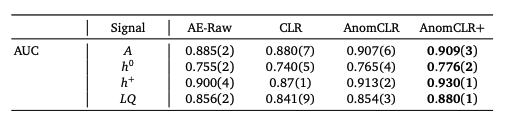

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[3258, 1442, 104, 2358]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 2.7731558513588466 (TPR=0.2999)
     $h^0$: 8.467400508044031 (TPR=0.3)
   $h^\pm$: 178.57142857142858 (TPR=0.3004)
      $LQ$: 4.9504950495049505 (TPR=0.2998)


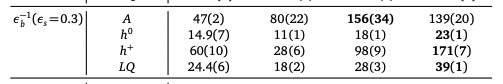

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.4993480917886255 (TPR=0.2999)
     $h^0$: 0.8725945907447251 (TPR=0.3)
   $h^\pm$: 3.9788952006233917 (TPR=0.3004)
      $LQ$: 0.6668811958968935 (TPR=0.2998)


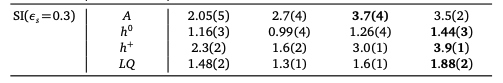

#MSOT: 2-Wasserstein distance anomaly score, individual species ($e$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 1:5, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 1:5, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 1:5, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias 
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

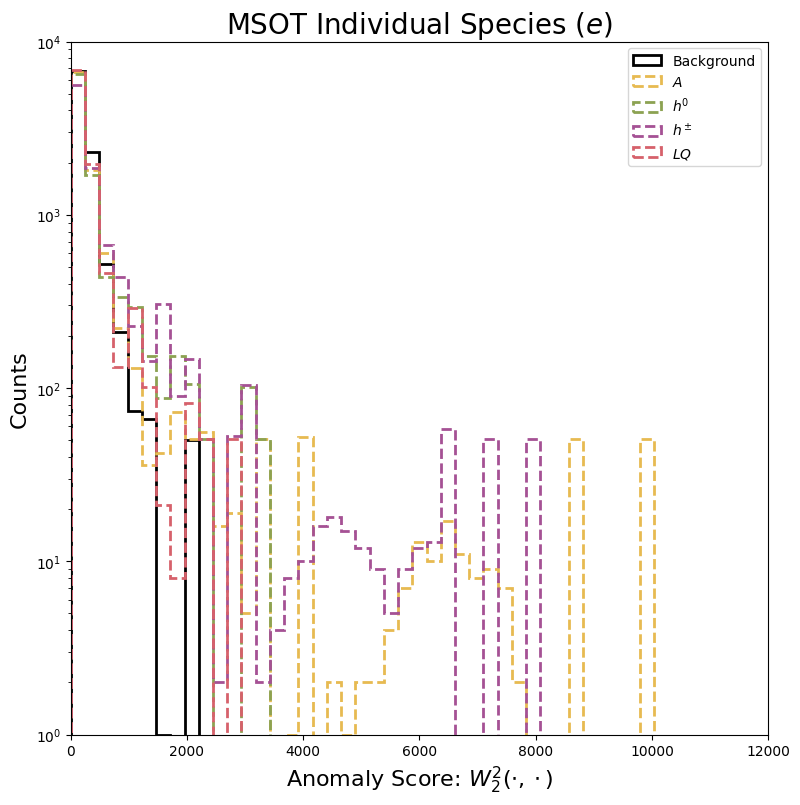

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 12000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species ($e$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

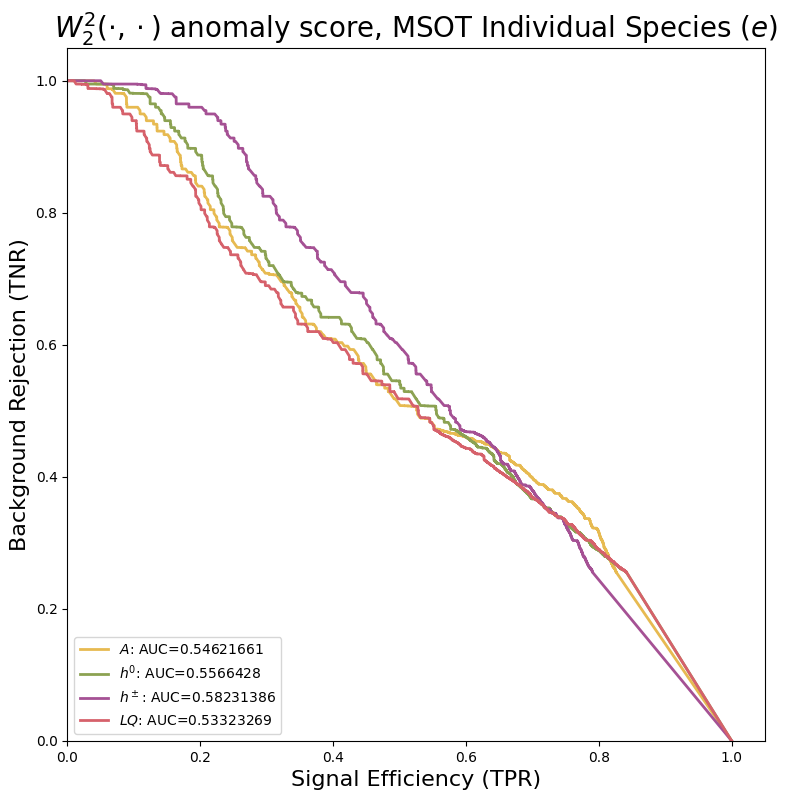

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

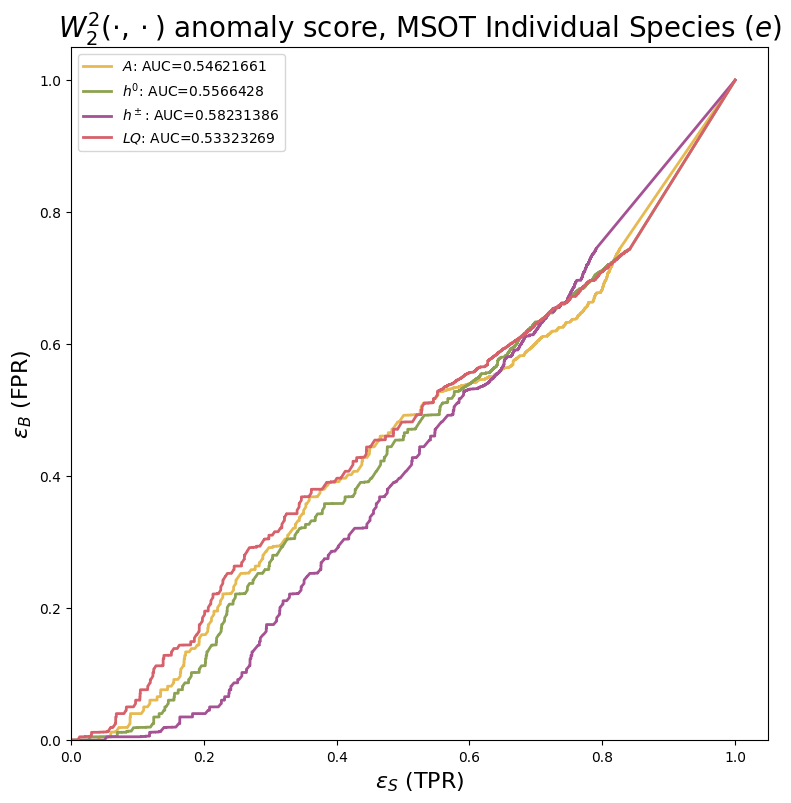

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

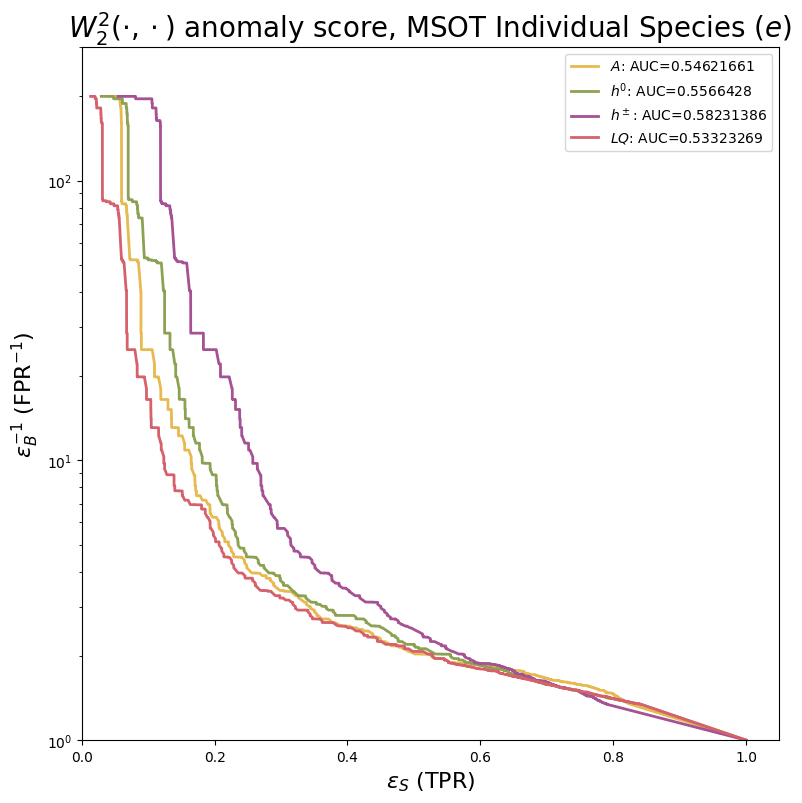

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

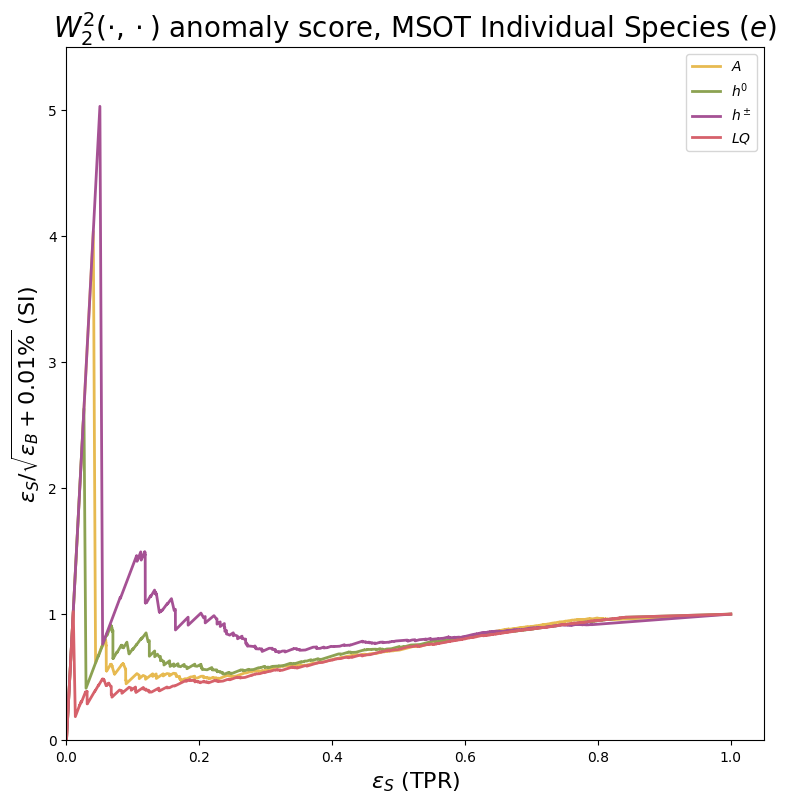

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 5.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0051 0.0153 0.0294 0.0345]
[0.   0.51 1.53 2.94 3.45]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.54621661
     $h^0$: 0.5566428
   $h^\pm$: 0.58231386
      $LQ$: 0.53323269


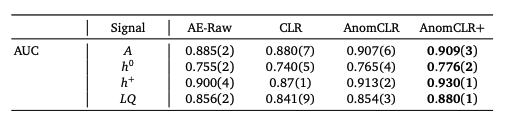

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[339, 319, 244, 350]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.4281796366129584 (TPR=0.2981)
     $h^0$: 3.7147102526002973 (TPR=0.2996)
   $h^\pm$: 5.711022272986864 (TPR=0.2999)
      $LQ$: 3.2754667540124465 (TPR=0.2981)


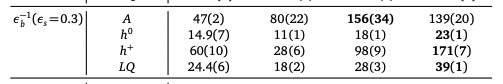

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.55184782125186 (TPR=0.2981)
     $h^0$: 0.5773293444189536 (TPR=0.2996)
   $h^\pm$: 0.7164888146099611 (TPR=0.2999)
      $LQ$: 0.5394205154319709 (TPR=0.2981)


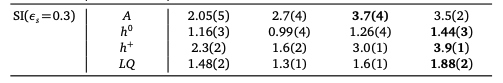

#MSOT: 2-Wasserstein distance anomaly score, individual species ($\mu$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 5:9, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 5:9, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 5:9, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias 
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

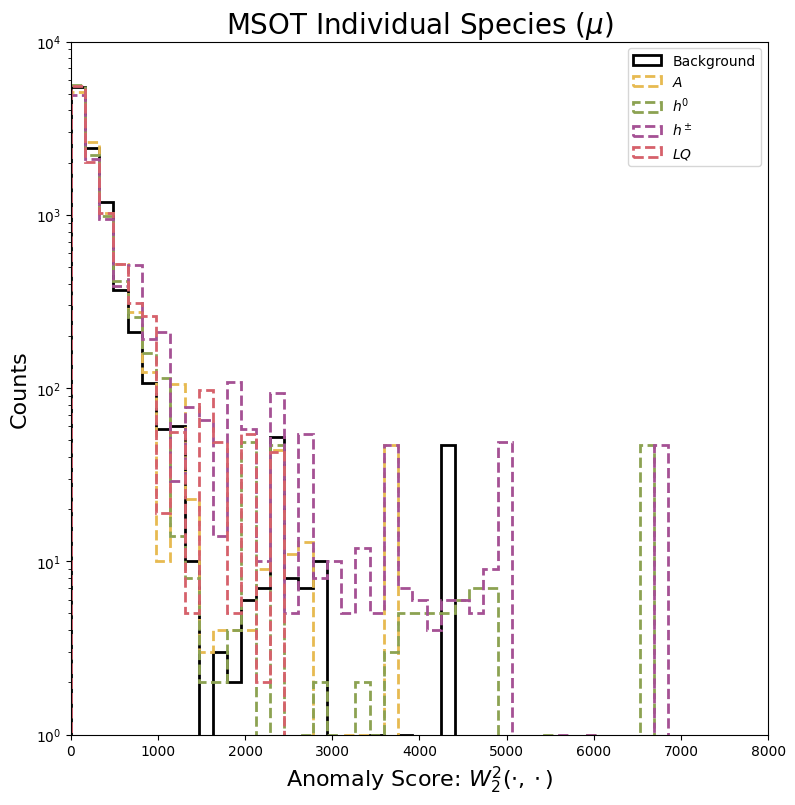

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 8000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species ($\mu$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

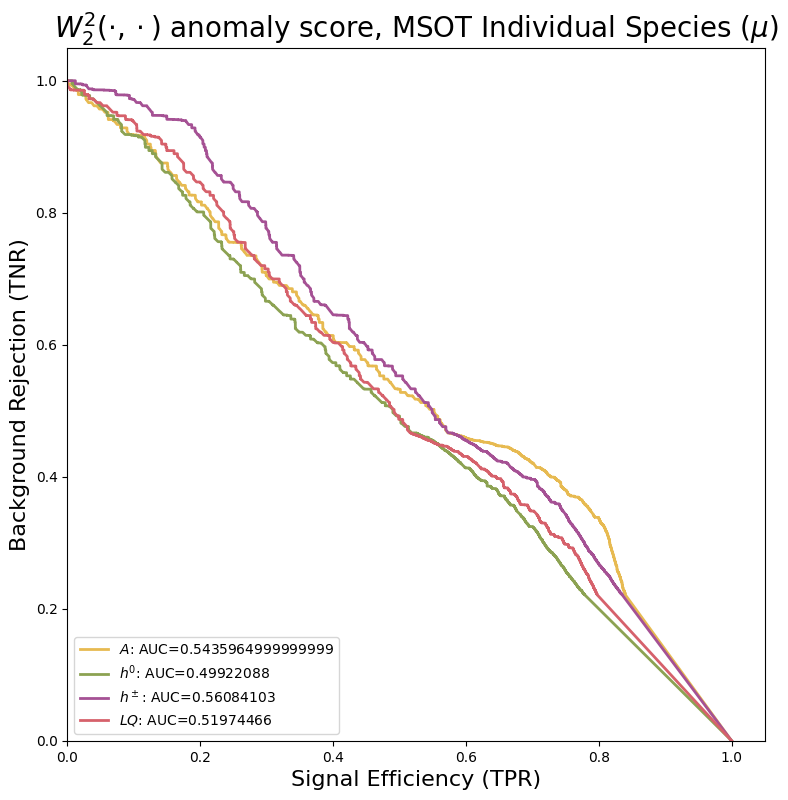

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

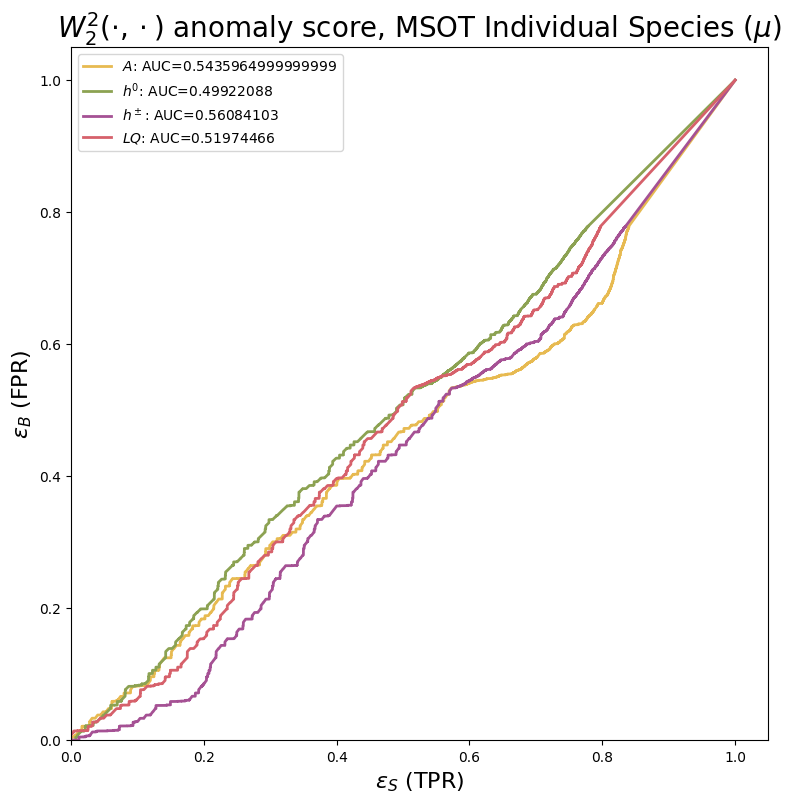

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

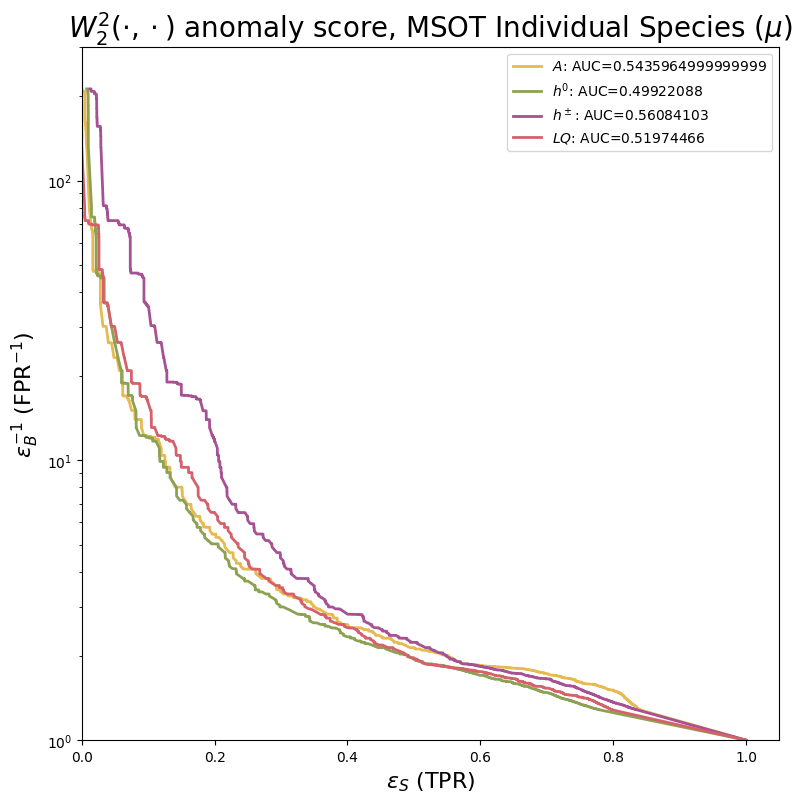

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

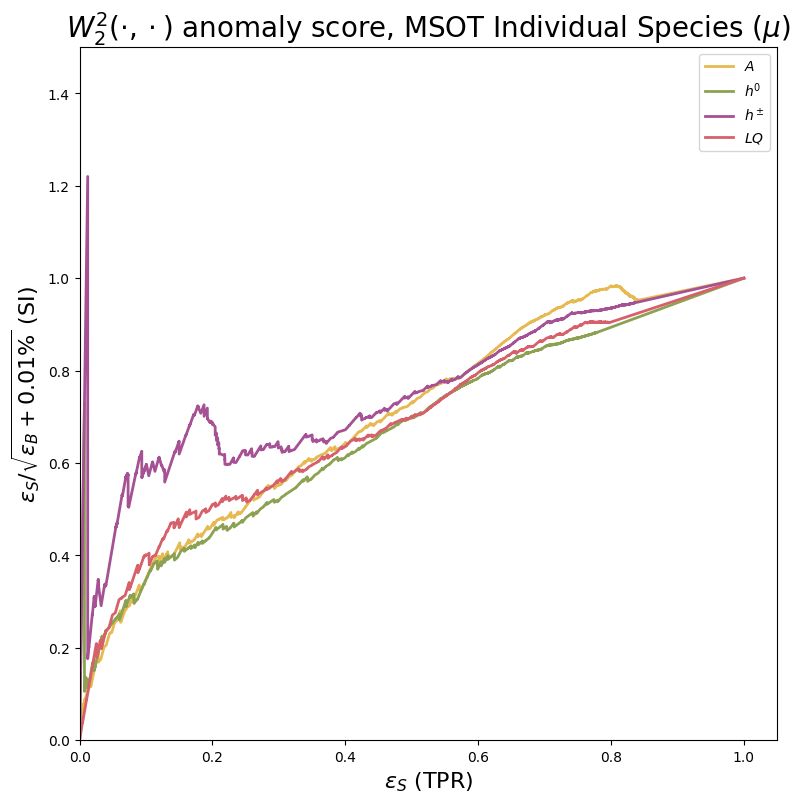

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0047 0.0051 0.0098 0.0122]
[0.   0.47 0.51 0.98 1.22]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5435964999999999
     $h^0$: 0.49922088
   $h^\pm$: 0.56084103
      $LQ$: 0.51974466


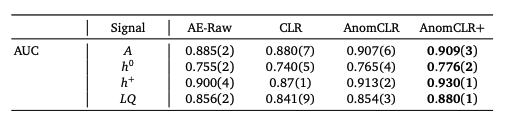

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[484, 446, 447, 475]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.3863867253640363 (TPR=0.3)
     $h^0$: 3.035822707953855 (TPR=0.2982)
   $h^\pm$: 4.47227191413238 (TPR=0.2996)
      $LQ$: 3.506311360448808 (TPR=0.2977)


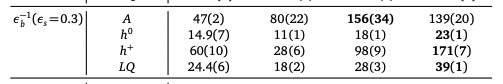

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5519706800961892 (TPR=0.3)
     $h^0$: 0.5194932747581706 (TPR=0.2982)
   $h^\pm$: 0.6334448607383971 (TPR=0.2996)
      $LQ$: 0.5573499273034173 (TPR=0.2977)


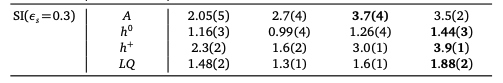

#MSOT: 2-Wasserstein distance anomaly score, individual species (${\rm jet}$)

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 9:, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 9:, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 9:, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias 
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

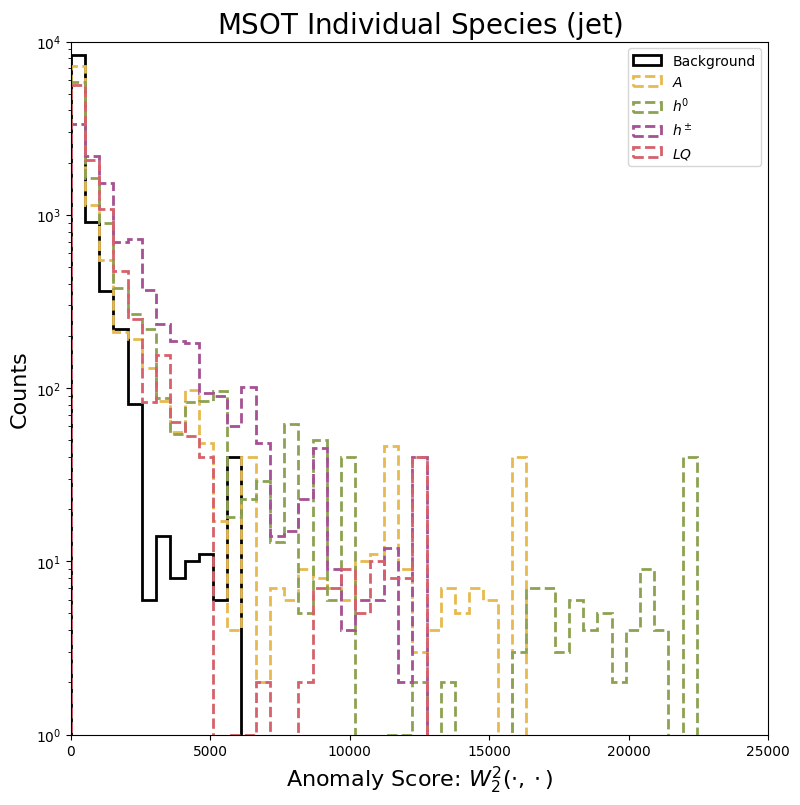

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 25000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species (${\rm jet}$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

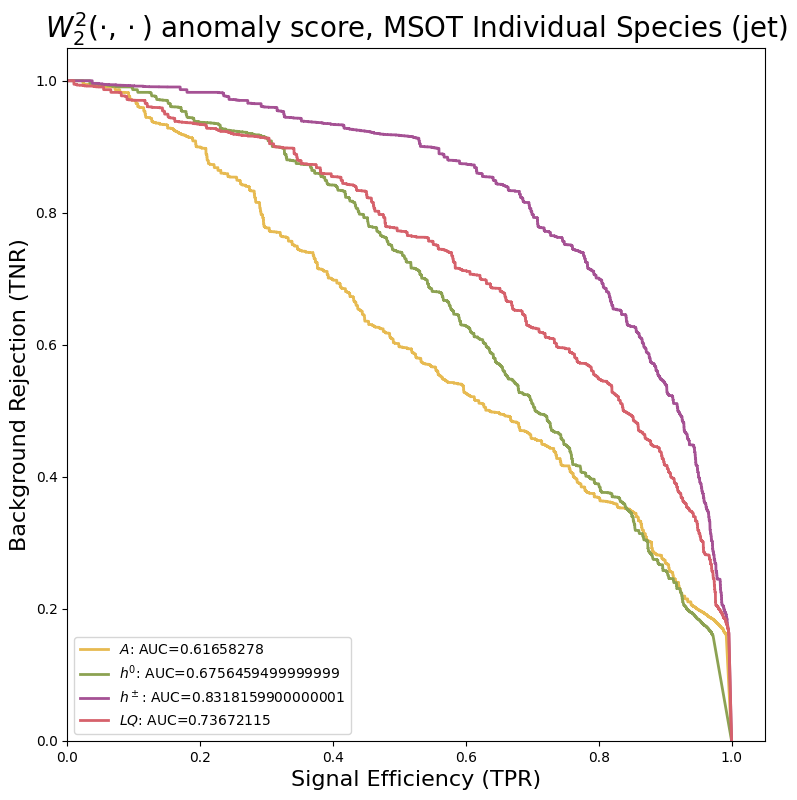

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

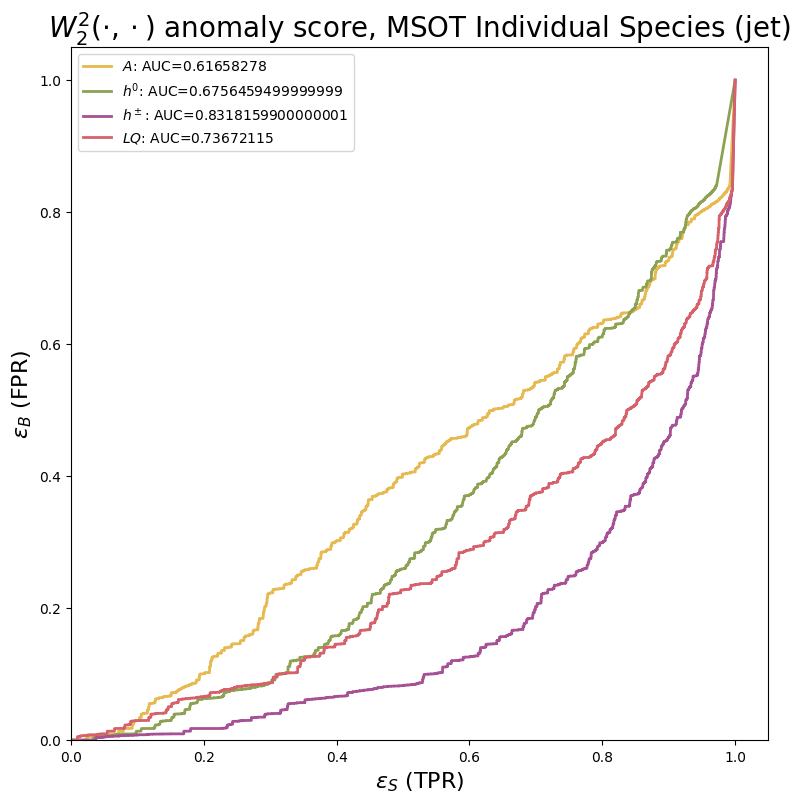

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

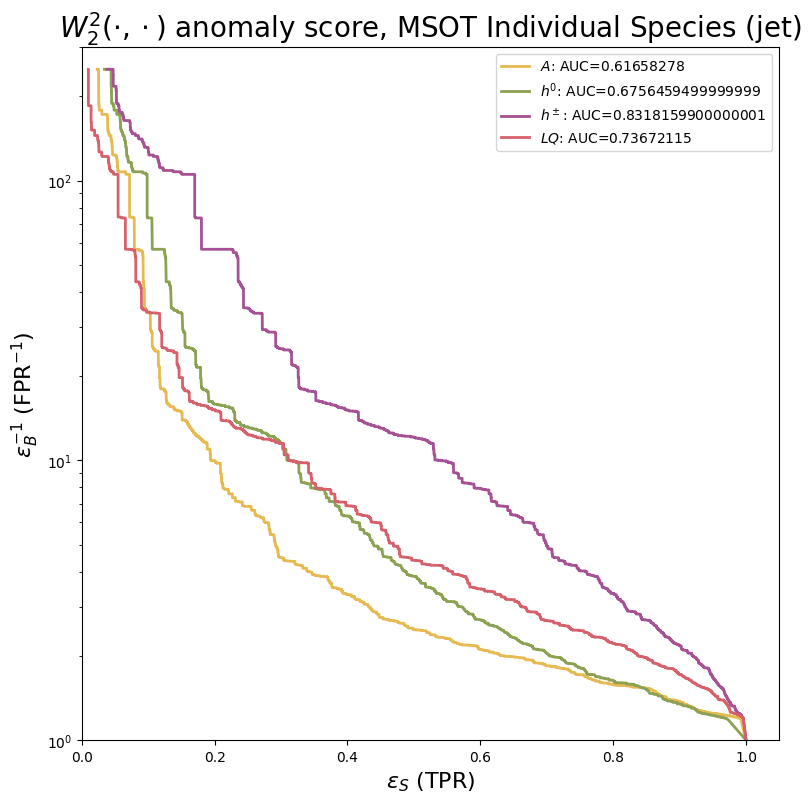

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

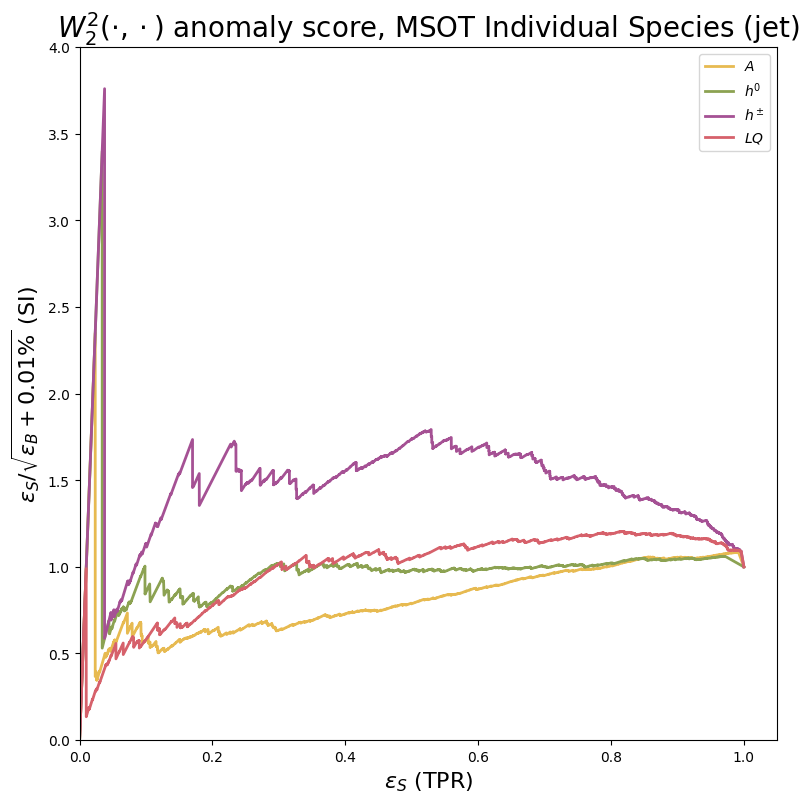

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 4)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.004  0.0081 0.0121 0.0176]
[0.   0.4  0.81 1.21 1.76]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.61658278
     $h^0$: 0.6756459499999999
   $h^\pm$: 0.8318159900000001
      $LQ$: 0.73672115


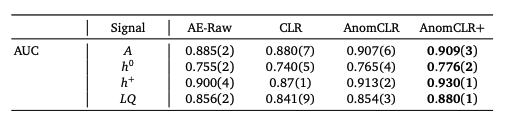

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[978, 641, 285, 653]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 4.482294935006723 (TPR=0.2996)
     $h^0$: 11.52073732718894 (TPR=0.3002)
   $h^\pm$: 25.06265664160401 (TPR=0.2983)
      $LQ$: 11.49425287356322 (TPR=0.2987)


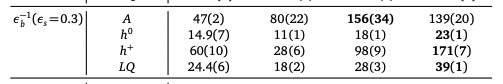

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6341539674876179 (TPR=0.2996)
     $h^0$: 1.0183587508606904 (TPR=0.3002)
   $h^\pm$: 1.4915 (TPR=0.2983)
      $LQ$: 1.0121063393983298 (TPR=0.2987)


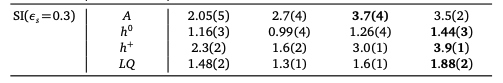

#MSOT: 2-Wasserstein distance anomaly score, individual species weighted combination (wList = [1., 1., 1., 1.])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 1., 1., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

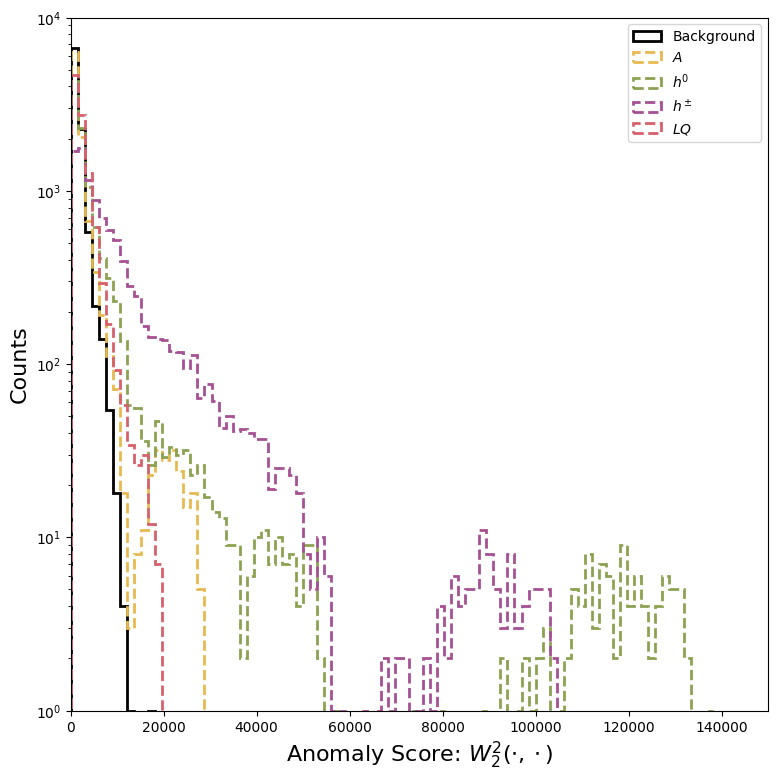

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 150000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

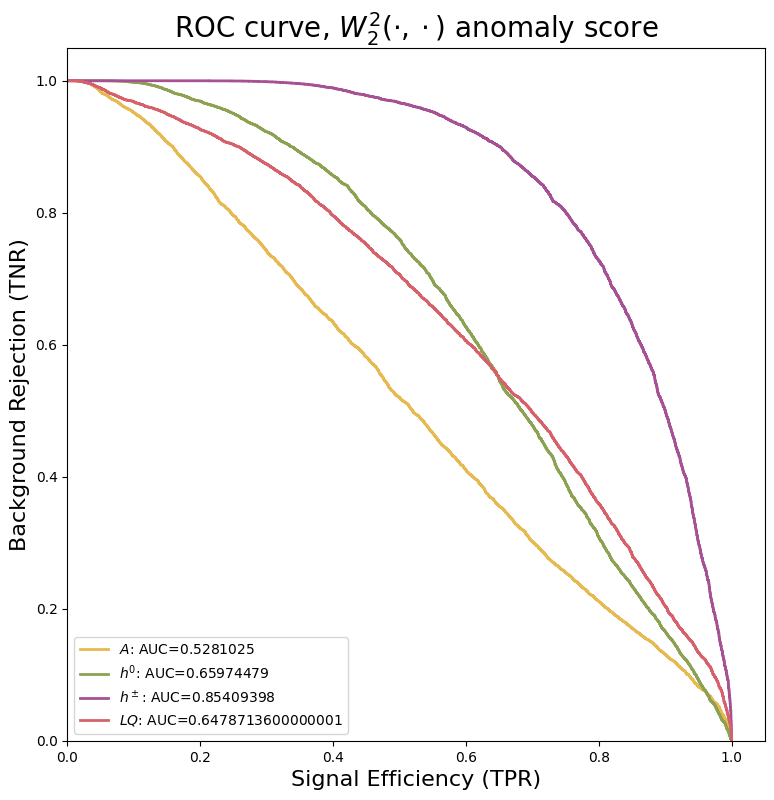

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

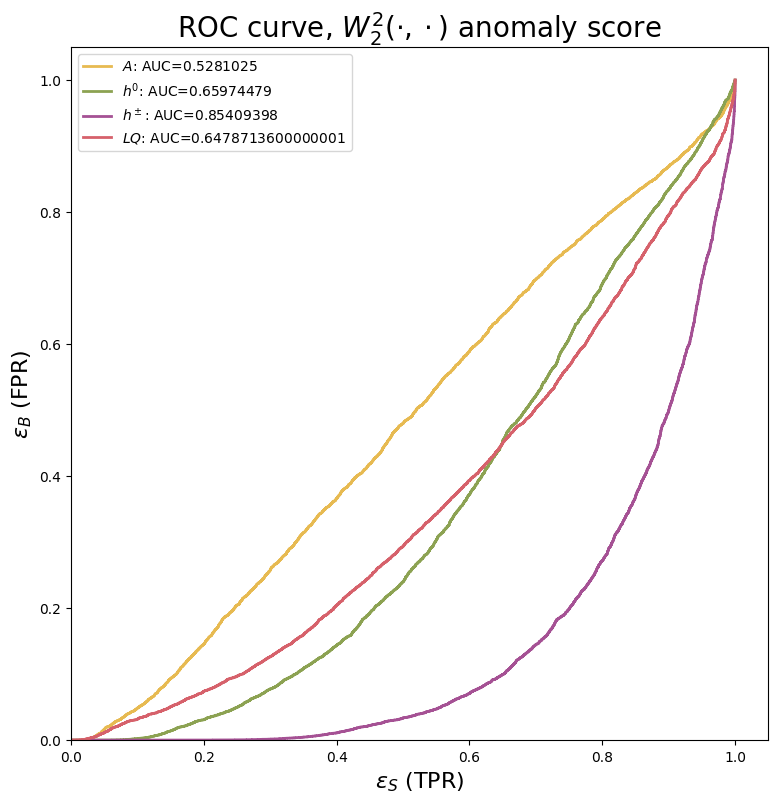

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

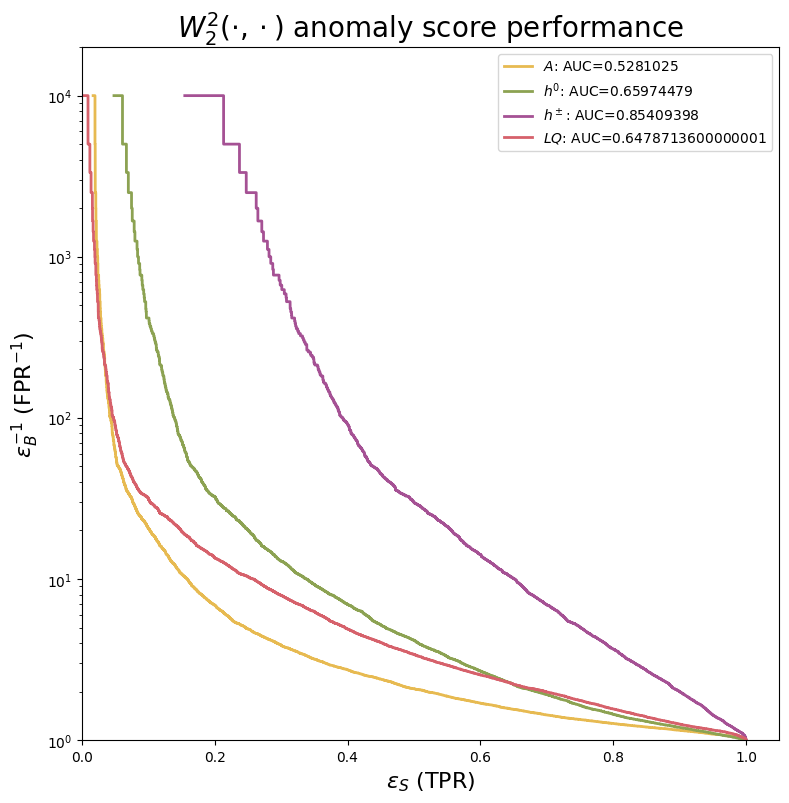

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

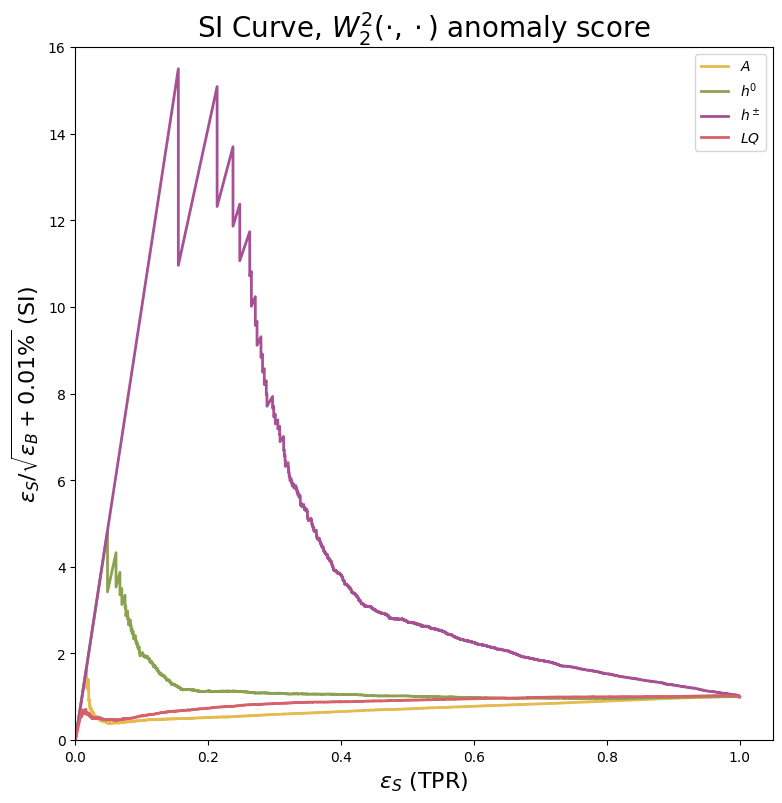

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 16)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.550e-01 1.550e-01 2.134e-01]
[0.00000000e+00 1.00000000e-02 1.55000000e+01 1.09601551e+01
 1.50896587e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5281025
     $h^0$: 0.65974479
   $h^\pm$: 0.85409398
      $LQ$: 0.6478713600000001


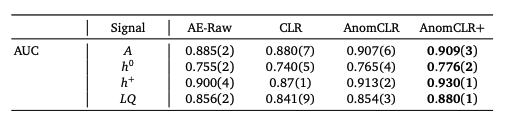

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2670, 1134, 32, 1774]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.8895371450797356 (TPR=0.3)
     $h^0$: 12.919896640826874 (TPR=0.2998)
   $h^\pm$: 666.6666666666666 (TPR=0.301)
      $LQ$: 7.936507936507937 (TPR=0.3001)


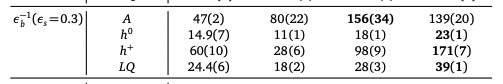

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5915422550438243 (TPR=0.3)
     $h^0$: 1.0769133909525423 (TPR=0.2998)
   $h^\pm$: 7.5249999999999995 (TPR=0.301)
      $LQ$: 0.8451006819127467 (TPR=0.3001)


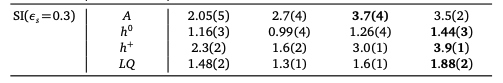

#MSOT: 2-Wasserstein distance anomaly score, individual species weighted combination (wList = [1., 0., 0., 1.])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 0., 0., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

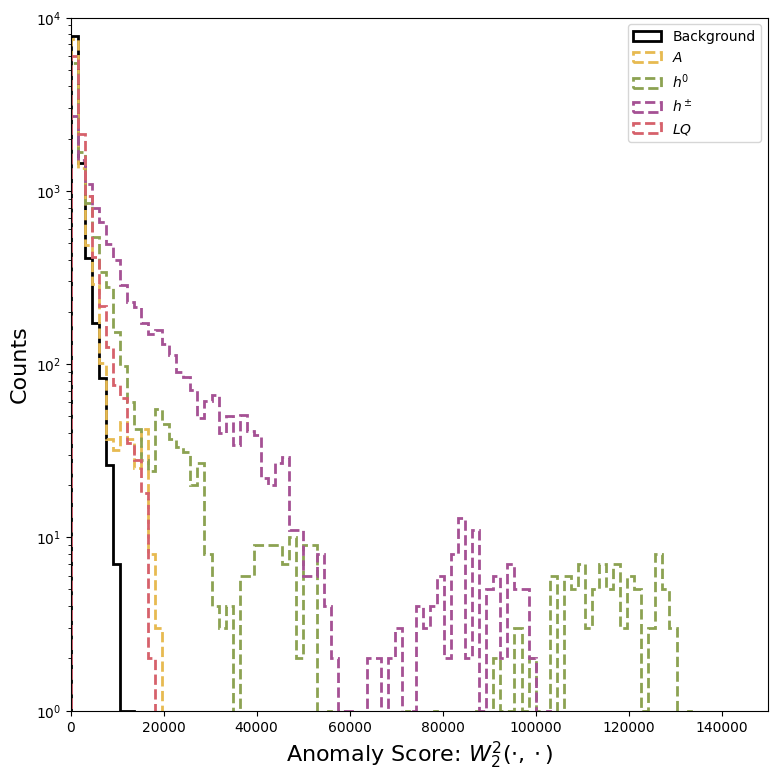

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 150000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

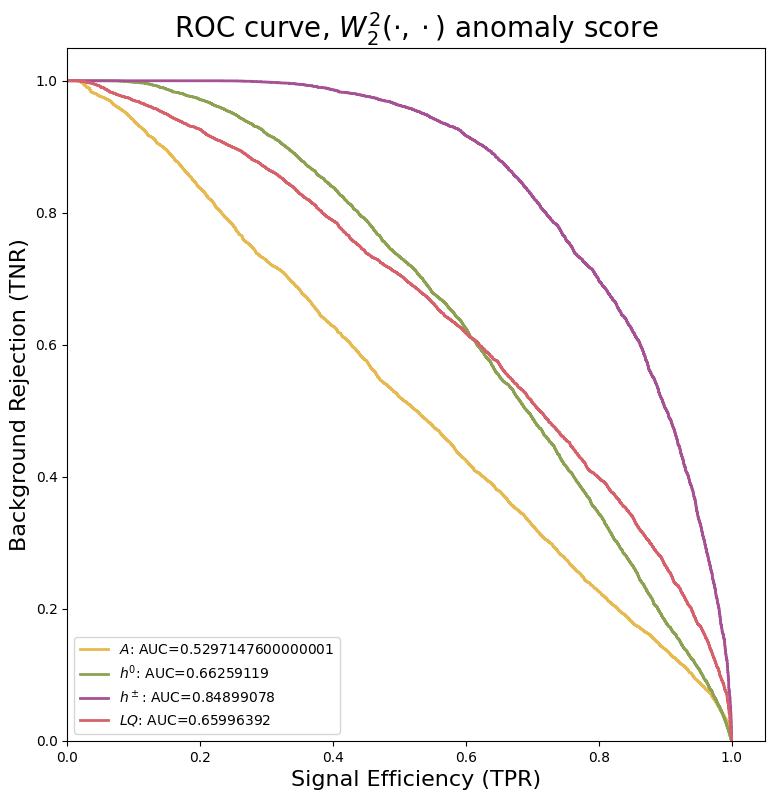

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

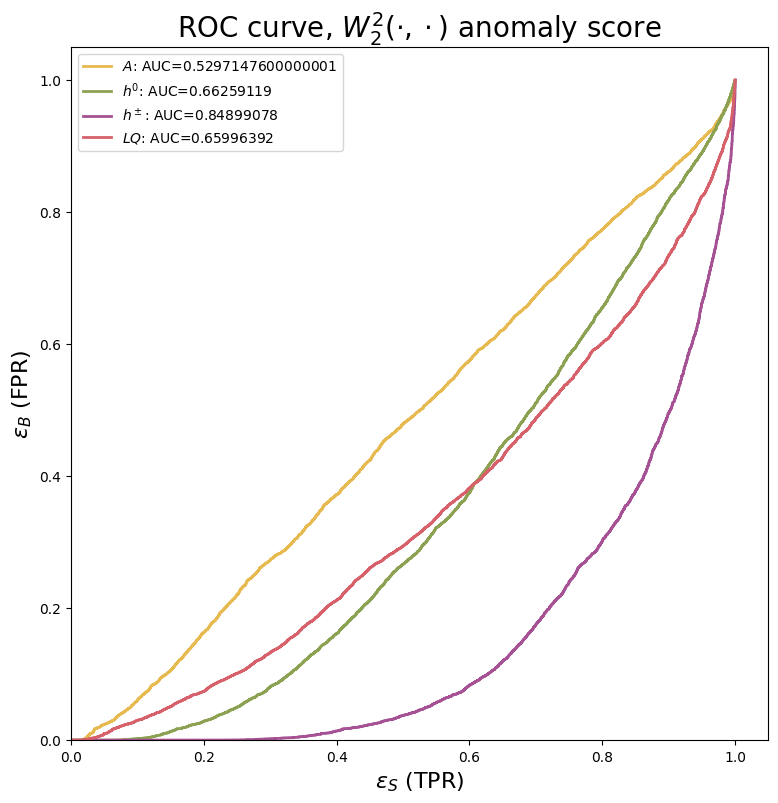

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

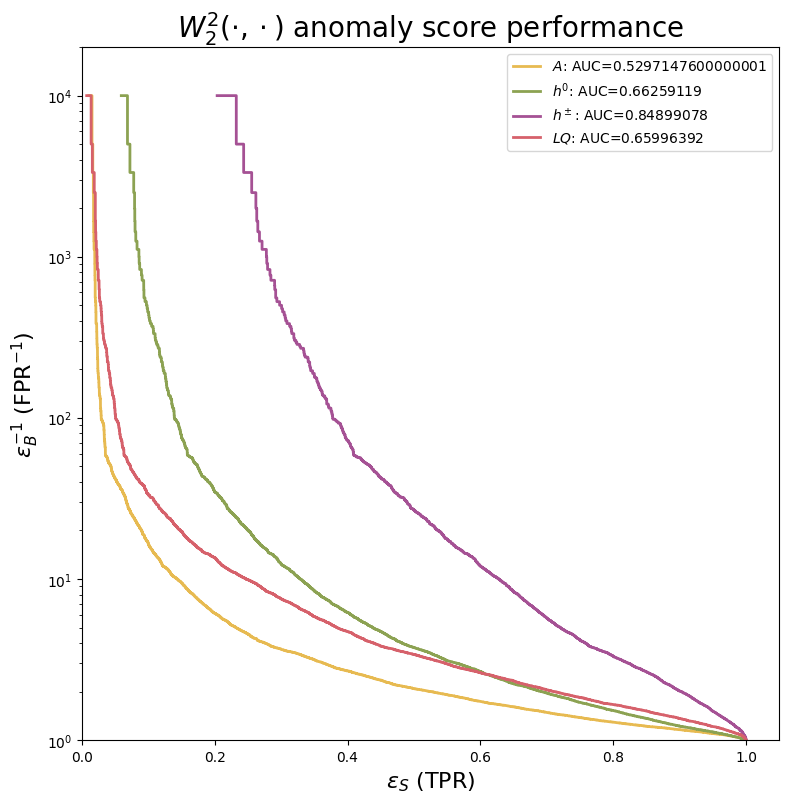

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

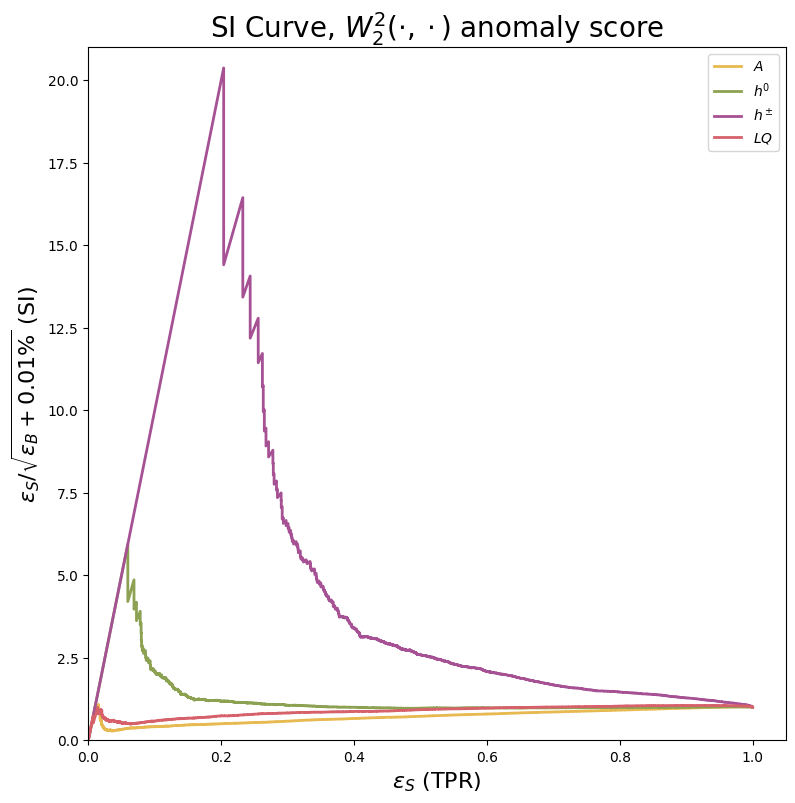

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 21)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 2.037e-01 2.037e-01 2.325e-01]
[0.00000000e+00 1.00000000e-02 2.03700000e+01 1.44037651e+01
 1.64402327e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5297147600000001
     $h^0$: 0.66259119
   $h^\pm$: 0.84899078
      $LQ$: 0.65996392


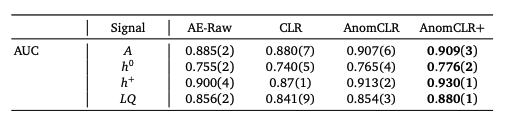

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2744, 1136, 40, 1764]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.6697247706422016 (TPR=0.3)
     $h^0$: 12.406947890818858 (TPR=0.3)
   $h^\pm$: 500.0 (TPR=0.3007)
      $LQ$: 7.547169811320754 (TPR=0.3001)


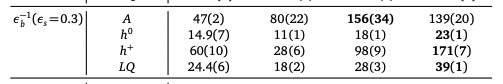

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5745903513810688 (TPR=0.3)
     $h^0$: 1.0560500157131443 (TPR=0.3)
   $h^\pm$: 6.561811959396292 (TPR=0.3007)
      $LQ$: 0.8241271720898251 (TPR=0.3001)


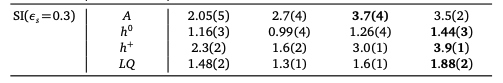

#MSOT: 2-Wasserstein distance anomaly score, individual species weighted combination (wList = [1., 2., 2., 1.])

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 2., 2., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

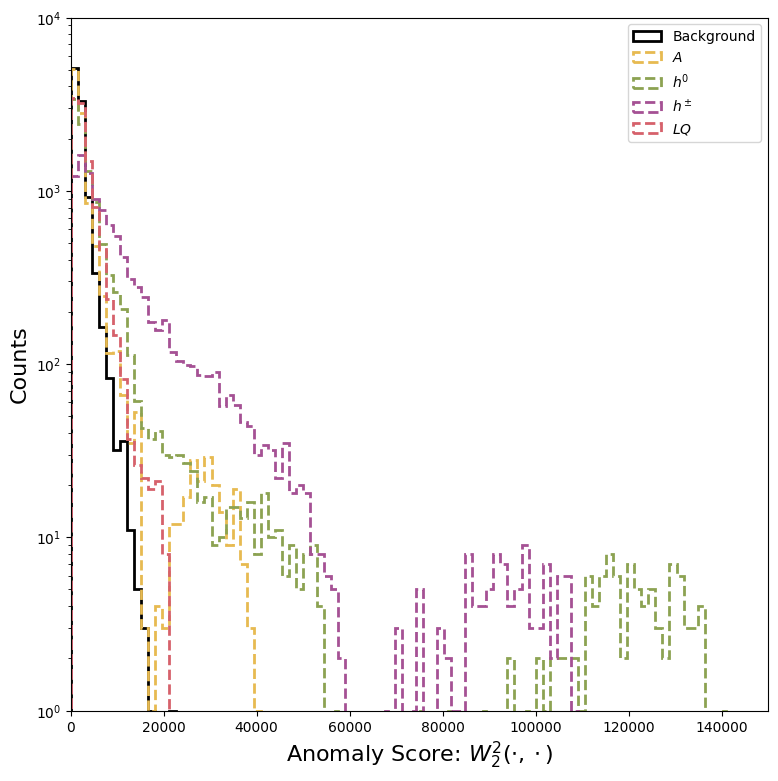

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3) 
plotArgDict['xAxisLims']          = (0, 150000) 
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

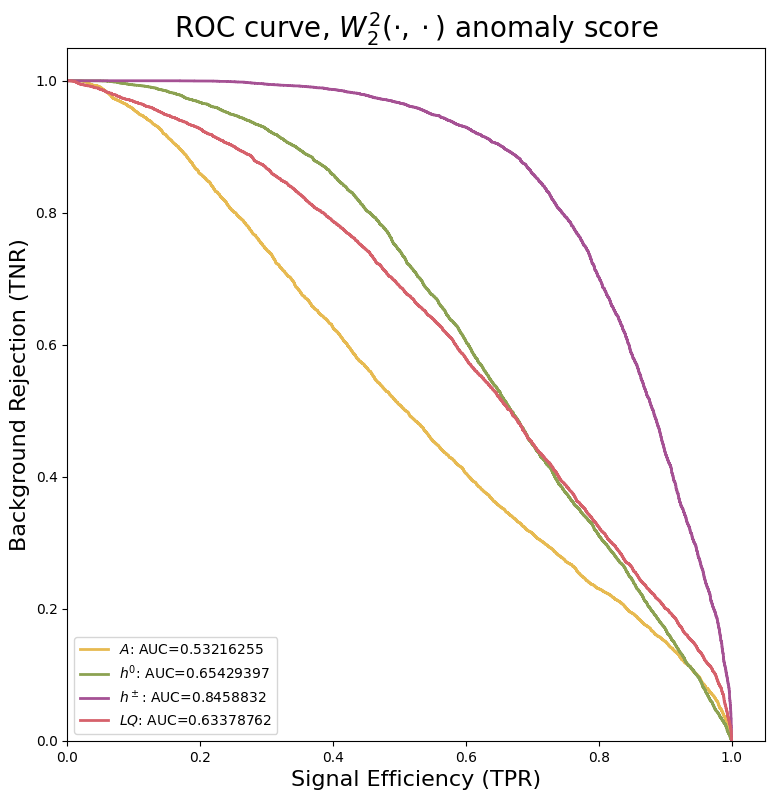

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR 
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

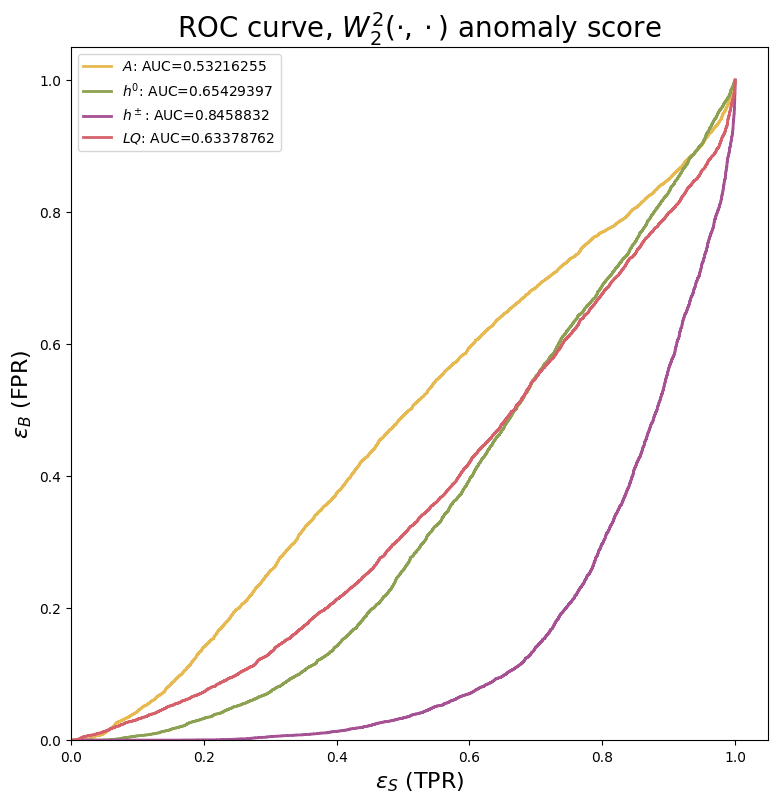

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

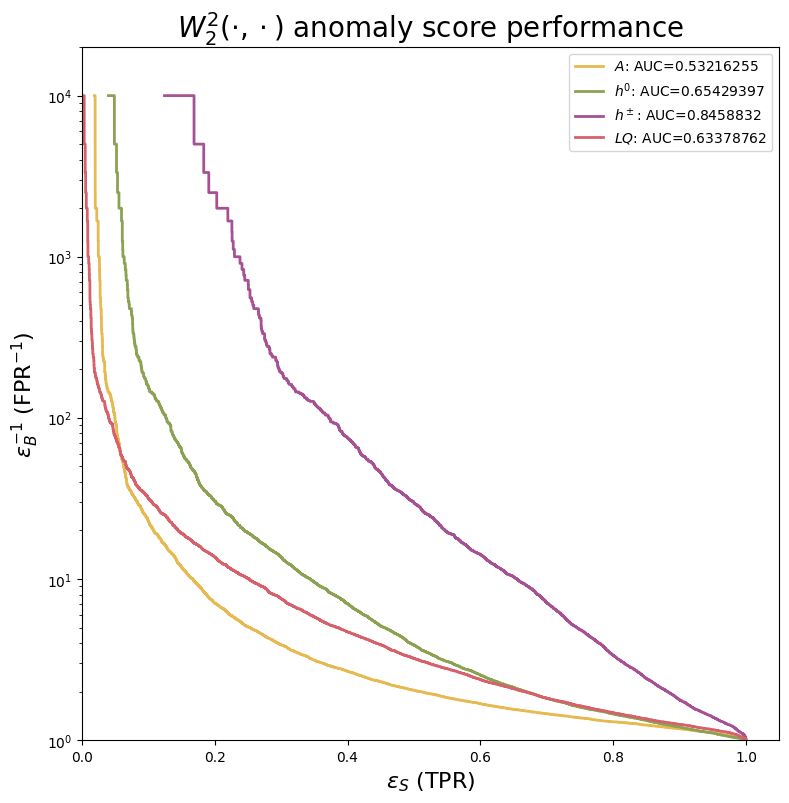

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

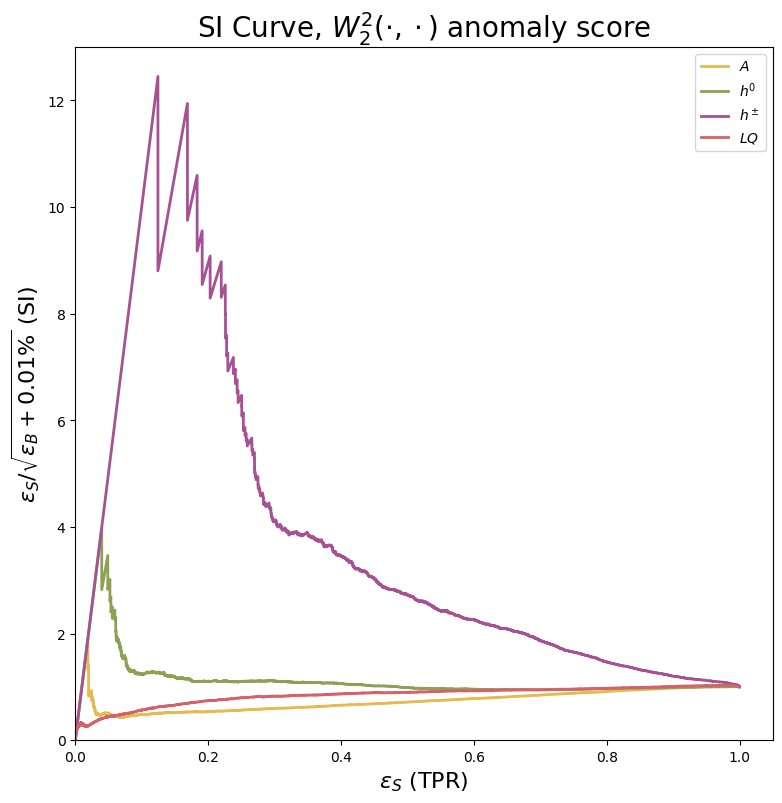

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 13)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.245e-01 1.245e-01 1.689e-01]
[0.00000000e+00 1.00000000e-02 1.24500000e+01 8.80347943e+00
 1.19430335e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.53216255
     $h^0$: 0.65429397
   $h^\pm$: 0.8458832
      $LQ$: 0.63378762


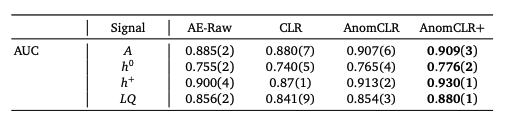

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2596, 1126, 96, 1782]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.904724716907458 (TPR=0.2999)
     $h^0$: 13.64256480218281 (TPR=0.2999)
   $h^\pm$: 192.30769230769232 (TPR=0.3009)
      $LQ$: 7.541478129713424 (TPR=0.2999)


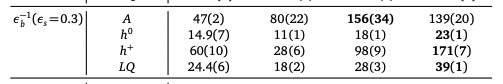

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5924980195752764 (TPR=0.2999)
     $h^0$: 1.1069510990530806 (TPR=0.2999)
   $h^\pm$: 4.133179369216053 (TPR=0.3009)
      $LQ$: 0.8232675628434193 (TPR=0.2999)


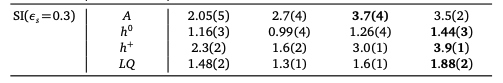

# MSOT: Ranking of individual OT scores per event

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)
  for subkey in scoreDict[key].keys():
    print("    ",subkey)

print("")
print("scoreDict[MET][wBB].shape", scoreDict['MET']['wBB'].shape)

scoreDict keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ

scoreDict[MET][wBB].shape (10000,)


## Signal Type = 'wBS_sig_A'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_A'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_A
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 38.019999999999996 
     e: 14.29 
    mu: 14.91 
   jet: 32.78 


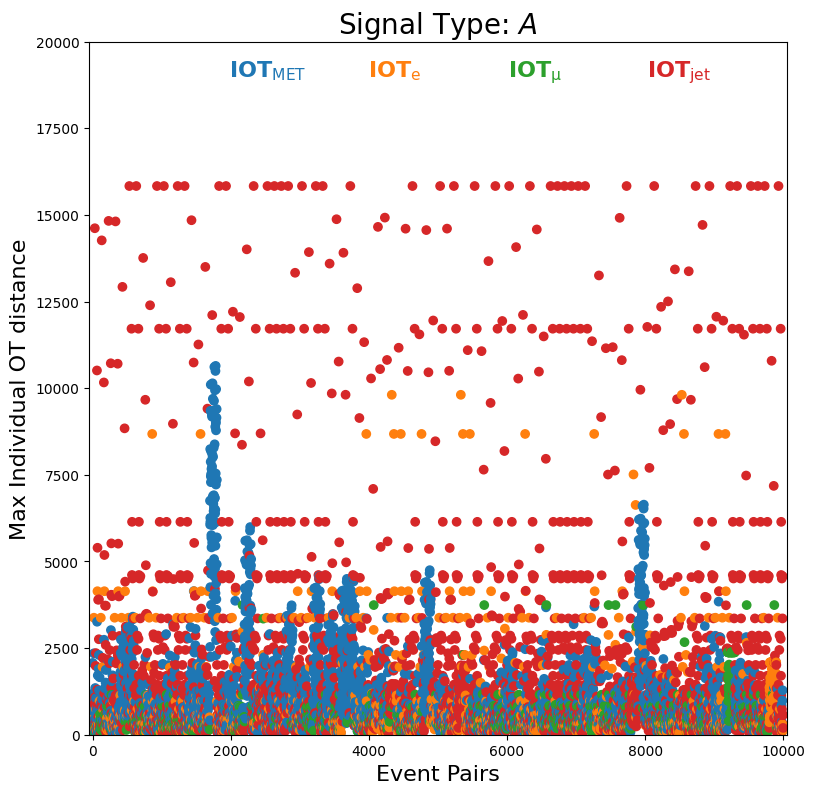

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 20e3)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $A$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_h0'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_h0'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_h0
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 53.959999999999994 
     e: 11.32 
    mu: 8.01 
   jet: 26.71 


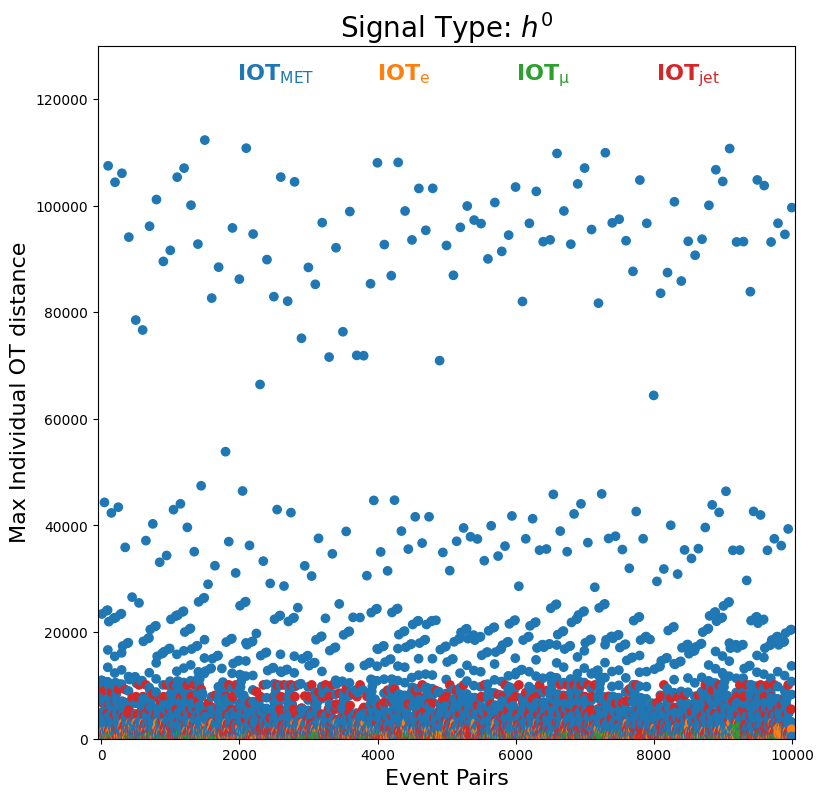

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.3e5)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $h^0$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_hch'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_hch'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_hch
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 63.85999999999999 
     e: 7.39 
    mu: 5.19 
   jet: 23.56 


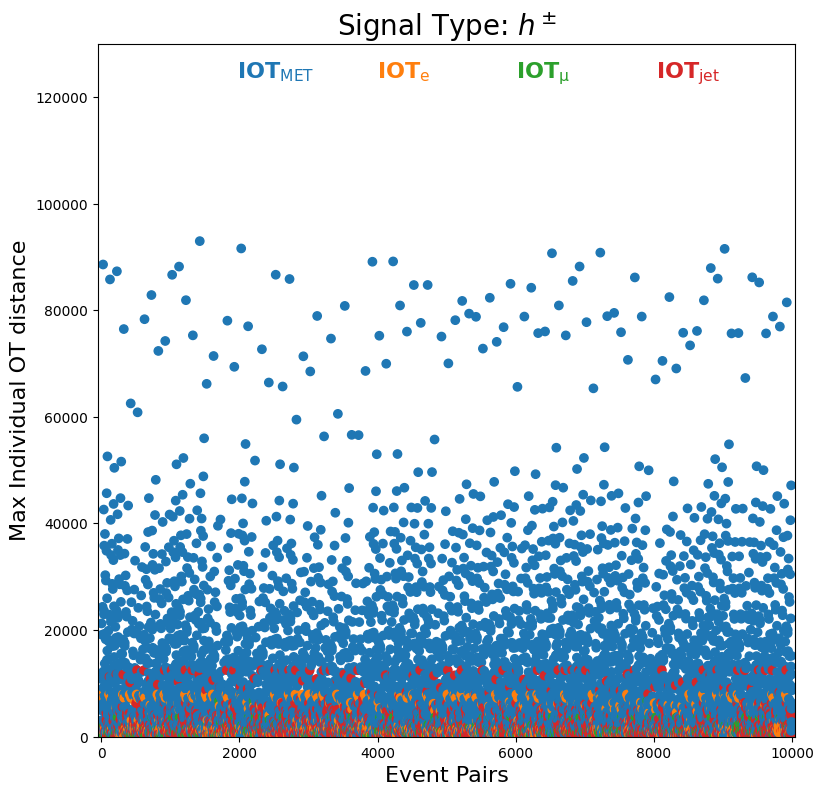

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.3e5)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $h^\pm$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_LQ'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_LQ'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_LQ
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 42.52 
     e: 9.16 
    mu: 8.709999999999999 
   jet: 39.61 


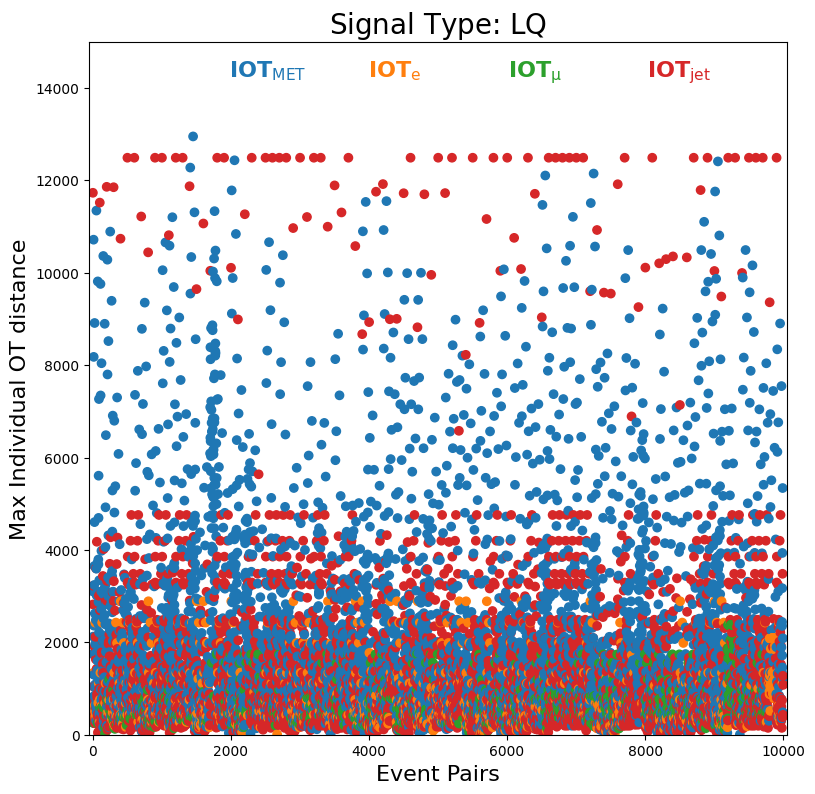

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.5e4)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: ${\rm LQ}$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

# Scratch work and old code dump

In [ ]:
print(objectsSigList[0][0:10,1:5])
print(np.count_nonzero(objectsSigList[0][0:10,1:5], axis=1))
print("")
print(multSigList[0][0][0:10])

[[27.07720375 22.70083046  5.34694767  0.        ]
 [28.45646477  0.          0.          0.        ]
 [28.02878571  0.          0.          0.        ]
 [13.49448109  0.          0.          0.        ]
 [63.17956924  9.57411385  0.          0.        ]
 [ 7.2873826   0.          0.          0.        ]
 [39.18241882 28.42032433 15.96776199 14.43635082]
 [27.51131248 19.05918694  0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[3 1 1 1 2 1 4 2 0 0]

[3 1 1 1 2 1 4 2 0 0]


In [ ]:
print(dataDict['bkg']['Particles'][0:10, 1:5, 0].shape)
print(dataDict['bkg']['Particles'][0:10, 1:5, 0])
print(np.count_nonzero(dataDict['bkg']['Particles'][0:10, 1:5, 0], axis=1))
print("")
print(multBkgList[0][0:10])

(10, 4)
[[24.20996857  0.          0.          0.        ]
 [24.35059357  0.          0.          0.        ]
 [40.46398544  0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [46.17391586  0.          0.          0.        ]
 [46.98254395  0.          0.          0.        ]
 [23.33667946  0.          0.          0.        ]]
[1 1 1 0 0 0 0 1 1 1]

[1 1 1 0 0 0 0 1 1 1]


In [ ]:
def func_dPhi(dPhi, MODE='A'):
  if MODE=='A':
    return np.pi - np.abs(np.pi - np.abs(dPhi))
  if MODE=='B':
    return np.abs(np.arctan2(np.sin(dPhi), np.cos(dPhi)))
  if MODE=='C':
    return np.arctan2(np.sin(dPhi), np.cos(dPhi))

def func_dPhiSq(dPhi, MODE='A'):
  if MODE=='A':
    return (np.pi - np.abs(np.pi - np.abs(dPhi)))**2
  if MODE=='B':
    return (np.abs(np.arctan2(np.sin(dPhi), np.cos(dPhi))))**2
  if MODE=='C':
    return (np.arctan2(np.sin(dPhi), np.cos(dPhi)))**2

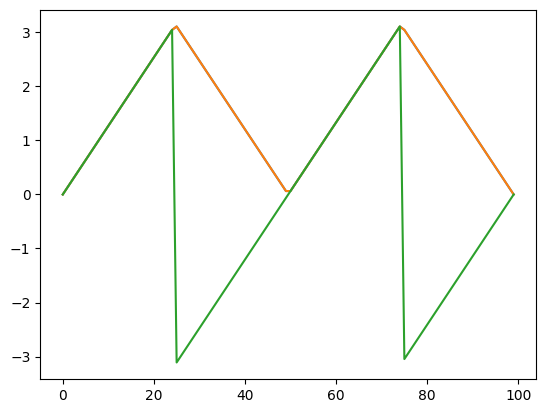

In [ ]:
dPhi = np.linspace(-2*np.pi, 2*np.pi, 100)

plt.plot(func_dPhi(dPhi, MODE='A'))
plt.plot(func_dPhi(dPhi, MODE='B'))
plt.plot(func_dPhi(dPhi, MODE='C'))

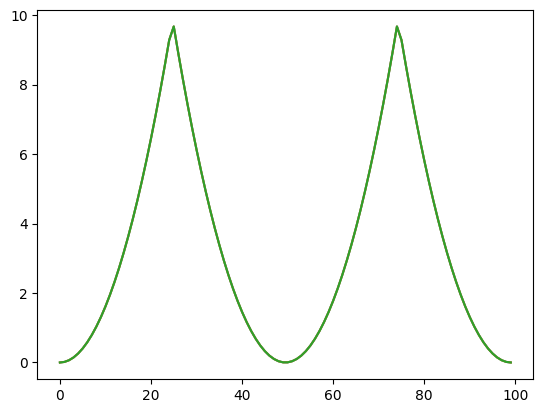

In [ ]:
dPhi = np.linspace(-2*np.pi, 2*np.pi, 100)

plt.plot(func_dPhiSq(dPhi, MODE='A'))
plt.plot(func_dPhiSq(dPhi, MODE='B'))
plt.plot(func_dPhiSq(dPhi, MODE='C'))

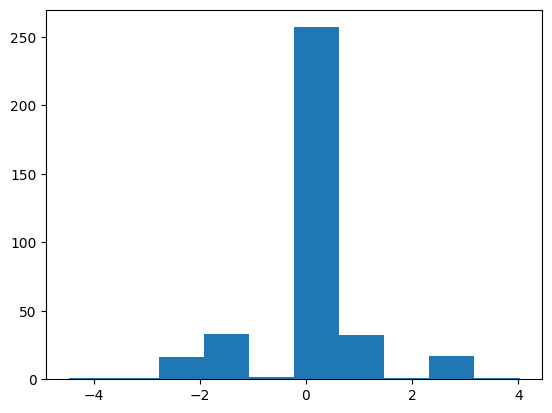

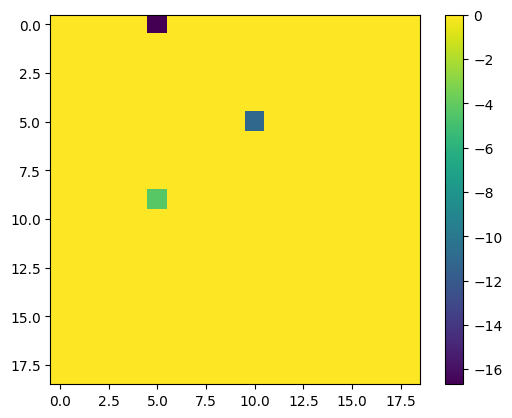

In [ ]:
#! TEST
xs = scoreDict['bkgEvents1'][0, :, :] # "source data points"
xt = scoreDict['bkgEvents2'][1, :, :] # "target data points"

dphis_Raw = xs[:, 2, None] - xt[:, 2]
plt.hist(dphis_Raw.flatten())
plt.show()

# Calculate cost matrix naively (MODE='Normal')
CNormal = calcGroundCostMatrix(xs, xt, MODE='Normal')
# plt.imshow(CNormal)
# plt.colorbar()
# plt.show()
# print("")

# Calculate cost matrix naively, but testing strategy for modularity method (MODE='Test')
CTest = calcGroundCostMatrix(xs, xt, MODE='Test')
# plt.imshow(CTest)
# plt.colorbar()
# plt.show()
# print("")

assert(np.allclose(CNormal, CTest))

# Calculate cost matrix taking into account modularity of phi
CModular = calcGroundCostMatrix(xs, xt, MODE='Modular')
# plt.imshow(CModular)
# plt.colorbar()
# plt.show()
# print("")

# Plot difference
plt.imshow(CModular - CNormal)
plt.colorbar()
plt.show()

In [ ]:
# Broadcast test
arr = np.arange(5)
print((arr[:,None] - arr[:])**2)
print("")

# Dumb method
brr = np.zeros((5,5))
for i in range(5):
  for j in range(5):
    brr[i,j] = (arr[i] - arr[j])**2
print(brr)
print("")

# OT method
print(ot.dist(arr.reshape(-1,1), arr.reshape(-1,1)))

[[ 0  1  4  9 16]
 [ 1  0  1  4  9]
 [ 4  1  0  1  4]
 [ 9  4  1  0  1]
 [16  9  4  1  0]]

[[ 0.  1.  4.  9. 16.]
 [ 1.  0.  1.  4.  9.]
 [ 4.  1.  0.  1.  4.]
 [ 9.  4.  1.  0.  1.]
 [16.  9.  4.  1.  0.]]

[[ 0  1  4  9 16]
 [ 1  0  1  4  9]
 [ 4  1  0  1  4]
 [ 9  4  1  0  1]
 [16  9  4  1  0]]


In [ ]:
def calcOT_statIndep(bkgEvents1, bkgEvents2, sigEvents):
  """
  Inputs:
     bkgEvents1:  Array of one sample of background events, shape (N, 19, 3)
     bkgEvents2:  Array of another sample of background events, shape (N, 19, 3)
     sigEvents:   Array of sample of signal events, shape (N, 19, 3)

  Outputs
     CBB:  Array of the background-to-background OT cost matrices, shape (N**2, 19, 19)
     wBB:  Array of the corresponding Wasserstein distances

     CBS:  Array of the background-to-signal OT cost matrices, shape (N**2, 19, 19)
     wBS:  Array of the corresponding Wasserstein distances
  
  NOTE: We're using the following references:
  - https://pythonot.github.io/auto_examples/plot_OT_2D_samples.html#sphx-glr-auto-examples-plot-ot-2d-samples-py
  - https://pythonot.github.io/quickstart.html#solving-optimal-transport
  """

  # Create lists for outputs
  CBB, wBB = [], []
  CBS, wBS = [], []
  
  # Get number of signal and background events
  assert(bkgEvents1.shape[0] == sigEvents.shape[0]) #! Make more general later
  assert(bkgEvents2.shape[0] == sigEvents.shape[0]) #! Make more general later
  N = bkgEvents1.shape[0]  

  # Assume that all particles are equally weighted 
  #! In the example "n" was number of samples... is this adaptation ok?
  # https://pythonot.github.io/all.html#ot.emd
  nParticles = 19
  a = np.ones((nParticles,)) / nParticles
  b = a

  #-- Loop over pairs of events --#
  dummyArr = np.arange(N)
  for (i,j) in itertools.product(dummyArr, dummyArr):
    
    xs = bkgEvents1[i, :, :] # "source data points"

    #-- Solve background-background OT problem  --#

    # Calculate BB cost matrix
    xt = bkgEvents2[j, :, :] # "target data points"
    cbb = ot.dist(xs, xt)
    CBB.append(cbb)

    # Calculate the Wasserstein distance
    wBB.append(ot.emd2(a, b, cbb))

    #-- Solve background-signal OT problem  --#
    
    # Calculate BS cost matrix
    xt = sigEvents[j, :, :] # "target data points"
    cbs = ot.dist(xs, xt)
    CBS.append(cbs)

    # Calculate the Wasserstein distance
    wBS.append(ot.emd2(a, b, cbs))

  return np.array(CBB), np.array(wBB), np.array(CBS), np.array(wBS)

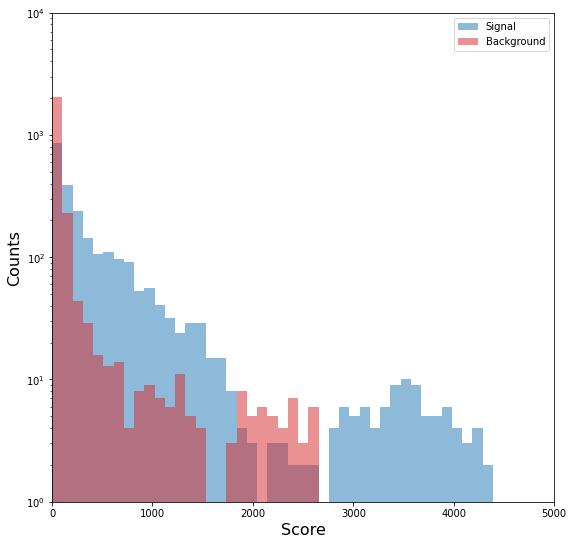

In [ ]:
scoreBkg, scoreSig = scoreDict['wBB'], scoreDict['wBS_sig_h0']

plotArgDict = {}
plotArgDict['pltDim']    = (3,3) 
plotArgDict['xAxisLims'] = (0, 5000) #(0, 1600)
plotArgDict['xLabel']    = r'Score'
plotArgDict['yAxisLims'] = (1, 1e4) #(0, 50)
plotArgDict['yLabel']    = r'Counts'
plotArgDict['title']     = r''
plotArgDict['nBins']     = 50
plotArgDict['logY']      = True

plotScoreHists(scoreBkg, scoreSig, plotArgDict)

##### prior test

In [ ]:
f_bkg = dataDict['bkg']
alias = 'sig_h0'
f_sig = dataDict[alias]

In [ ]:
nEvents   = 50

# Generate nEvents Signal events
random_state = Generator(PCG64(123))
sigEvents    = randomDataSample(f_sig['Particles'][:, :, 0:3], nEvents, random_state)

# Generate 2 different samples of nEvents Background events
random_state = Generator(PCG64(123))
bkgEvents1   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

random_state = Generator(PCG64(456))
bkgEvents2   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

Next we solve the OT problem to find the Wasserstein distance between pairs of events. We also obtain the "raw" cost matrices.

In [ ]:
CBB, wBB, CBS, wBS = calcOT_statIndep(bkgEvents1, bkgEvents2, sigEvents)
print(CBB.shape, wBB.shape, CBS.shape, wBS.shape)

(19,)
(2500, 19, 19) (2500,) (2500, 19, 19) (2500,)


Now we can visualize using Wasserstein distance as an anomaly score

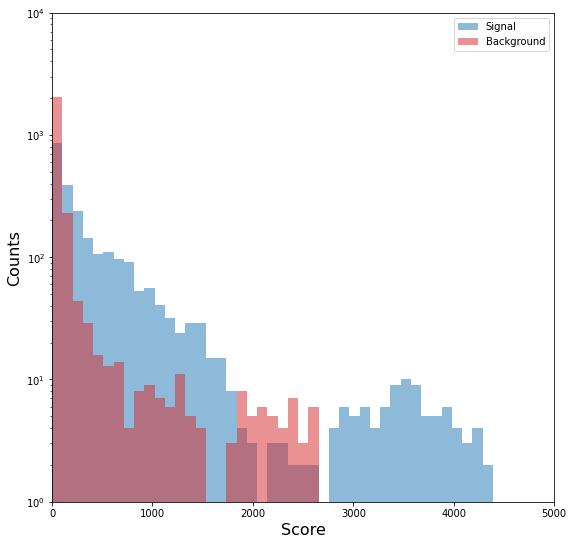

In [ ]:
scoreBkg, scoreSig = wBB, wBS

plotArgDict = {}
plotArgDict['pltDim']    = (3,3) 
plotArgDict['xAxisLims'] = (0, 5000) #(0, 1600)
plotArgDict['xLabel']    = r'Score'
plotArgDict['yAxisLims'] = (1, 1e4) #(0, 50)
plotArgDict['yLabel']    = r'Counts'
plotArgDict['title']     = r''
plotArgDict['nBins']     = 50
plotArgDict['logY']      = True

plotScoreHists(scoreBkg, scoreSig, plotArgDict)

Q: Are the gaps significant?

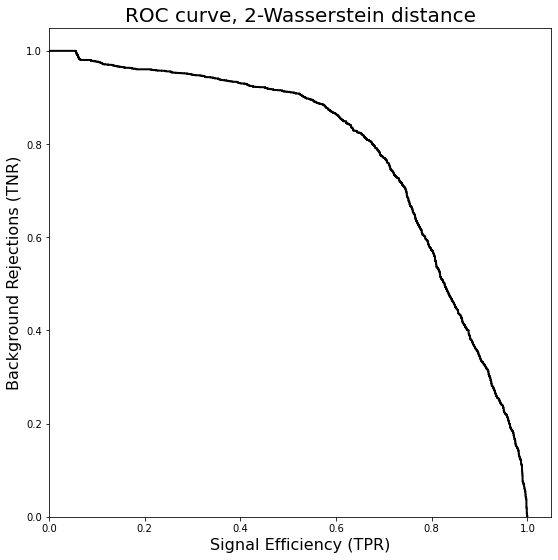

AUC =  0.78372752


In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejections (TNR)'
plotArgDict['title']     = r'ROC curve, 2-Wasserstein distance'

AUC = plotROCcurve(scoreBkg, scoreSig, plotArgDict)
print("AUC = ", AUC)

In [ ]:
# Sanity check
counter = 0
for x in scoreSig:
  if x > 3000:
    counter+=1
print("%d out of %d = %s"%(counter, len(scoreSig), str(counter/len(scoreSig))))

125 out of 2500 = 0.05


This seems right, we get a 5%+ signal efficiency if we reject 100% of background. 

Out of curiosity let's also look at using the mean of the cost matrix as the anomaly scores.

In [ ]:
scoreBkg_alt, scoreSig_alt = np.mean(CBB, axis=(1,2)),  np.mean(CBS, axis=(1,2))

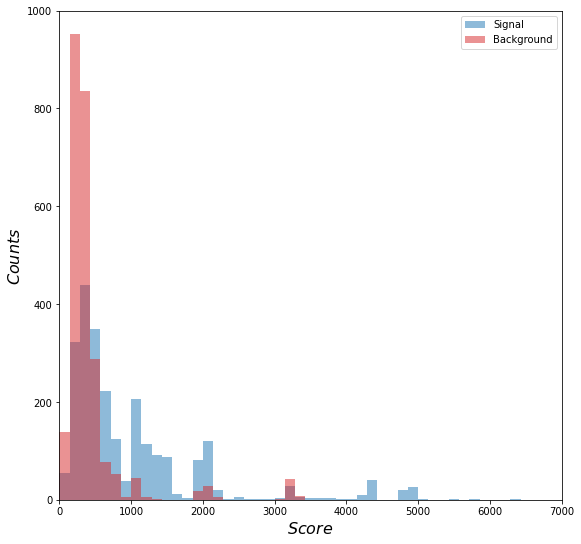

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3) 
plotArgDict['xAxisLims'] = (0, 7000)#(50, 1400)
plotArgDict['xLabel']    = r'$Score$'
plotArgDict['yAxisLims'] = (0,1000) #(0, 15)
plotArgDict['yLabel']    = r'$Counts$'
plotArgDict['title']     = r''
plotArgDict['nBins']     = 50
plotArgDict['logY']      = False

plotScoreHists(scoreBkg_alt, scoreSig_alt, plotArgDict)

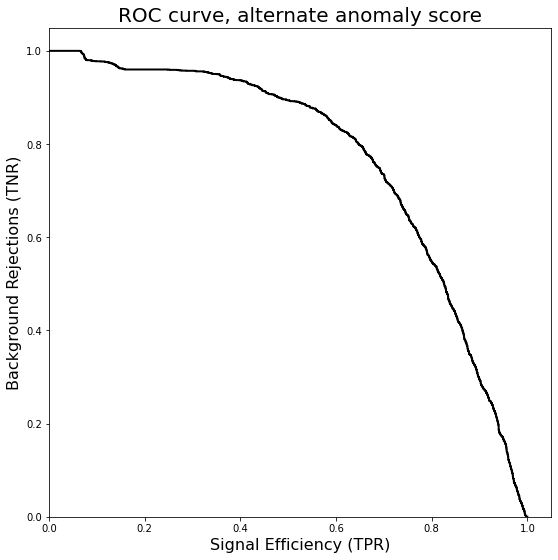

AUC =  0.76817488


In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejections (TNR)'
plotArgDict['title']     = r'ROC curve, alternate anomaly score'

AUC = plotROCcurve(scoreBkg_alt, scoreSig_alt, plotArgDict)
print("AUC = ", AUC)

In [ ]:
# Sanity check
threshold = 4000

counter = 0
for x in scoreSig_alt:
  if x > threshold:
    counter+=1
print("%d out of %d"%(counter, len(scoreSig_alt)))

counter = 0
for x in scoreBkg_alt:
  if x < threshold:
    counter+=1
print("%d out of %d"%(counter, len(scoreBkg_alt)))

153 out of 2500
2500 out of 2500


### First attempts

In [ ]:
xs  = f_bkg['Particles'][0, :, 0:3]
xt1 = f_sig['Particles'][0, :, 0:3]
xt2 = f_bkg['Particles'][1, :, 0:3]

M1 = ot.dist(xs, xt1)
M2 = ot.dist(xt1, xt2)

In [ ]:
n=19
a, b = np.ones((n,)) / n, np.ones((n,)) / n
G1 = ot.emd(a, b, M1)
G2 = ot.emd(a, b, M2)

In [ ]:
print(a)

[0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 0.05263158]


In [ ]:
w1 = np.sum(G1 * M1)
w2 = np.sum(G2 * M2)
print(w1, w2)

1119.0807371408116 882.6586449566664


In [ ]:
print(ot.emd2(a, b, M1), ot.emd2(a, b, M2))

1119.0807371408116 882.6586449566662


In [ ]:
print(np.mean(G1*M1), np.mean(M1))
print(np.mean(G2*M2), np.mean(M2))

3.0999466402792564 2364.1872665368305
2.445037797663896 2534.429328218623


In [ ]:
nEvents = 10

# Generate nEvents Signal events
random_state = Generator(PCG64(123))
sigEvents    = randomDataSample(f_sig['Particles'][:, :, 0:3], nEvents, random_state)

# Generate 2 different samples of nEvents Background events
random_state = Generator(PCG64(123))
bkgEvents1   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

random_state = Generator(PCG64(456))
bkgEvents2   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
# Calculate OT cost matrices
mOT_BB, mOT_BS = calcCostMatrix_statIndep(bkgEvents1, bkgEvents2, sigEvents)
print(mOT_BB.shape, mOT_BS.shape)

In [ ]:
# Calculate means of cost matrices as a quick visualization
mOT_BB_mean, mOT_BS_mean = np.mean(mOT_BB, axis=(1,2)), np.mean(mOT_BS, axis=(1,2))
print(mOT_BB_mean.shape, mOT_BS_mean.shape)

(25,) (25,)


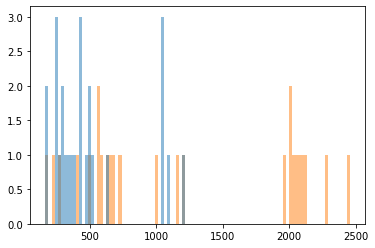

In [ ]:
_, bins, _ = plt.hist(mOT_BS_mean, bins=100, color="tab:orange", alpha=0.5)
plt.hist(mOT_BB_mean, bins=bins, color="tab:blue", alpha=0.5)
plt.show()

In [ ]:
np.repeat(0, mOT_BB_mean.shape[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [ ]:
print(plotROCcurve(mOT_BB_mean, mOT_BS_mean))

0.7871999999999999


In [ ]:
nEvents = 10

# Generate nEvents Signal events
random_state = Generator(PCG64(847))
sigEvents    = randomDataSample(f_sig['Particles'][:, :, 0:3], nEvents, random_state)

# Generate 2 different samples of nEvents Background events
random_state = Generator(PCG64(847))
bkgEvents1   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

random_state = Generator(PCG64(6969))
bkgEvents2   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
# Calculate OT cost matrices
mOT_BB, mOT_BS = calcCostMatrix_statIndep(bkgEvents1, bkgEvents2, sigEvents)
print(mOT_BB.shape, mOT_BS.shape)

# Calculate means of cost matrices as a quick visualization
mOT_BB_mean, mOT_BS_mean = np.mean(mOT_BB, axis=(1,2)), np.mean(mOT_BS, axis=(1,2))
print(mOT_BB_mean.shape, mOT_BS_mean.shape)

(100, 19, 19) (100, 19, 19)
(100,) (100,)


In [ ]:
print(plotROCcurve(mOT_BB_mean, mOT_BS_mean))

0.8417


In [ ]:
nEvents = 10

# Generate nEvents Signal events
random_state = Generator(PCG64(420))
sigEvents    = randomDataSample(f_sig['Particles'][:, :, 0:3], nEvents, random_state)

# Generate 2 different samples of nEvents Background events
random_state = Generator(PCG64(420))
bkgEvents1   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

random_state = Generator(PCG64(8008))
bkgEvents2   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
# Calculate OT cost matrices
mOT_BB, mOT_BS = calcCostMatrix_statIndep(bkgEvents1, bkgEvents2, sigEvents)
print(mOT_BB.shape, mOT_BS.shape)

# Calculate means of cost matrices as a quick visualization
mOT_BB_mean, mOT_BS_mean = np.mean(mOT_BB, axis=(1,2)), np.mean(mOT_BS, axis=(1,2))
print(mOT_BB_mean.shape, mOT_BS_mean.shape)

(100, 19, 19) (100, 19, 19)
(100,) (100,)


In [ ]:
print(plotROCcurve(mOT_BB_mean, mOT_BS_mean))

0.5214


In [ ]:
nEvents = 50

# Generate nEvents Signal events
random_state = Generator(PCG64(420))
sigEvents    = randomDataSample(f_sig['Particles'][:, :, 0:3], nEvents, random_state)

# Generate 2 different samples of nEvents Background events
random_state = Generator(PCG64(420))
bkgEvents1   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

random_state = Generator(PCG64(8008))
bkgEvents2   = randomDataSample(f_bkg['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
# Calculate OT cost matrices
mOT_BB, mOT_BS = calcCostMatrix_statIndep(bkgEvents1, bkgEvents2, sigEvents)
print(mOT_BB.shape, mOT_BS.shape)

# Calculate means of cost matrices as a quick visualization
mOT_BB_mean, mOT_BS_mean = np.mean(mOT_BB, axis=(1,2)), np.mean(mOT_BS, axis=(1,2))
print(mOT_BB_mean.shape, mOT_BS_mean.shape)

(2500, 19, 19) (2500, 19, 19)
(2500,) (2500,)


In [ ]:
print(plotROCcurve(mOT_BB_mean, mOT_BS_mean))

0.74778768


In [ ]:
nEvents   = 5
bkgEvents1 = f_bkg['Particles'][0:nEvents, :, 0:3]
bkgEvents2 = f_bkg['Particles'][0:nEvents, :, 0:3]
sigEvents = f_sig['Particles'][0:nEvents, :, 0:3]

mOT_BB, mOT_BS = calcCostMatrix(bkgEvents, sigEvents)

In [ ]:
# Calculate means of cost matrices as a quick visualization
mOT_BB_mean, mOT_BS_mean = np.mean(mOT_BB, axis=(1,2)), np.mean(mOT_BS, axis=(1,2))

In [ ]:
print(mOT_BB.shape, mOT_BS.shape)
print(mOT_BB_mean.shape, mOT_BS_mean.shape)

(20, 19, 19) (25, 19, 19)
(20,) (25,)


In [ ]:
mOT_BS = []
mOT_BB = []
for i in range(10):
  xs = f_bkg['Particles'][i, :, 0:3]
  for j in range(10):
    xt = f_sig['Particles'][j, :, 0:3]
    mOT_BS.append(ot.dist(xs, xt).mean())

    if i!=j:
      xt = f_bkg['Particles'][j, :, 0:3]
      mOT_BB.append(ot.dist(xs, xt).mean())

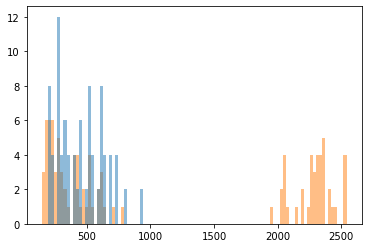

In [ ]:
_, bins, _ = plt.hist(mOT_BS, bins=100, color="tab:orange", alpha=0.5)
plt.hist(mOT_BB, bins=bins, color="tab:blue", alpha=0.5)
plt.show()

In [ ]:
counter = 0
for x in mOT_BS:
  if x > 1500:
    counter+=1
print("%d out of %d"%(counter, len(mOT_BS)))

40 out of 100


In [ ]:
i = 0
j = 5
eventB0 = f_bkg['Particles'][i, :, 0:3]
eventB1 = f_bkg['Particles'][i+1, :, 0:3]
eventS  = f_sig['Particles'][j, :, 0:3]

MBB = ot.dist(eventB0, eventB1)
MBS = ot.dist(eventB0, eventS)

In [ ]:
print(MBB.shape, MBS.shape)
print(MBB.mean())
print(MBS.mean())

(19, 19) (19, 19)
638.5950685719466
284.4334151236349


In [ ]:
print(MBB.shape, MBS.shape)
print(MBB.mean())
print(MBS.mean())

(19, 19) (19, 19)
638.5950685719466
390.54474101734786


In [ ]:
print(MBB.shape, MBS.shape)
print(MBB.mean())
print(MBS.mean())

(19, 19) (19, 19)
638.5950685719466
2364.1872665368305


In [ ]:
# fig_size = (3*3, 3*3)
# fig = plt.figure(constrained_layout=False, figsize=fig_size)
# ax = fig.add_subplot()
# pos = ax.imshow(MBB)
# fig.colorbar(pos, ax=ax)
# plt.show()

# fig_size = (3*3, 3*3)
# fig = plt.figure(constrained_layout=False, figsize=fig_size)
# ax = fig.add_subplot()
# pos = ax.imshow(MBS)
# fig.colorbar(pos, ax=ax)
# plt.show()

In [ ]:
shapeDiff =  f_bkg['Particles'][:, 0, 0].shape[0] - f_sig['Particles'][:, 0, 0].shape[0]
SB = np.concatenate((f_bkg['Particles'][0:shapeDiff, 0, 0], f_sig['Particles'][:, 0, 0]), axis=0)
B  = f_bkg['Particles'][:, 0, 0]

print(SB.shape, B.shape)

(4000000,) (4000000,)


In [ ]:
# ot.sliced_wasserstein_distance(SB.reshape(-1,1), B.reshape(-1,1))

In [ ]:
print(ot.dist(f_bkg['Particles'][0, 0, 0:3].reshape(-1,1), f_sig['Particles'][0, 0, 0:3].reshape(-1,1)))
print("")
print(ot.dist(f_bkg['Particles'][0, 0, 0:3].reshape(-1,1), f_bkg['Particles'][0, 0, 0:3].reshape(-1,1)))
print("")
print(ot.dist(f_sig['Particles'][0, 0, 0:3].reshape(-1,1), f_sig['Particles'][0, 0, 0:3].reshape(-1,1)))

[[1.20865762e+04 2.00730231e+02 2.24055839e+02]
 [1.54025215e+04 0.00000000e+00 6.40904708e-01]
 [1.51852148e+04 7.71923404e-01 2.81956809e+00]]

[[  0.         200.73023055 176.6065027 ]
 [200.73023055   0.           0.7719234 ]
 [176.6065027    0.7719234    0.        ]]

[[0.00000000e+00 1.54025215e+04 1.56018737e+04]
 [1.54025215e+04 0.00000000e+00 6.40904708e-01]
 [1.56018737e+04 6.40904708e-01 0.00000000e+00]]


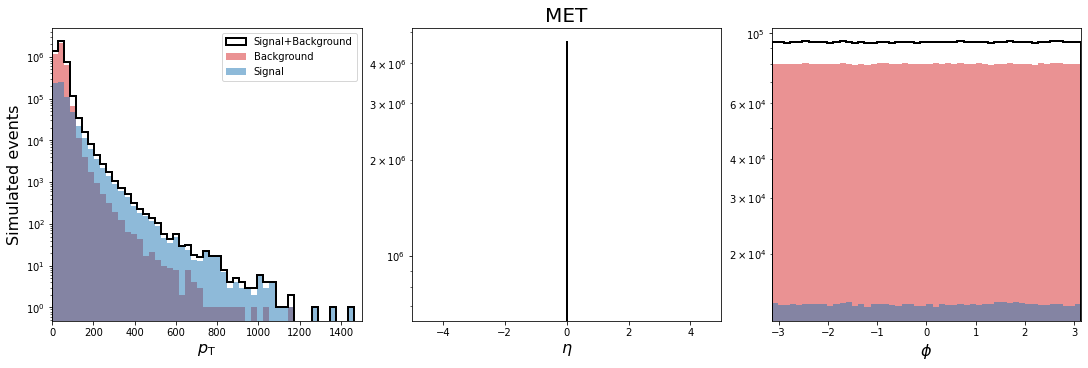

In [ ]:
# Plot MET PT, eta, phi for all events
plotArgDict = {}
plotArgDict['pltDim']        = (1,3) # i.e. 1 row, 3 columns
plotArgDict['xAxisLimsList'] = [(0, 1500), (-5, 5), (-np.pi, np.pi)]
plotArgDict['title']     = r'MET'
plotArgDict['nBins']     = 50

plotDataHists(f_bkg['Particles'][:, 0, :], f_sig['Particles'][:, 0, :], plotArgDict)

In [ ]:
# Plot histograms of an object's pT, eta, phi for S and S+B
# !! Make it objectSigList later to accomodate multiple kinds of signal classes
def plotDataHists(objectBkg, objectSig, plotArgDict):
  """
  objectBkg:  A background event's object's (e.g. MET) pT, eta, phi; shape = (Nb, 3); Nb = number of background events
  objectSig:  A signal event's object's (e.g. MET) pT, eta, phi; shape = (Ns, 3); Ns = number of background events

  Sample plotArgDict
      plotArgDict = {}
      plotArgDict['pltDim']    = (1,3) # i.e. 1 row, 3 columns
      plotArgDict['xAxisLimsList'] = [(-6, 6), ]
      plotArgDict['title']     = r'MET'
      plotArgDict['CMAP']      = plt.cm.get_cmap('nipy_spectral').reversed()
      plotArgDict['nBins']     = 20
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (5*pltDim[1], 5*pltDim[0])
  fig = plt.figure(constrained_layout=True, figsize=fig_size)
  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  axes = []
  for i in range(pltDim[1]):
    axes.append(fig.add_subplot(gs[:, i]))

  xLabelList = [r'$p_{\rm T}$', r'$\eta$', r'$\phi$']

  #-- Combine data for S+B plot --#
  objectBkgSig = np.concatenate((objectBkg, objectSig), axis=0)

  #-- Loop over axes to make plots --#
  for i in range(pltDim[1]):
    
    ax = axes[i]

    # Set axis and title information
    xmin, xmax = plotArgDict['xAxisLimsList'][i]
    ax.set_xlim(xmin, xmax)
    ax.set(xlabel=xLabelList[i])
    ax.xaxis.label.set_size(16)

    if i==0:
      ax.set(ylabel=r'Simulated events')
      ax.yaxis.label.set_size(16)

    if i==1:
      ax.set_title(plotArgDict['title'], fontsize=20)

    # Get data
    S  = objectSig[:,i]
    B  = objectBkg[:,i]
    SB = objectBkgSig[:,i]

    # Make plot with legend
    _, bins, _ = ax.hist(SB, bins=plotArgDict['nBins'], histtype = 'step', edgecolor='black', linestyle='-', linewidth=2, fill=False, log=True, label='Signal+Background')
    _, _, _,   = ax.hist(B, bins=bins, color='tab:red', alpha=0.5, log=True, label='Background')
    _, _, _,   = ax.hist(S, bins=bins, color='tab:blue', alpha=0.5, log=True, label='Signal')

    if i==0:
      ax.legend(loc='upper right')
  
  #-- Show the plot --#
  plt.show()

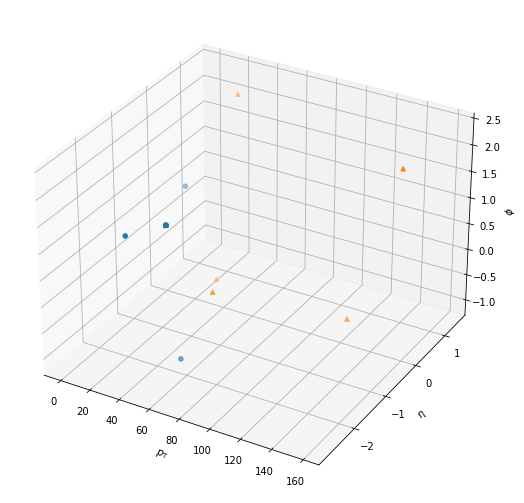

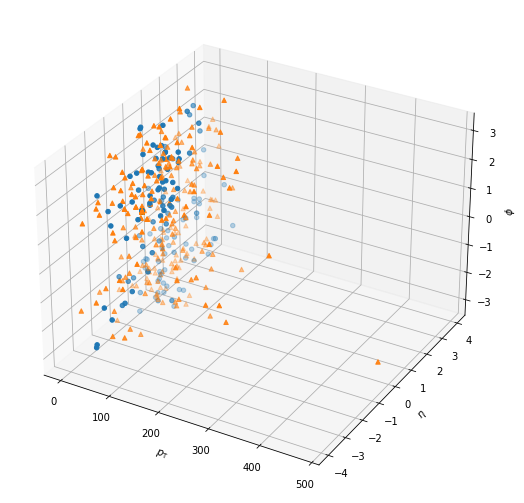

In [ ]:
# Plot an S event and a B event in 3D
fig_size = (3*3, 3*3)
fig = plt.figure(constrained_layout=False, figsize=fig_size)
ax = fig.add_subplot(projection='3d')

for i in range(1):
  xs = f_bkg['Particles'][i, :, 0]
  ys = f_bkg['Particles'][i, :, 1]
  zs = f_bkg['Particles'][i, :, 2]
  ax.scatter(xs, ys, zs, marker='o', color='tab:blue')

  xs = f_sig['Particles'][i, :, 0]
  ys = f_sig['Particles'][i, :, 1]
  zs = f_sig['Particles'][i, :, 2]
  ax.scatter(xs, ys, zs, marker='^', color='tab:orange')

ax.set_xlabel(r'$p_{\rm T}$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel(r'$\phi$')

plt.show()


# Plot many events
fig_size = (3*3, 3*3)
fig = plt.figure(constrained_layout=False, figsize=fig_size)
ax = fig.add_subplot(projection='3d')

for i in range(50):
  xs = f_bkg['Particles'][i, :, 0]
  ys = f_bkg['Particles'][i, :, 1]
  zs = f_bkg['Particles'][i, :, 2]
  ax.scatter(xs, ys, zs, marker='o', color='tab:blue')

  xs = f_sig['Particles'][i, :, 0]
  ys = f_sig['Particles'][i, :, 1]
  zs = f_sig['Particles'][i, :, 2]
  ax.scatter(xs, ys, zs, marker='^', color='tab:orange')

ax.set_xlabel(r'$p_{\rm T}$')
ax.set_ylabel(r'$\eta$')
ax.set_zlabel(r'$\phi$')

plt.show()

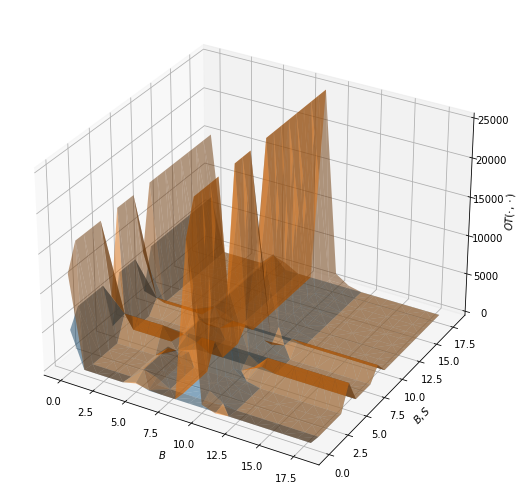

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig_size = (3*3, 3*3)
fig = plt.figure(constrained_layout=False, figsize=fig_size)
ax = fig.add_subplot(projection='3d')

# X, Y = np.meshgrid(np.arange(19),np.arange(19))
# ax.plot_wireframe(X, Y, MBB, color='tab:blue')
# ax.plot_wireframe(X, Y, MBS, color='tab:orange')

X, Y = np.meshgrid(np.arange(19),np.arange(19))
ax.plot_trisurf(X.flatten(), Y.flatten(), MBB.flatten(), color='tab:blue', alpha=0.5)
ax.plot_trisurf(X.flatten(), Y.flatten(), MBS.flatten(), color='tab:orange', alpha=0.5)

ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$B, S$')
ax.set_zlabel(r'$OT(\cdot, \cdot)$')

plt.show()

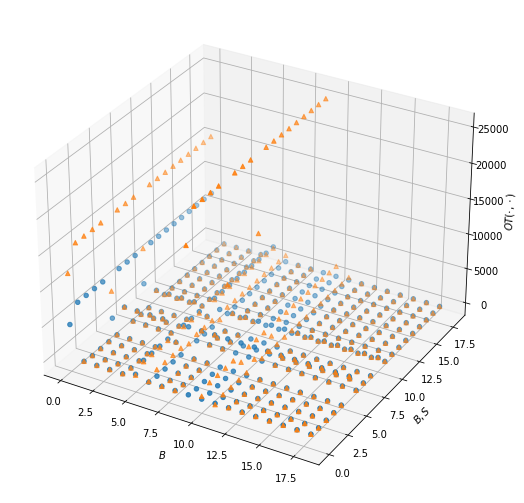

In [ ]:
from mpl_toolkits.mplot3d import axes3d

fig_size = (3*3, 3*3)
fig = plt.figure(constrained_layout=False, figsize=fig_size)
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(np.arange(19),np.arange(19))
ax.scatter(X.flatten(), Y.flatten(), MBB.flatten(), marker='o', color='tab:blue')
ax.scatter(X.flatten(), Y.flatten(), MBS.flatten(), marker='^', color='tab:orange')

ax.set_xlabel(r'$B$')
ax.set_ylabel(r'$B, S$')
ax.set_zlabel(r'$OT(\cdot, \cdot)$')

plt.show()

In [ ]:
def calcCostMatrix(bkgEvents, sigEvents):
  """
  Inputs:
     bkgEvents:  Array of background events, shape (N, 19, 3)
     sigEvents:  Array of signal events, shape (N, 19, 3)

  Outputs
     MBB:  Array of the background-to-background OT cost matrices, shape (N**2 - N, 19, 19)
     MBS:  Array of the background-to-signal OT cost matrices, shape (N**2, 19, 19)
  """

  # Create lists for cost matrices
  mOT_BS = []
  mOT_BB = []

  # Get number of signal and background events
  assert(bkgEvents.shape[0] == sigEvents.shape[0]) #! Make more general later
  N = bkgEvents.shape[0]

  """
  Calculate the OT distances:
      1) OT(bEvent[i], bEvent[j]) (i =/= j)
      2) OT(bEvent[i], sEvent[j]) 
  """

  # Loop over background events
  for i in range(N):
    xs = bkgEvents[i, :, :] # "source data points"

    # Loop over signal events
    for j in range(N):

      # Calculate BS distance
      xt = sigEvents[j, :, :] # "target data points"
      mOT_BS.append(ot.dist(xs, xt))

      # Calculate BB distance (if i=/=j)
      if i!=j:
        xt = bkgEvents[j, :, :]
        mOT_BB.append(ot.dist(xs, xt))

  return np.array(mOT_BB), np.array(mOT_BS)

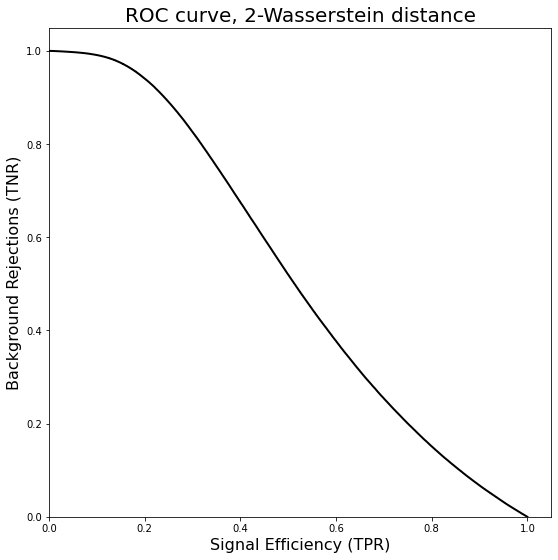

AUC =  0.5306833471756501


In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejections (TNR)'
plotArgDict['title']     = r'ROC curve, 2-Wasserstein distance'

AUC = plotROCcurve(f_bkg['Particles'][:, 0, 0], f_sig['Particles'][:, 0, 0], plotArgDict)
print("AUC = ", AUC)

In [ ]:
# Plot 1D histogram of scalar OT quantity (e.g. mean)
# !! Make it objectSigList later to accomodate multiple kinds of signal classes
def plotScoreHists(scoreBkg, scoreSig, plotArgDict):
  """
  scoreBkg:  An array of anomaly scores for a set of background events (assuming a reference background sample)
  scoreSig:  An array of anomaly scores for a set of signal events (assuming a reference background sample)

  Sample plotArgDict
      plotArgDict = {}
      plotArgDict['pltDim']    = (1,1) 
      plotArgDict['xAxisLims'] = (0, 3000)
      plotArgDict['xLabel']    = r'$Score$'
      plotArgDict['yAxisLims'] = (0, 20)
      plotArgDict['yLabel']    = r'$Counts$'
      plotArgDict['title']     = r''
      plotArgDict['nBins']     = 50
      plotArgDict['logY']      = False
  """

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Make histogram plot --#
  binsArr = np.linspace(xmin, xmax, plotArgDict['nBins'])
  _, bins, _ = ax.hist(scoreSig, bins=binsArr, color='tab:blue', alpha=0.5, label='Signal', log=plotArgDict['logY'])
  _, _, _,   = ax.hist(scoreBkg, bins=binsArr, color='tab:red', alpha=0.5, label='Background', log=plotArgDict['logY'])

  #-- Show the plot with legend --#
  ax.legend()
  plt.show()

In [ ]:
def plotROCcurve(scoreBkg, scoreSig, plotArgDict):
  """
  ## Plot the ROC curve and report the AUC: 
  ##   xAxis is the Signal Acceptance Efficiency    = TPR
  ##   yAxis is the Background Rejection Efficiency = TNR = 1 - FPR

  Sample plotArgDict
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (-6, 6)
      plotArgDict['xLabel']    = r'$Time$'
      plotArgDict['yAxisLims'] = (-6, 6)
      plotArgDict['yLabel']    = r'$First Moment$'
      plotArgDict['title']     = r'Brownian motion'
  """
  #! Make it a list of inputs to overlay ROC curves later

  #-- Calculate AUC (and internally label and score inputs for sklearn's function) --#
  auc, labels, scores = calcAUC(scoreBkg, scoreSig)

  #-- Calculate ROC curve components --#
  fpr, tpr, _         = metrics.roc_curve(labels, scores)
  tnr                 = 1. - fpr

  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Plot ROC curve --#
  _ = ax.plot(tpr, tnr, color='black', linestyle='-', linewidth=2)

  #-- Show the plot with legend --#
  plt.show()

  return auc

In [ ]:
def plotROCcurve(scoreBkg, scoreSigList, plotArgDict):
  """
  ## Plot the ROC curve and report the AUC: 
  ##   xAxis is the Signal Acceptance Efficiency    = TPR
  ##   yAxis is the Background Rejection Efficiency = TNR = 1 - FPR

  Sample plotArgDict
      plotArgDict = {}
      plotArgDict['pltDim']    = (3,3)
      plotArgDict['xAxisLims'] = (-6, 6)
      plotArgDict['xLabel']    = r'$Time$'
      plotArgDict['yAxisLims'] = (-6, 6)
      plotArgDict['yLabel']    = r'$First Moment$'
      plotArgDict['title']     = r'Brownian motion'
      plotArgDict['CMAP']               = plt.cm.get_cmap('nipy_spectral').reversed()
      plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']
  """
  #-- Preliminary Figure Setup --#
  pltDim = plotArgDict['pltDim']
  fig_size = (3*pltDim[1], 3*pltDim[0])

  fig = plt.figure(constrained_layout=False, figsize=fig_size)

  gs = GridSpec(pltDim[0], pltDim[1], figure=fig, hspace=0.1)
  ax = fig.add_subplot(gs[:, :])

  xmin, xmax = plotArgDict['xAxisLims']
  ax.set_xlim(xmin, xmax)
  ax.set(xlabel=plotArgDict['xLabel'])
  ax.xaxis.label.set_size(16)

  ymin, ymax = plotArgDict['yAxisLims']
  ax.set_ylim(ymin, ymax)
  ax.set(ylabel=plotArgDict['yLabel'])
  ax.yaxis.label.set_size(16)

  ax.set_title(plotArgDict['title'], fontsize=20)

  #-- Define color map --#
  nCases    = len(scoreSigList)  # Number of cases to plot
  if isinstance(plotArgDict['CMAP'], np.ndarray) and (plotArgDict['CMAP'].shape[0]==nCases):
    colorList = plotArgDict['CMAP']
  else:
    CMAP      = plotArgDict['CMAP']
    colorList = CMAP(np.linspace(0,1,nCases)) # https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap

  #-- Loop over signal cases --#
  AUCList = []
  for i in range(nCases):
    scoreSig = scoreSigList[i]

    #-- Calculate AUC (and internally label and score inputs for sklearn's function) --#
    auc, labels, scores = calcAUC(scoreBkg, scoreSig)
    AUCList.append(auc)

    #-- Calculate ROC curve components --#
    fpr, tpr, _         = metrics.roc_curve(labels, scores)
    tnr                 = 1. - fpr

    #-- Plot ROC curve --#
    legendLabel = plotArgDict['sigObjectNameList'][i]+': AUC='+str(auc)
    _ = ax.plot(tpr, tnr, color=colorList[i], linestyle='-', linewidth=2, label=legendLabel)

  #-- Show the plot with legend --#
  ax.legend(loc='lower left')
  plt.show()

  return AUCList